# 目的：五線譜から音名を取得し，五線譜の適切な余白に音名に対応する箏弦を印字する．
## 手順:
### 1.画像読み込み
### 2.画像の二値化
### 3.五線譜間隔の取得，探索線(音程線)の定義
### 4.五線の消去，小節線の検出
### 5.ラベリング
### 6.テンプレートマッチングなどにより音部記号，調号記号，各音符の位置を取得
### ※4で獲得した小節線情報の修正
### 7.五線譜間隔を利用し，音部記号の情報と各音符の位置情報から音名を対応させる
### 8.対応させた音名を適切な余白に刻字

#### ライブラリの読み込み

In [1]:
import numpy as np
from tqdm import tqdm
import itertools
import os
import  cv2
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt
# from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
%matplotlib inline
# Jupyter(IPython)のnotebookの中で表示したい場合は、プログラム初頭で、%matplotlib inlineとする。

In [2]:
cv2.__version__

'4.2.0'

### 1.画像の読み込み
1. pdfの場合はjpegまたはpngに変換<br>
2. cv2.imread("img_path",color=0or1or-1)<br>
・ numpy.ndarrayとして画像を読み込み<br>
・ 第2引数は画像の読み込み方法を指定する．<br>
    1:カラー画像として読み込む．画像の透明度は無視される．デフォルト値.
    0:グレースケール画像として読み込む.0

In [3]:
from pathlib import Path
from pikepdf import Pdf
from pdf2image import convert_from_path

In [31]:
def UnlockPdf(filepath,passwd):
    """
    パスワード付きpdfをアンロックして，鍵なしpdfとして保存する．
    """
    pdffile = Pdf.open(filepath, password=passwd)
    newPdf = Pdf.new()
    newPdf.pages.extend(pdffile.pages)
    OUTPUT_DIR = os.path.dirname(filepath)
    newPdf.save(OUTPUT_DIR + "/" +  os.path.basename(pdf_path[:-4]) + "_" +"decrypted.pdf")

In [32]:
def Convert_pdf_To_png(pdf_path):
    """
    pdfをpng画像に変換．複数ページのpdfは，複数のpng画像ファイルに．
    """
    # poppler(PDF操作のためのライブラリ)のパス
    poppler_dir = "/usr/local/Cellar/poppler/21.02.0/bin"
    # PDF を <class 'list'>に変換して読み込み
    pages = convert_from_path(pdf_path=pdf_path, poppler_path=poppler_dir)
    OUTPUT_DIR = os.path.dirname(pdf_path) + "/" + os.path.basename(pdf_path[:-14]) +"/"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    for i, page in enumerate(pages):
        file_name = os.path.basename(pdf_path[:-4]) + "_{0}".format(i + 1) + ".png"#-4は末尾の.pdf拡張子を除くため
        save_path = OUTPUT_DIR + file_name
        # PNGで保存
        page.save(save_path, "PNG")

In [33]:
#pdfをアンロック
pdf_path = "./../musicscore/nagakumijikaimaturi.pdf"
passwd = "8940fd1e"
UnlockPdf(pdf_path,passwd)
#pdfをpng画像に変換
unlockedpdf_path = os.path.dirname(pdf_path) + "/" + os.path.basename(pdf_path[:-4]) + "_" +"decrypted.pdf"
Convert_pdf_To_png(unlockedpdf_path)

<class 'numpy.ndarray'>
オリジナル画像のサイズ：　 (2339, 1653, 3)


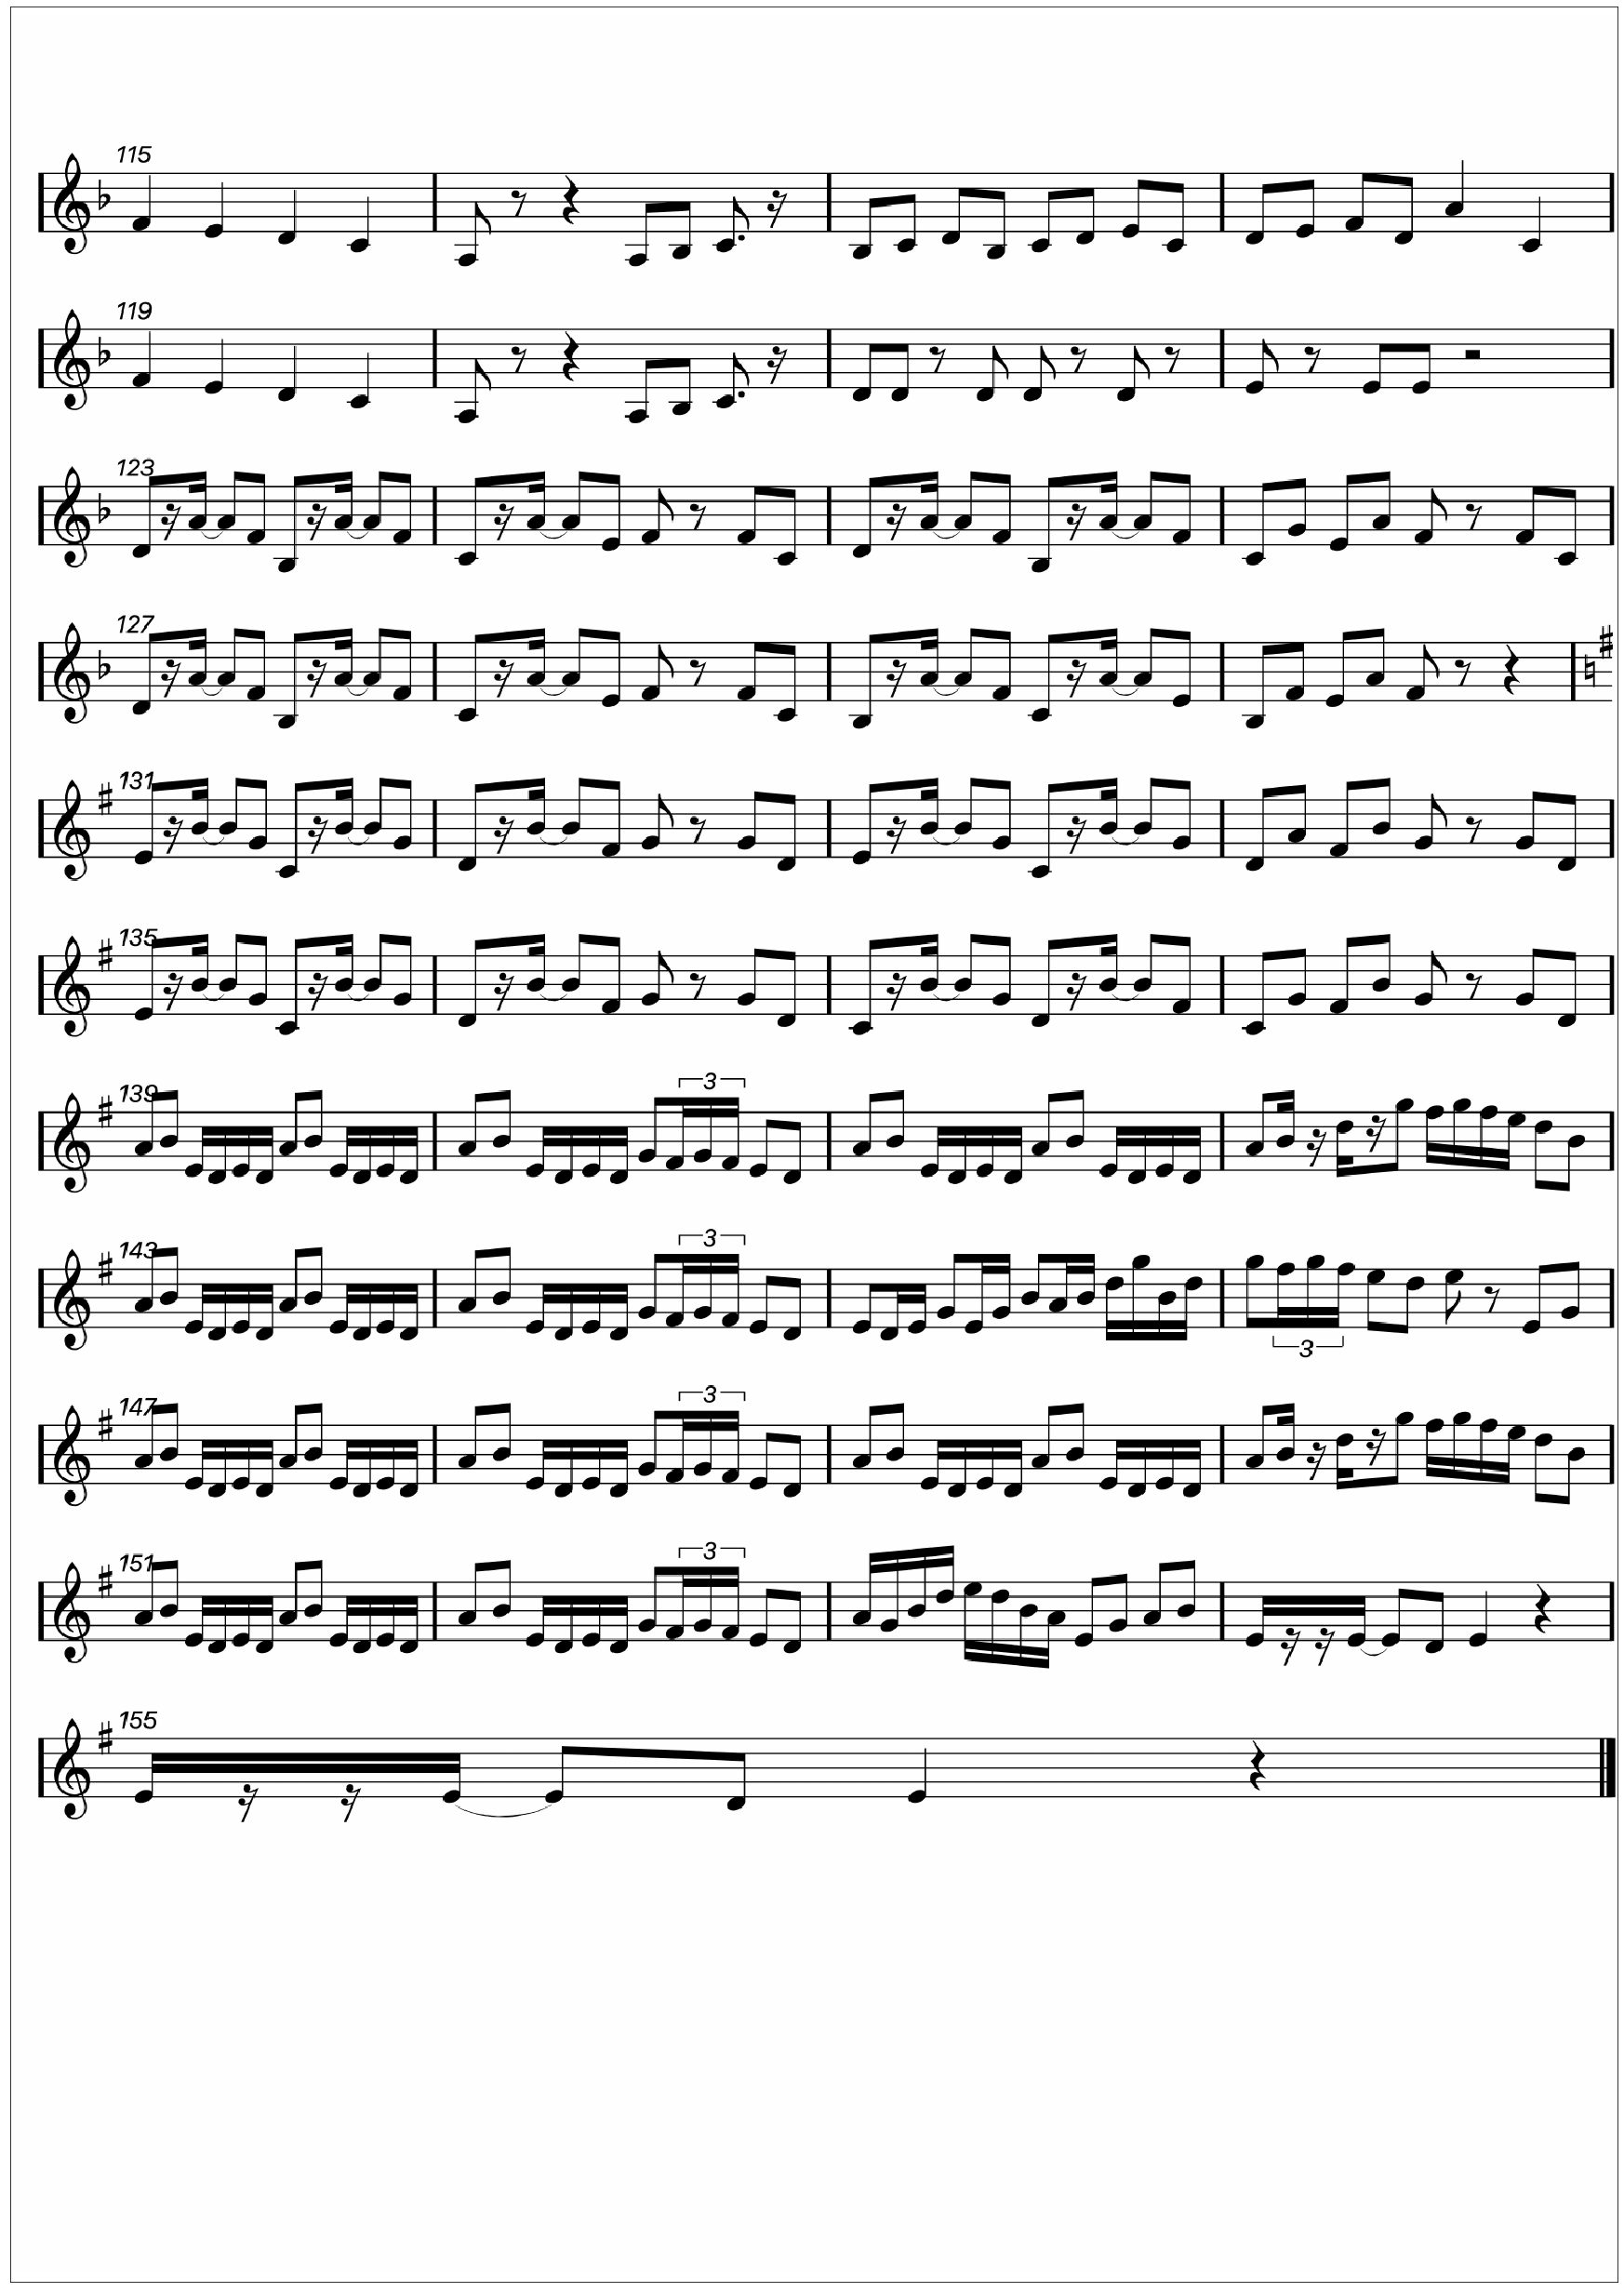

In [806]:
#pdfをpng画像に変換
unlockedpdf_path = "./../musicscore/koto_3p.pdf"
Convert_pdf_To_png(unlockedpdf_path)
#png画像の読み込み
musicsheet_path = "./../musicscore/koto_3p_1.png"
img_origin = cv2.imread(musicsheet_path,1)
img_origin_gray = cv2.imread(musicsheet_path,0)
print(type(img_origin))
print("オリジナル画像のサイズ：　",img_origin.shape)
plt.figure(figsize=(45,45))
plt.imshow(img_origin,cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()

### 2.画像の二値化
判別分析法を用いる<br>
1.輝度$c$ごとの頻度を計算し，ヒストグラム$p(c)$を作成．平均$\mu_T$と分散$\sigma^2_T$を計算する．<br>
2.ある閾値tでヒストグラムを二つに分けて，それぞれのクラス毎に生起確率$w(t)$と平均$\mu(t)$を計算．<br>
3.クラス間分散$\sigma^2_B$を計算し，$\sigma^2_B$を最大にするような閾値$t$を決定する．<br>
(クラス間分散$\sigma^2_B$とクラス内分散$\sigma^2_W$には以下の関係がある．<br>
$\sigma^2_W + \sigma^2_B = \sigma^2_T$<br>
$\sigma^2_T$は一定であり，$\sigma^2_B$の最大化は$\sigma^2_W$の最小化も同時に行っている．)<br><br>

$\sigma^2_B = w_1(t)w_2(t)(\mu_1(t)-\mu_2(t))^2 \\ 
= w(t)(1-w(t))\{ \frac{\mu(t)}{w(t)} - \frac{\mu_T - \mu(t)}{1-w(t)} \}^2$

In [807]:
def Make_Binomial_Image(img):
    """
    判別分析法によりグレー画像を二値画像に変換
    入力：グレー画像
    出力：二値画像
    """
    #諸統計量の計算
    c, c_counts = np.unique(img,return_counts=True)
    p = c_counts/np.sum(c_counts)
    muT = np.dot(c,p)
    sigmaB_opt = 0
    t_opt = 0
    
    #判別分析法
    for t in range(1,len(c)):
        w = np.sum(p[:t])
        mu = np.dot(c[:t],p[:t])
        sigmaB = w*(1 - w)*(mu/w - (muT-mu)/(1-w))**2
        if(sigmaB>sigmaB_opt):
            sigmaB_opt = sigmaB
            t_opt = t
    print("閾値：",t_opt)
    print("クラス間分散の最適値：",sigmaB_opt)
    #二値化
    binomial_img = img.copy()
    h = img.shape[0]
    for i in tqdm(range(h)):
        binomial_img[i,:] = np.array([255 if j>=t_opt else 0 for j in img[i,:]])
    return binomial_img

  2%|▏         | 38/2339 [00:00<00:06, 375.78it/s]

閾値： 139
クラス間分散の最適値： 4151.744611335288


100%|██████████| 2339/2339 [00:05<00:00, 413.23it/s]


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

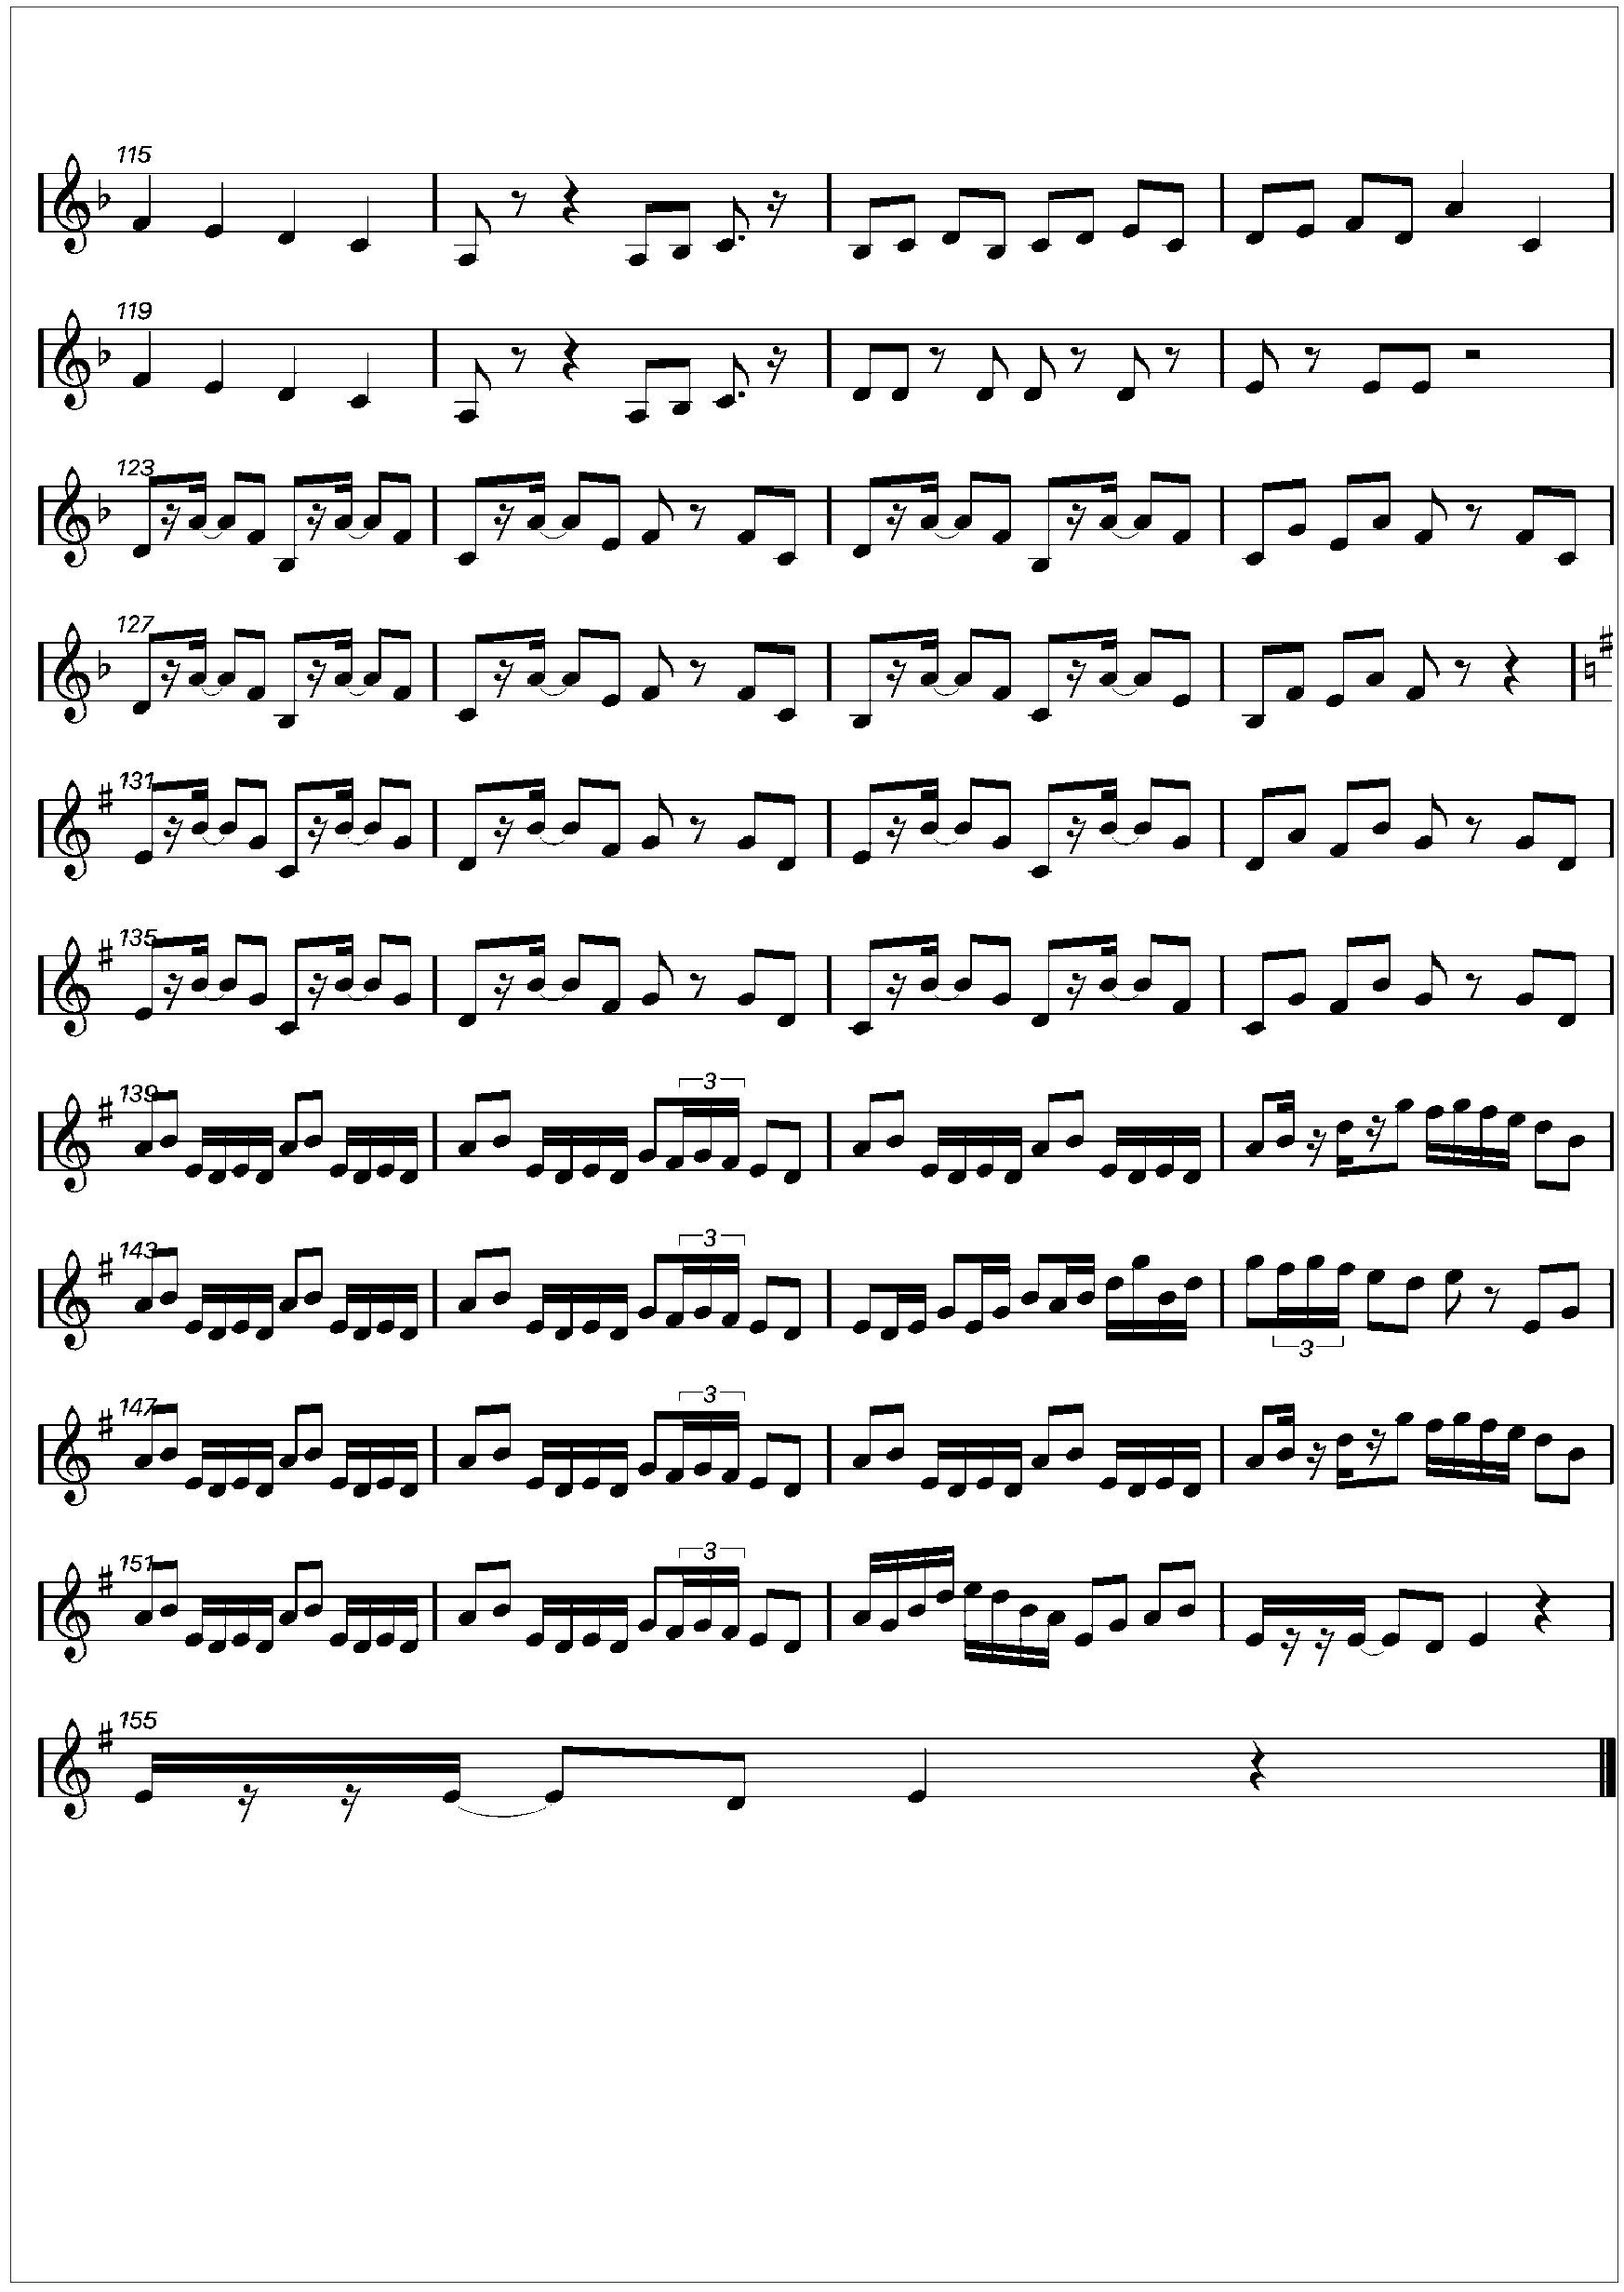

In [808]:
img = Make_Binomial_Image(img_origin_gray)
plt.figure(figsize=(45,45))
plt.imshow(img, cmap = "gray")
plt.xticks([]), plt.yticks([])
# plt.savefig('./test.png')

## 3.五線間隔の取得，探索線(音程線)の定義

- 画素値を反転し，y軸方向のヒストグラムのピークの位置を五線の位置とする．（反転させるのは画素値が白>黒であるため）
- ピーク間の間隔を計算しそれを五線間隔とする．
- ピーク検出はhttps://qiita.com/akinori-ito/items/005df0d6b73ba56bfe6d　を参照

楽譜の白黒を反転する．<br>
(cv2.bitwise_notは使わない．)
<!-- * y方向の画素値合計の頻度分布を求める．このときy方向の２行分を合計して頻度分布にする． -->

In [809]:
def Monochrome_Inversion(img):
    """
    二値画像を白黒反転させる
    入力：二値画像
    出力：白黒反転した二値画像
    """
    inverse_img = img.copy()
    h = img.shape[0]
    for i in tqdm(range(h)):
        inverse_img[i,:] = np.array([255 if j==0 else 0 for j in img[i,:]])
    return inverse_img

100%|██████████| 2339/2339 [00:05<00:00, 409.20it/s]


画像のサイズ: (2339, 1653)


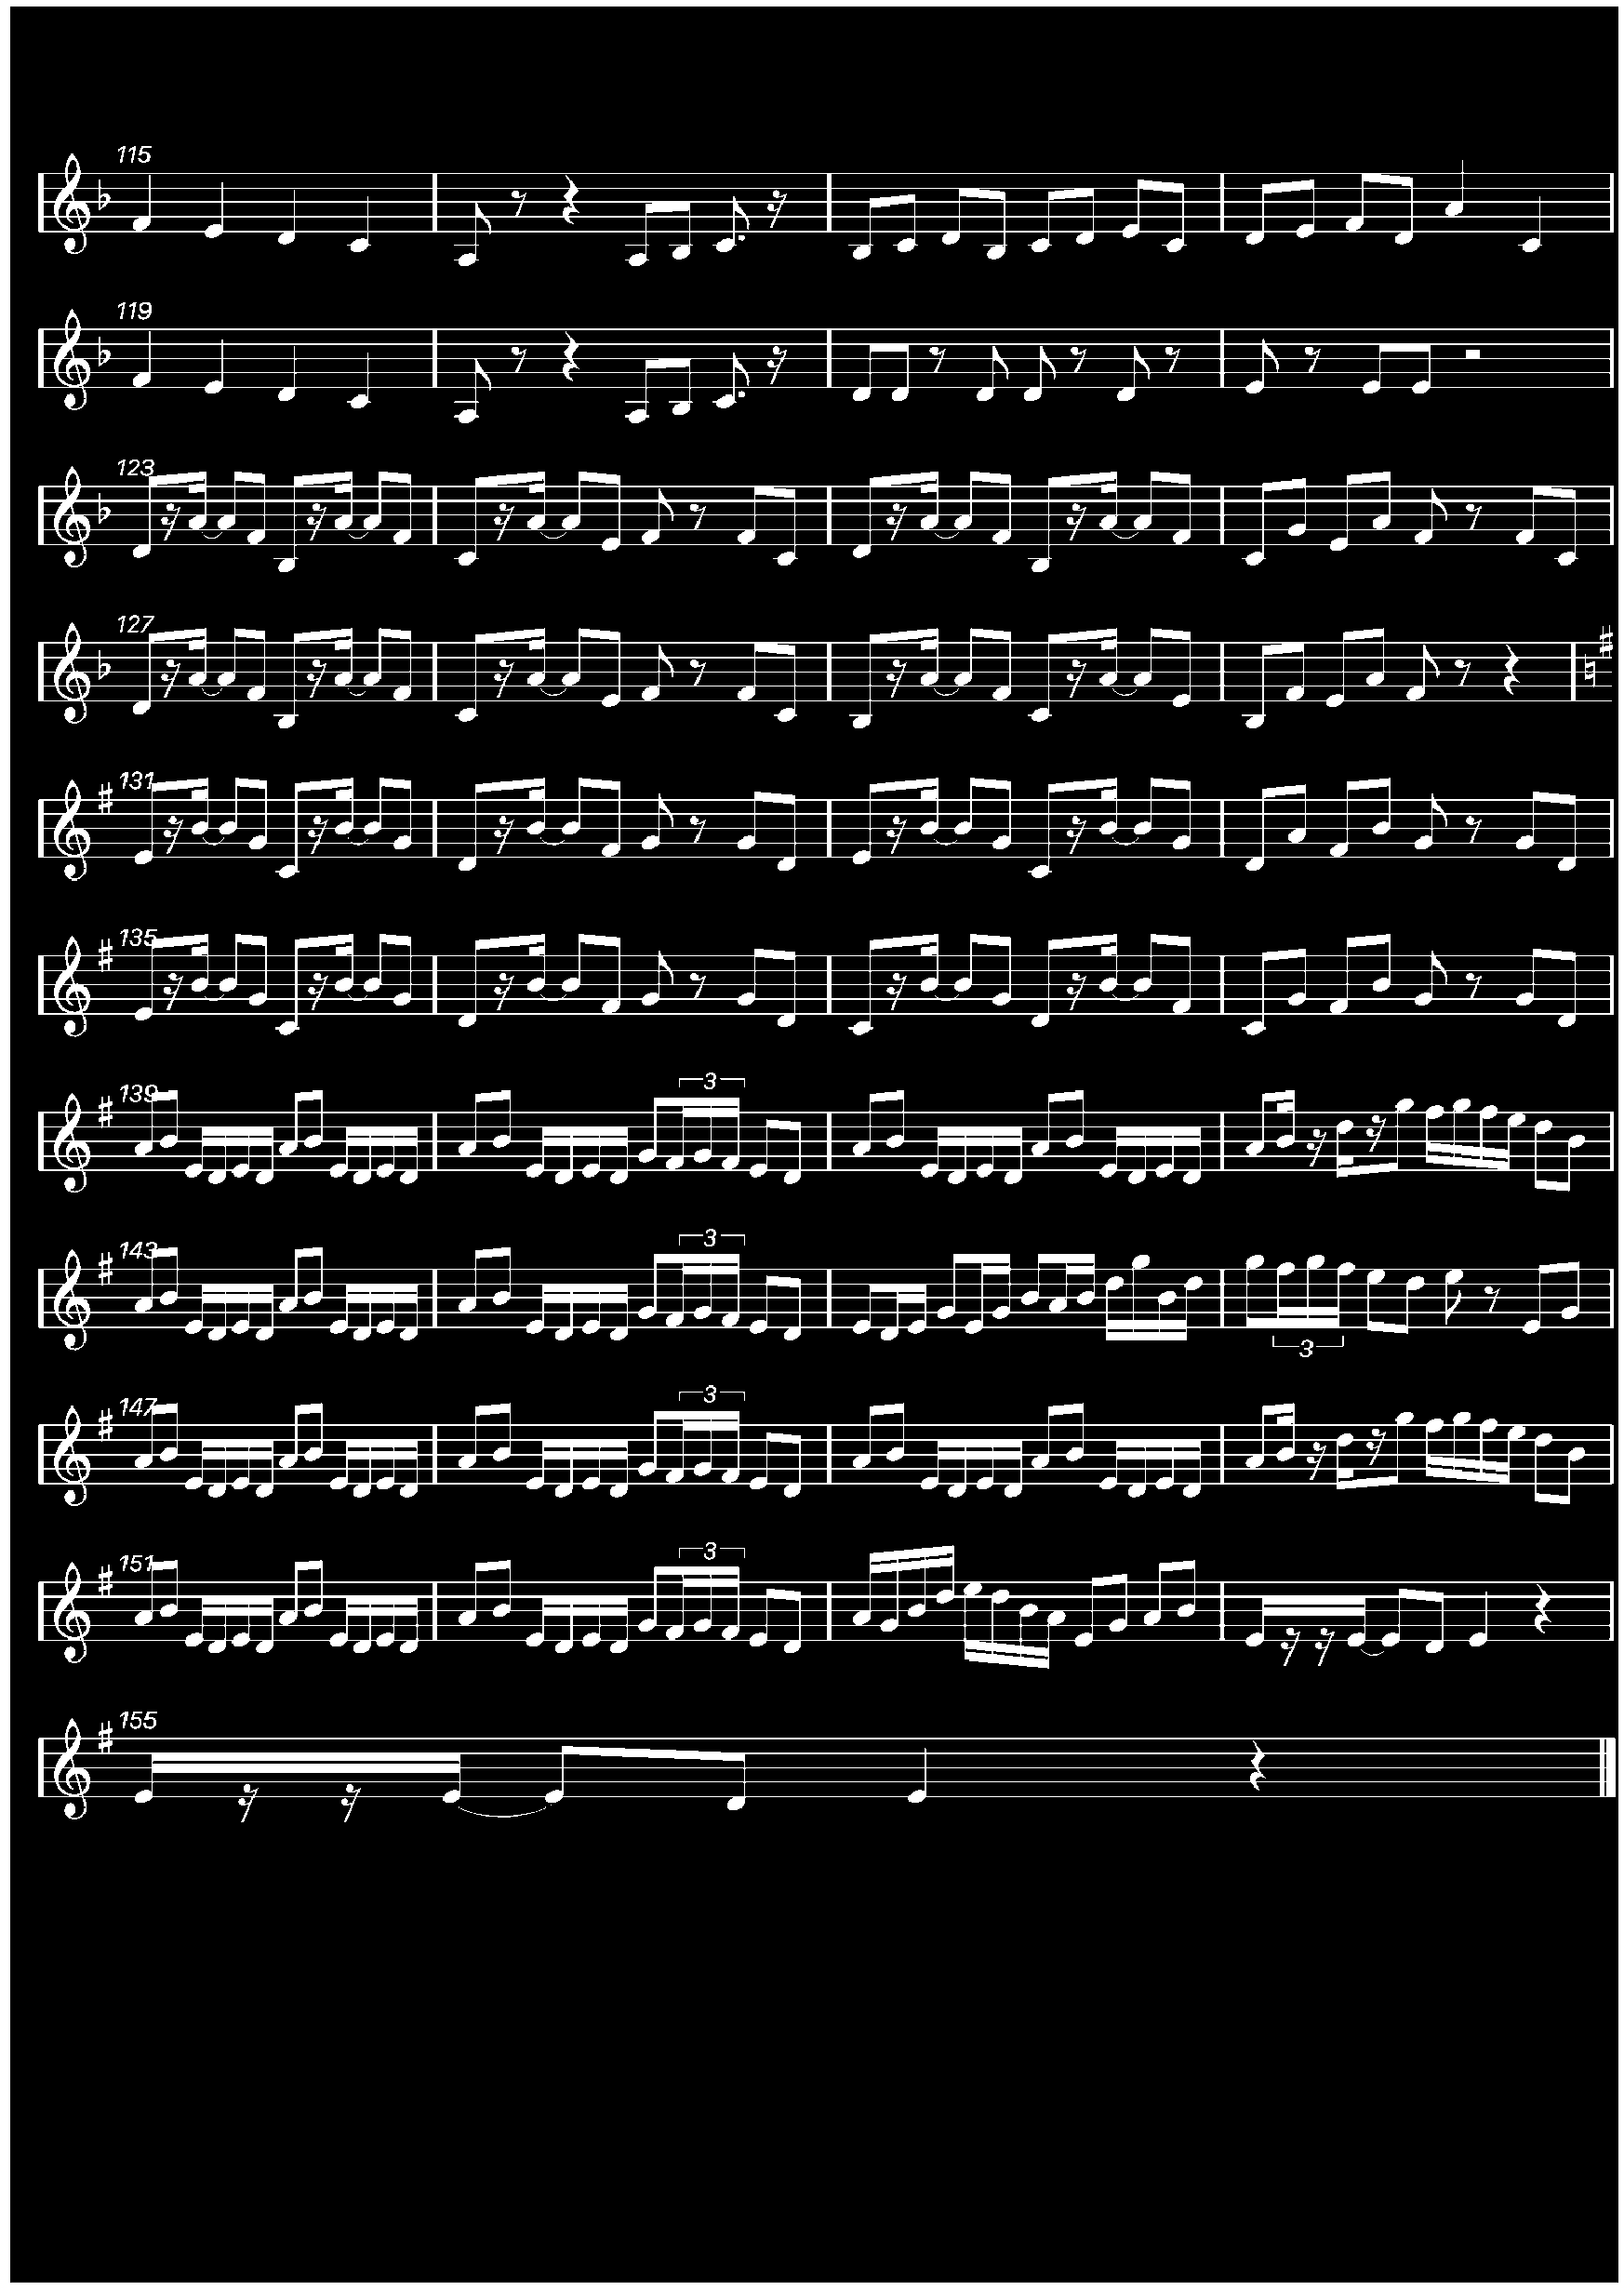

In [810]:
turncolor_img = Monochrome_Inversion(img)
print('画像のサイズ:',turncolor_img.shape)
plt.figure(figsize=(45,45))
plt.imshow(turncolor_img, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()

**五線座標，五線間隔を求める処理**

In [811]:
def Cal_Gosen_Index_And_Interval(binary_img, hipara_peak_ratio, hypara_peak_dif):
    """
    反転した二値画像から五線座標と五線間隔を計算する関数．
    
    まず五線座標の検出を行う．
    画像の縦方向の頻度分布を求め，その要素の差分からピーク検出．
    ピーク閾値を設定し，細かいピークを除くことにより，得られたピークから五線となる場所を特定．
    次に五線間隔を五線座標から計算する．
    配列の最後の五つの要素から五線間隔を求める．
    入力：二値画像
    出力：五線座標，五線間隔
    """
    h,w = binary_img.shape
#y方向の画素値合計の頻度分布を求める．（x方向に画素値を合計）
    y = np.zeros(h)#頻度分布
    for i in range(h):
        y[i] = np.sum(binary_img[i,:])

#ピーク位置検出
    #頻度分布の差分dyを計算
    dy = np.zeros(len(y)-1)
    for i in range(1,len(y)):
        dy[i-1]=y[i]-y[i-1]
    #差分dyの差分ddyを計算
    ddy = np.zeros(len(y)-2)
    for i in range(1,len(y)-1):
        ddy[i-1]=dy[i]*dy[i-1]
    
    #画素値の合計の閾値を設定し，必要なピークのみ取り出す
        ##設定方法：ピークの閾値＝x方向のピクセル数　×　255　×（x方向一直線上の五線の画像に対する割合hipara_peak_ratio）
    gosen_peak = np.array([])
    count=0
    for i in range(0,ddy.shape[0]):
        if ddy[i-1]<=0 and y[i]>img.shape[1]*255*hipara_peak_ratio:
            gosen_peak = np.append(gosen_peak,i)
            count+=1
    
    #ピーク位置周辺の細かいピークは除く処理を施す．
        ##具体的には，隣り合うピーク間隔が設定した閾値hypara_peak_dif以下(3くらい？)なら左側のピーク位置削除
    i=0
    while gosen_peak[-1] != gosen_peak[i]: 
        dif = gosen_peak[i+1] - gosen_peak[i]
        if dif <= hypara_peak_dif:
            gosen_peak = np.delete(gosen_peak,obj=i,axis=0)
            i -= 1
        i += 1
    gosen_peak = gosen_peak.astype(np.int32)
    
    #五線間隔を計算
    gosen_interval = 0
    for i in range(1,5):
        gosen_interval += (gosen_peak[-i] -gosen_peak[-i-1])/4.0
    
    return gosen_peak, gosen_interval

In [812]:
gosen_peak, gosen_interval = Cal_Gosen_Index_And_Interval(turncolor_img, hipara_peak_ratio=0.80, hypara_peak_dif=3)

print("細かいピーク削除後のピーク数：",len(gosen_peak))
print("細かいピーク削除後のピーク位置：",gosen_peak)
print("五線間隔：",gosen_interval)

print("-----------------------------------------------------------------------------")
#五線間隔は少数第一位を四捨五入して用いる（音符認識にかなり効いてくる．．．）
gosen_interval =round(gosen_interval, 1)
# print(gosen_peak[20],gosen_peak[21],gosen_peak[27],gosen_peak[33],gosen_peak[39]\
#       ,gosen_peak[45],gosen_peak[51])
# gosen_peak = gosen_peak[1:]#タイトル線画ある場合だけ有効
print("タイトル線削除後のピーク数：",len(gosen_peak))
print("タイトル線のピーク位置：",gosen_peak)
print("四捨五入後の五線間隔：",gosen_interval)
print(type(gosen_interval))

細かいピーク削除後のピーク数： 55
細かいピーク削除後のピーク位置： [ 172  187  202  217  231  333  348  362  377  392  494  509  523  538
  553  655  670  684  699  714  816  831  845  860  875  976  991 1006
 1021 1036 1137 1152 1167 1182 1196 1298 1313 1328 1343 1357 1459 1474
 1489 1504 1518 1620 1635 1649 1664 1679 1781 1796 1810 1825 1840]
五線間隔： 14.75
-----------------------------------------------------------------------------
タイトル線削除後のピーク数： 55
タイトル線のピーク位置： [ 172  187  202  217  231  333  348  362  377  392  494  509  523  538
  553  655  670  684  699  714  816  831  845  860  875  976  991 1006
 1021 1036 1137 1152 1167 1182 1196 1298 1313 1328 1343 1357 1459 1474
 1489 1504 1518 1620 1635 1649 1664 1679 1781 1796 1810 1825 1840]
四捨五入後の五線間隔： 14.8
<class 'numpy.float64'>


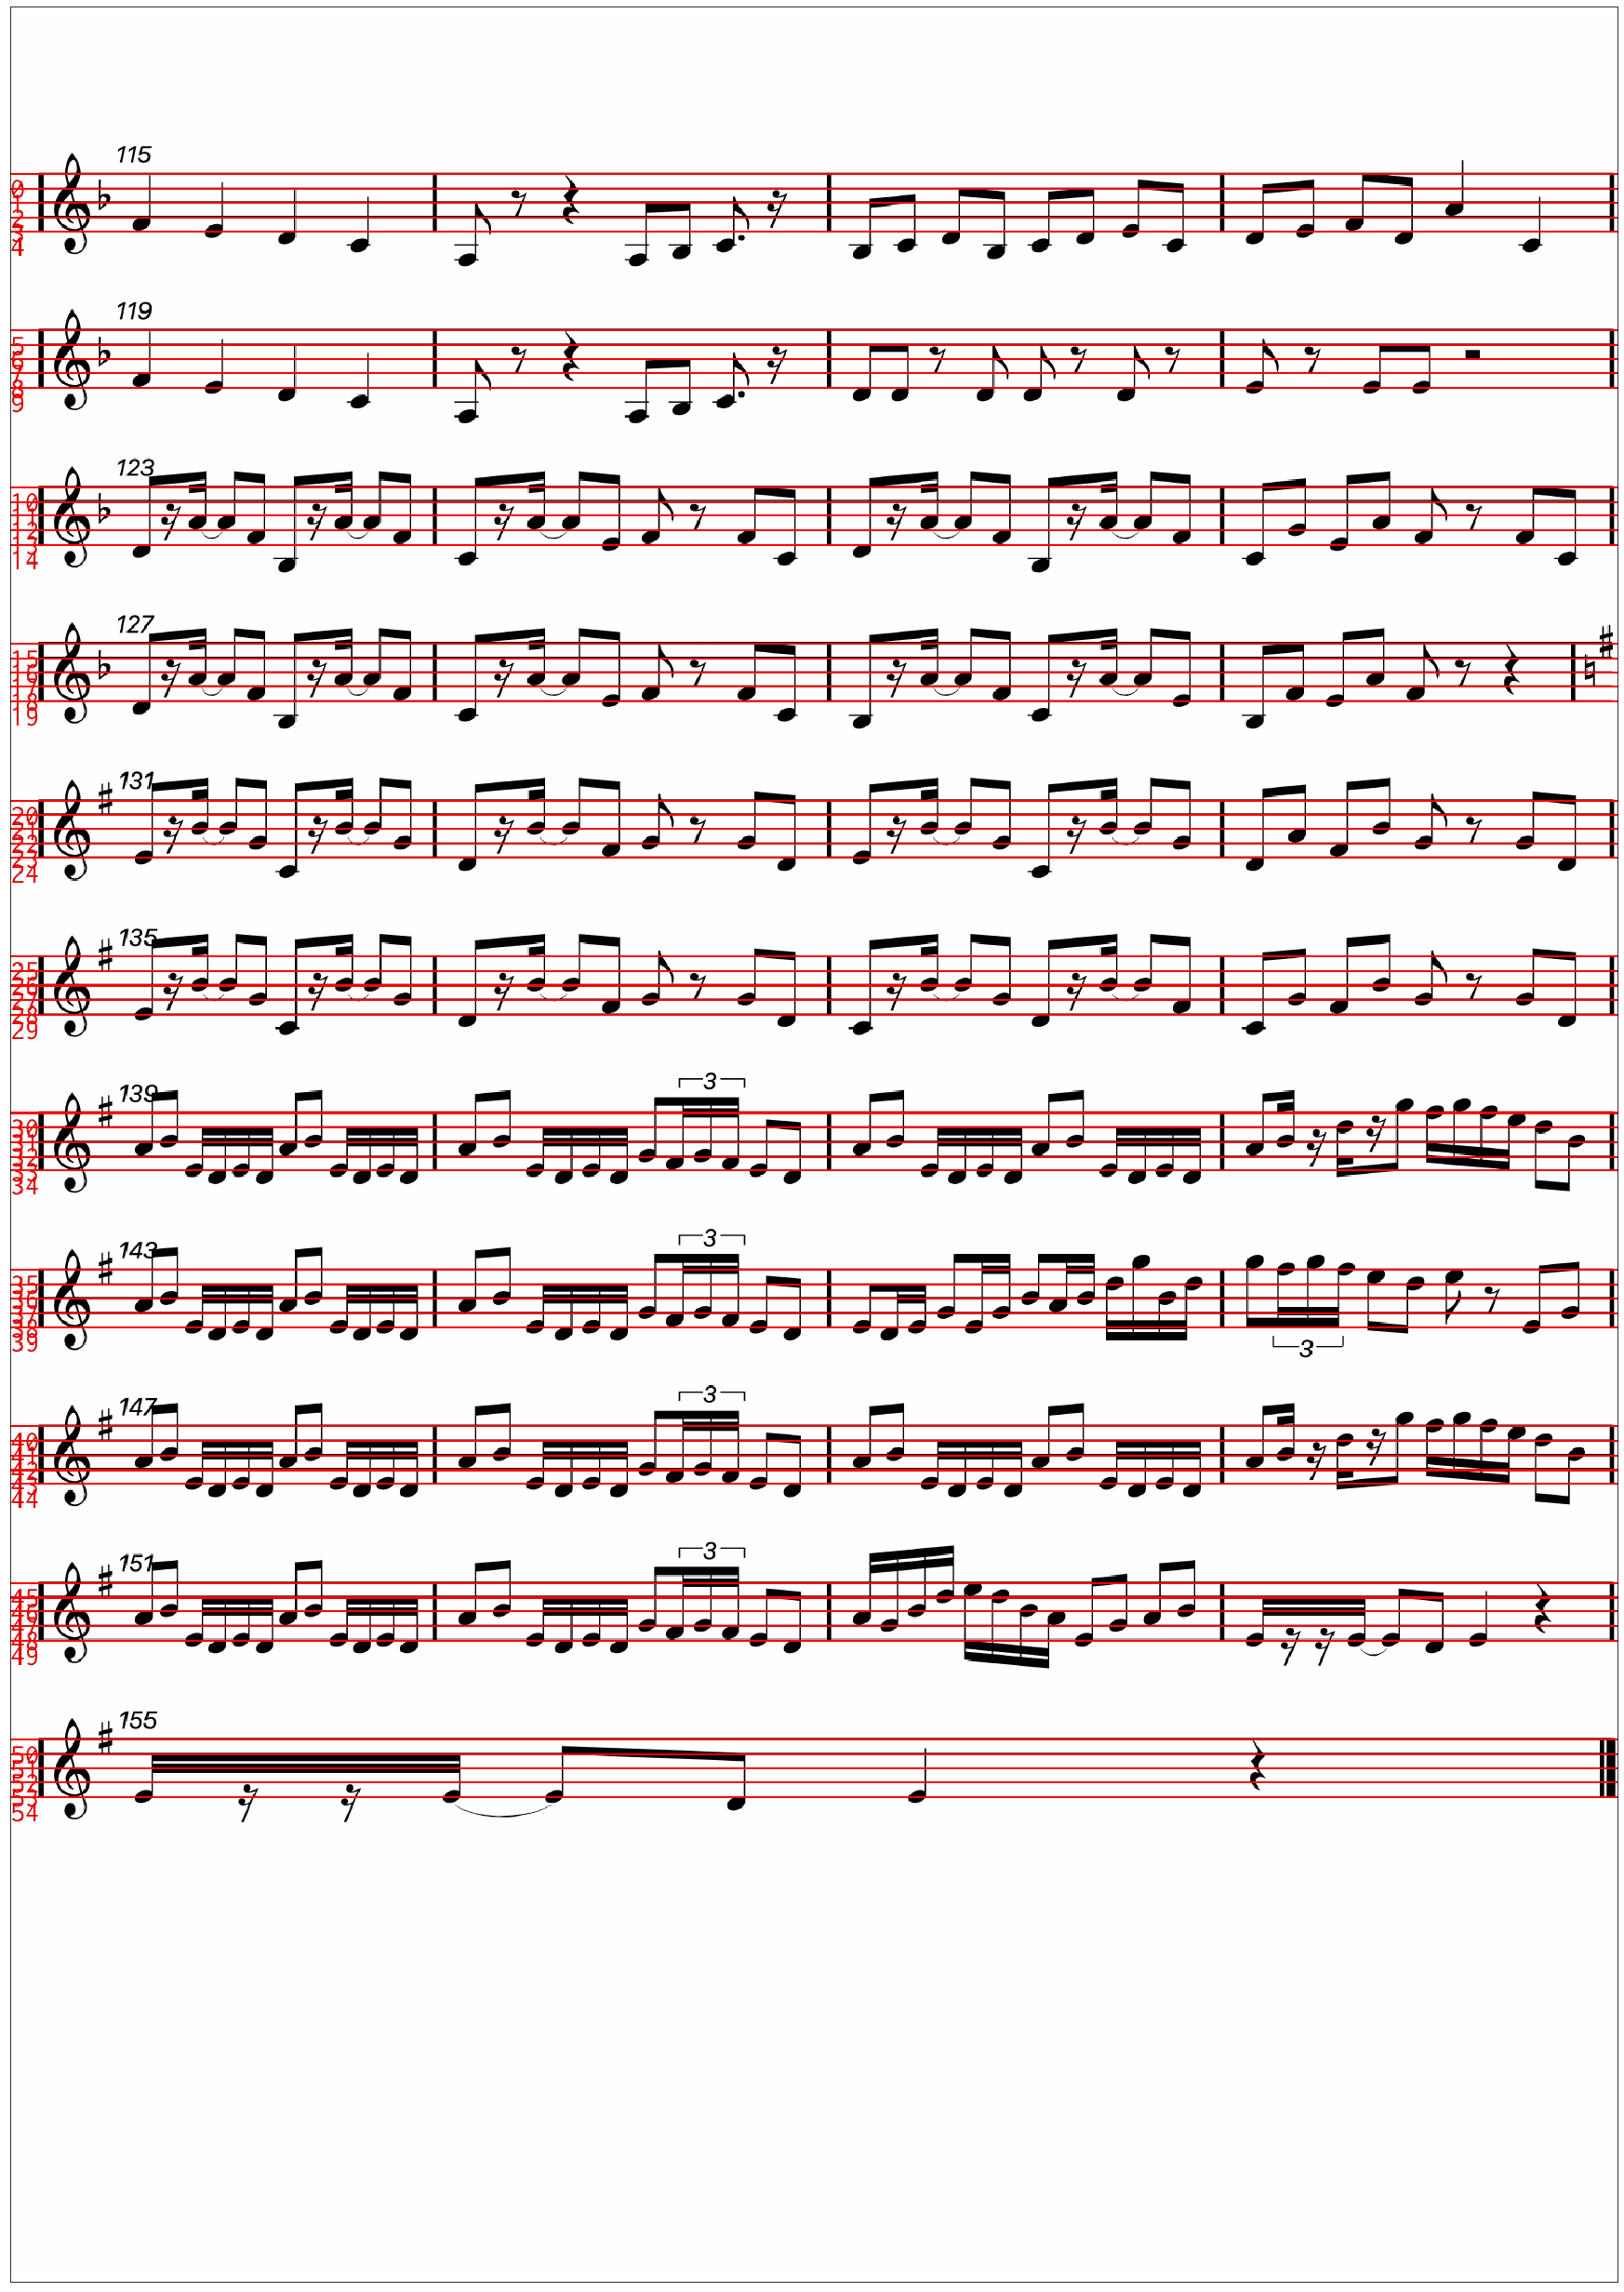

In [813]:
#五線の検出結果を画像上に表示
from PIL import Image, ImageDraw
img_draw = Image.fromarray(img_origin) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意
font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
font_size = 30       # フォントサイズ
fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義
for idx,a in enumerate(gosen_peak):
    draw.line([(0,a), (img_origin.shape[1],a)] , fill='red',  width=2)
    draw.text((0,a),'{0}'.format(idx), font=fnt,fill=222)
img_draw.show()
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

**探索線を定義する**

検出した五線位置からさらに上下に線を加える．(加える本数は適宜設定?)<br>
線を加えた五線間の中間の座標を求め，五線とその中間線を合わせてものを探索線と定義する．

In [814]:
def Define_Searchline(gosen_peak,gosen_interval,n):
    """
    探索線を定義する．
    
    入力：五線の位置，五線間隔，n:上下に何本五線を増やすか？(ex n=2なら上下に二本ずつ増える．探索線としては，4本増える)
    出力：(行ごとにまとめた)探索線の位置
    """
    #五線を組みでまとめる．
    gosen_peak_group = []
    for i in range(int(len(gosen_peak)/5)):
        gosen_peak_group.append(gosen_peak[5*i:5*i+5]) 
    print(gosen_peak_group)
        
    #五線peakを拡張する．(上下にn本ずつ足す)
    for i in range(len(gosen_peak_group)):
        plus_line = []
        for l in range(n):
            plus_line.append(gosen_peak_group[i][0]-(n-l)*int(gosen_interval))
            gosen_peak_group[i] = np.append(gosen_peak_group[i]\
                                    ,gosen_peak_group[i][-1]+int(gosen_interval))
        gosen_peak_group[i] = np.insert(gosen_peak_group[i],0,plus_line)
    
    #五線間の中間の座標を求め，探索線を定義する．
    tyukan = []
    searchline = []
    for i in range(len(gosen_peak_group)):
        tyukan.append([])
        searchline.append([])
    for i in range(len(gosen_peak_group)):
        for j in range(len(gosen_peak_group[i])-1):
            res = int((gosen_peak_group[i][j]+gosen_peak_group[i][j+1])/2)
            tyukan[i].append(res) 
    for i in range(len(gosen_peak_group)):
        searchline[i] = np.insert(gosen_peak_group[i],[i for i in range(1,len(gosen_peak_group[i]))],tyukan[i])
    return searchline

In [815]:
searchline = Define_Searchline(gosen_peak,gosen_interval,n = 4)
print('行数:',len(searchline))
print('一行あたりの探索線の本数:',len(searchline[0]))
print(searchline)

[array([172, 187, 202, 217, 231], dtype=int32), array([333, 348, 362, 377, 392], dtype=int32), array([494, 509, 523, 538, 553], dtype=int32), array([655, 670, 684, 699, 714], dtype=int32), array([816, 831, 845, 860, 875], dtype=int32), array([ 976,  991, 1006, 1021, 1036], dtype=int32), array([1137, 1152, 1167, 1182, 1196], dtype=int32), array([1298, 1313, 1328, 1343, 1357], dtype=int32), array([1459, 1474, 1489, 1504, 1518], dtype=int32), array([1620, 1635, 1649, 1664, 1679], dtype=int32), array([1781, 1796, 1810, 1825, 1840], dtype=int32)]
行数: 11
一行あたりの探索線の本数: 25
[array([116, 123, 130, 137, 144, 151, 158, 165, 172, 179, 187, 194, 202,
       209, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287]), array([277, 284, 291, 298, 305, 312, 319, 326, 333, 340, 348, 355, 362,
       369, 377, 384, 392, 399, 406, 413, 420, 427, 434, 441, 448]), array([438, 445, 452, 459, 466, 473, 480, 487, 494, 501, 509, 516, 523,
       530, 538, 545, 553, 560, 567, 574, 581, 588, 595, 602, 609]), arra

※おまけ<br>
配列の中で誤差の範囲で検出してしまう要素を間引く(典型的な値を検出する)関数を作る.<br>
入力：配列，誤差の範囲　　　　　　　<br>
出力：間引き後の配列<br><br>
例)誤差の範囲を±3と設定<br>
[2,3,3,4,15,16,15,17,178,175,176]→[2,15,175](誤差の範囲中の最小値が検出される) 

In [816]:
def Detect_TypicalValues(array,error):
    """
    配列の中で誤差の範囲で検出してしまう要素を間引く(典型的な値を検出する)
    
    入力：numpy配列array， 誤差の範囲error
    出力：間引き後の配列
    """
    array = np.sort(array)
    i=0
    if len(array)==0:
        return array
    else:
        while array[-1] != array[i]: 
            dif = np.abs(array[i+1] - array[i])
            if dif <= error:
                array = np.delete(array,obj=i+1,axis=0)
                i -= 1
            i += 1
    return array

In [817]:
a = np.array([2,3,3,4,15,16,15,17,178,175,176])
# a = np.array([])
# a = np.array([2,3,4,5,6,7,8,9])
error = 3
Detect_TypicalValues(a,error)

array([  2,  15, 175])

## 4.五線，小節線の消去
・縦方向の黒のランレングスの分布を計算し，分布のピーク位置を五線の太さとしてを検出<br>
・縦方向の黒のランレングスのうち，五線の太さ±1のものを消去.ただし，消去する箇所が横方向で短い場合，消去を解除

#### 五線の太さを検出

In [818]:
def Detect_GosenWidth(img):
    """
    縦方向の黒のランレングスの分布を計算し，分布のピーク位置を五線の太さとしてを検出
    入力：二値画像    出力：五線の太さ
    """
    h,w = img.shape
    counts = np.zeros(h)
    
    for j in tqdm(range(w)):
        rl = 0
        flag = False
        for i in range(h):
            if img[i,j]==0:
                rl += 1
                flag = True
            else:
                if flag==True:
                    flag = False
                    counts[rl] += 1
                rl = 0
    gosen_width = np.argmax(counts)
    return gosen_width

In [819]:
gosen_width = Detect_GosenWidth(img)
print("五線の太さ:",gosen_width)
print("五線の位置：",gosen_peak)

100%|██████████| 1653/1653 [00:06<00:00, 258.78it/s]

五線の太さ: 2
五線の位置： [ 172  187  202  217  231  333  348  362  377  392  494  509  523  538
  553  655  670  684  699  714  816  831  845  860  875  976  991 1006
 1021 1036 1137 1152 1167 1182 1196 1298 1313 1328 1343 1357 1459 1474
 1489 1504 1518 1620 1635 1649 1664 1679 1781 1796 1810 1825 1840]


#### 五線を消去

In [820]:
def Delete_Gosen(img,gosen_width):
    """
     縦方向の黒のランレングスのうち，五線の太さ±1のものを消去.ただし，消去する箇所が横方向で短い場合，消去を解除.
    方法:　消去するピクセルの候補をフラグ画像として持っておき，フラグ画像のフラグのランレングスを計算し，
    ランレングスが短いものはフラグを解除．その後，フラグ画像に従い五線を消去する．
    
    入力：二値画像　，五線の太さ
    出力：五線を消去した二値画像
    """
    img_delete = img.copy()
    h,w = img_delete.shape
    flagimg = np.zeros((h,w))
    
    ##消去するピクセルの候補をフラグ画像として保存
    for j in tqdm(range(w)):
        rl = 0
        flag = False
        for i in range(h):
            if img_delete[i,j]==0:
                rl += 1
                flag = True
            else:
                if flag==True:
                    flag = False
                    if rl<=gosen_width +1 and gosen_width -1<= rl:
                        for k in range(rl+1):
                            flagimg[i-k,j] = 1
                rl = 0
    ##フラグのランレングスの短いものを削除．
    for i in tqdm(range(h)):
        rl = 0
        flag = False
        for j in range(w):
            if flagimg[i,j]==1:
                rl += 1
                flag = True
            else:
                if flag==True:
                    flag = False
                    if rl<=8:
                        for k in range(rl+1):
                            flagimg[i,j-k] = 0
                rl = 0
    ##フラグ画像に従い，五線を消去
    for i in tqdm(range(h)):
        for j in range(w):
            if flagimg[i,j]==1:
                img_delete[i,j] = 255
    return img_delete

**小節線の検出と消去**

In [821]:
def DetectAndDelete_Bar(img,searchline,gosen_interval,gosen_width,n):
    """
     縦方向の黒のランレングスのうち，五線間隔*(5-1)*n+gosen_width*5以上のものは削除.(nは，何行に渡って一本の小節線が存在するか)
     削除する部分のx座標と五線idを同時に保存．
    
    入力：二値画像,探索線,五線間隔,小節の区切りを共有している五線セットの数(適宜設定)
    出力：小節線を消去した二値画像，[小節線のx座標，‥](五線idごとにまとめる)
    """
    img_delete = img.copy()
    h,w = img_delete.shape
    flagimg = np.zeros((h,w))
    info_bar = []
    
##消去するピクセルの候補にフラグ1を立てる
#消去する部分のx座標と五線idをinfo_barに保存
    for j in tqdm(range(w)):
        rl = 0
        flag = False
        for i in range(h):
            if img_delete[i,j]==0:
                rl += 1
                flag = True
            else:
                if flag==True:
                    flag = False
                    if rl >= gosen_interval* 4*n:###小節線の長さの閾値を設定
                        #消去予定場所にフラグを立てる
                        for k in range(rl+1):
                            flagimg[i-k,j] = 1
                        #消去する部分のx座標と五線idをinfo_barに保存
                        for gosen_id,gosen in enumerate(searchline):
                            if i>=gosen[0] and i<= gosen[-1]:
                                info_bar.append([j,gosen_id])
                                break
                rl = 0
##x座標が近いやつは削除
    #まず小節線を五線idごとにグループ分け
    info_bar = np.array(info_bar)
#     print(info_bar)
    info_bar_ =  info_bar[np.argsort(info_bar[:,1],axis=0)]
    start = 0
    t = 0
    res = []
    for gosen_id in range(len(searchline)):
        kari = []
        for j in range(start ,info_bar_.shape[0]):
            if info_bar_[j,-1]==gosen_id:
                kari.append(info_bar_[j,0])
                t += 1
        start = t
        if (gosen_id>=1) and (gosen_id%n != 0):
            for i in range(1,n):
                res[gosen_id-i] = kari
        res.append(kari)
    #x座標が近いやつは削除(±5の範囲)
#     print(res)
    result = []
    for i in range(len(res)):
        result.append(Detect_TypicalValues(res[i],5))
##フラグ画像に従い，小節線を消去
    for i in tqdm(range(h)):
        for j in range(w):
            if flagimg[i,j]==1:
                img_delete[i,j] = 255
    return img_delete,result

100%|██████████| 2339/2339 [00:01<00:00, 1673.04it/s]


-------------行ごとの小節数------------
1行めの小節数: 9
2行めの小節数: 6
3行めの小節数: 19
4行めの小節数: 18
5行めの小節数: 19
6行めの小節数: 19
7行めの小節数: 12
8行めの小節数: 20
9行めの小節数: 13
10行めの小節数: 16
11行めの小節数: 4


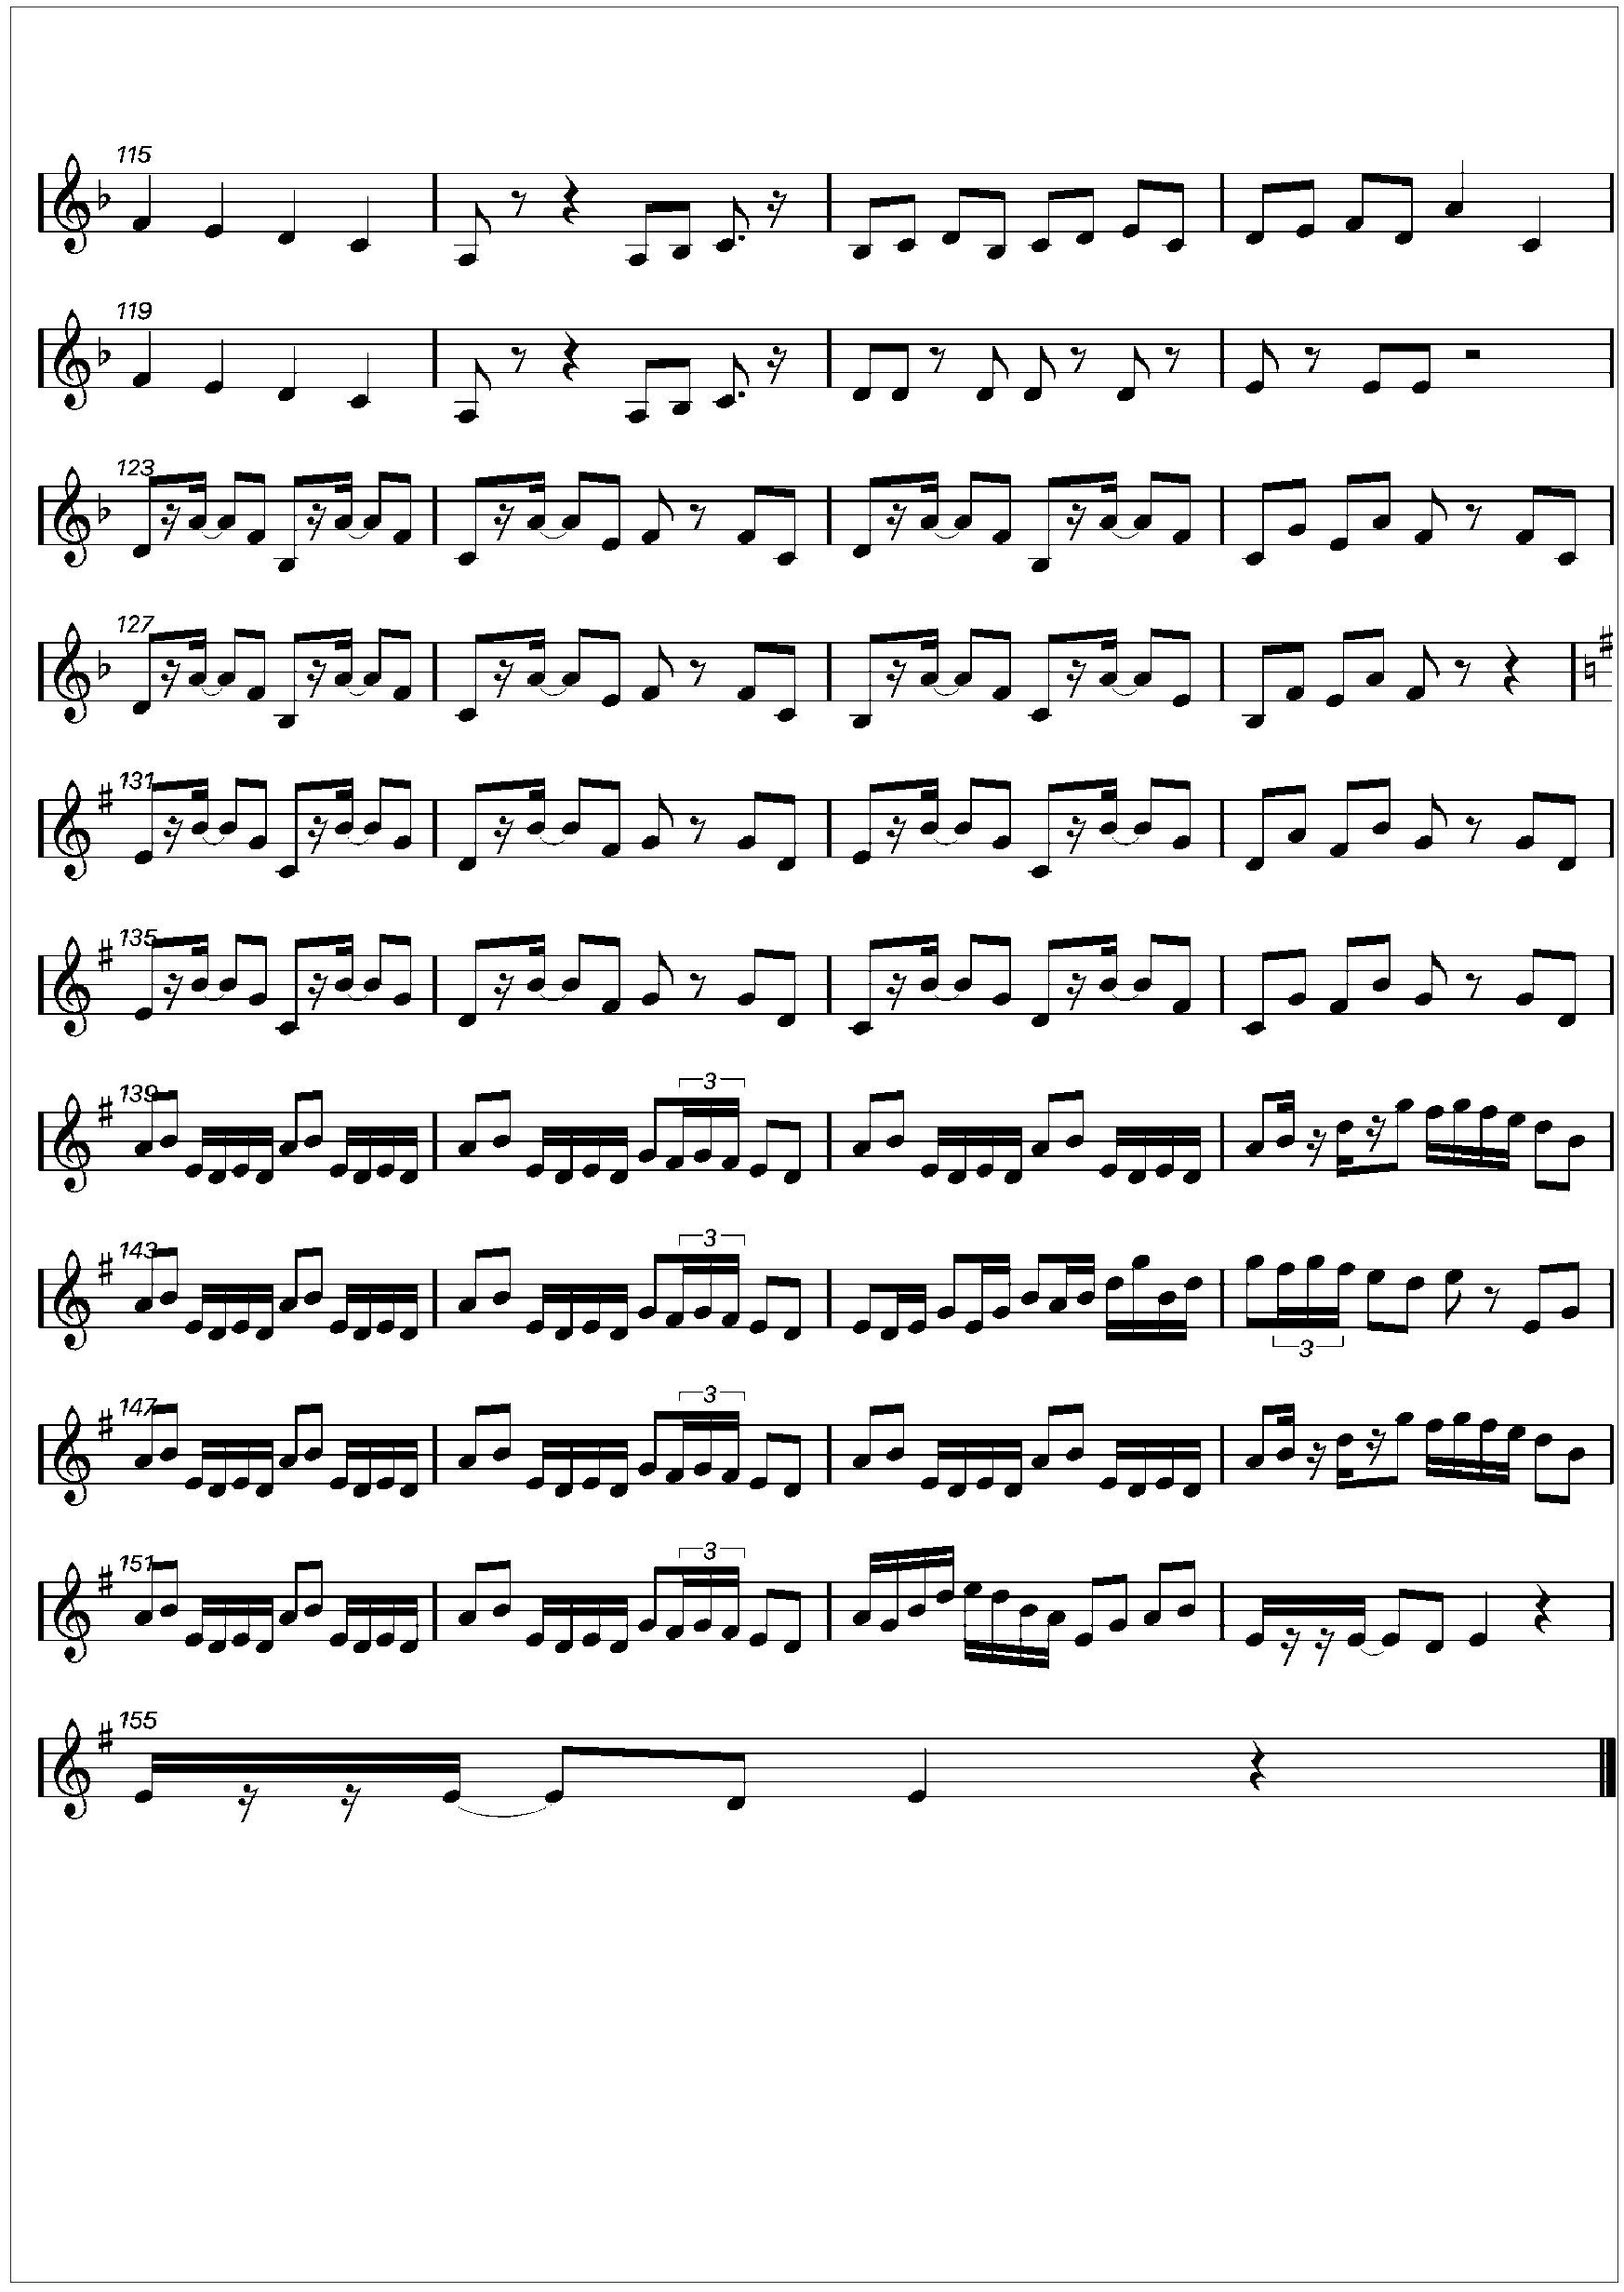

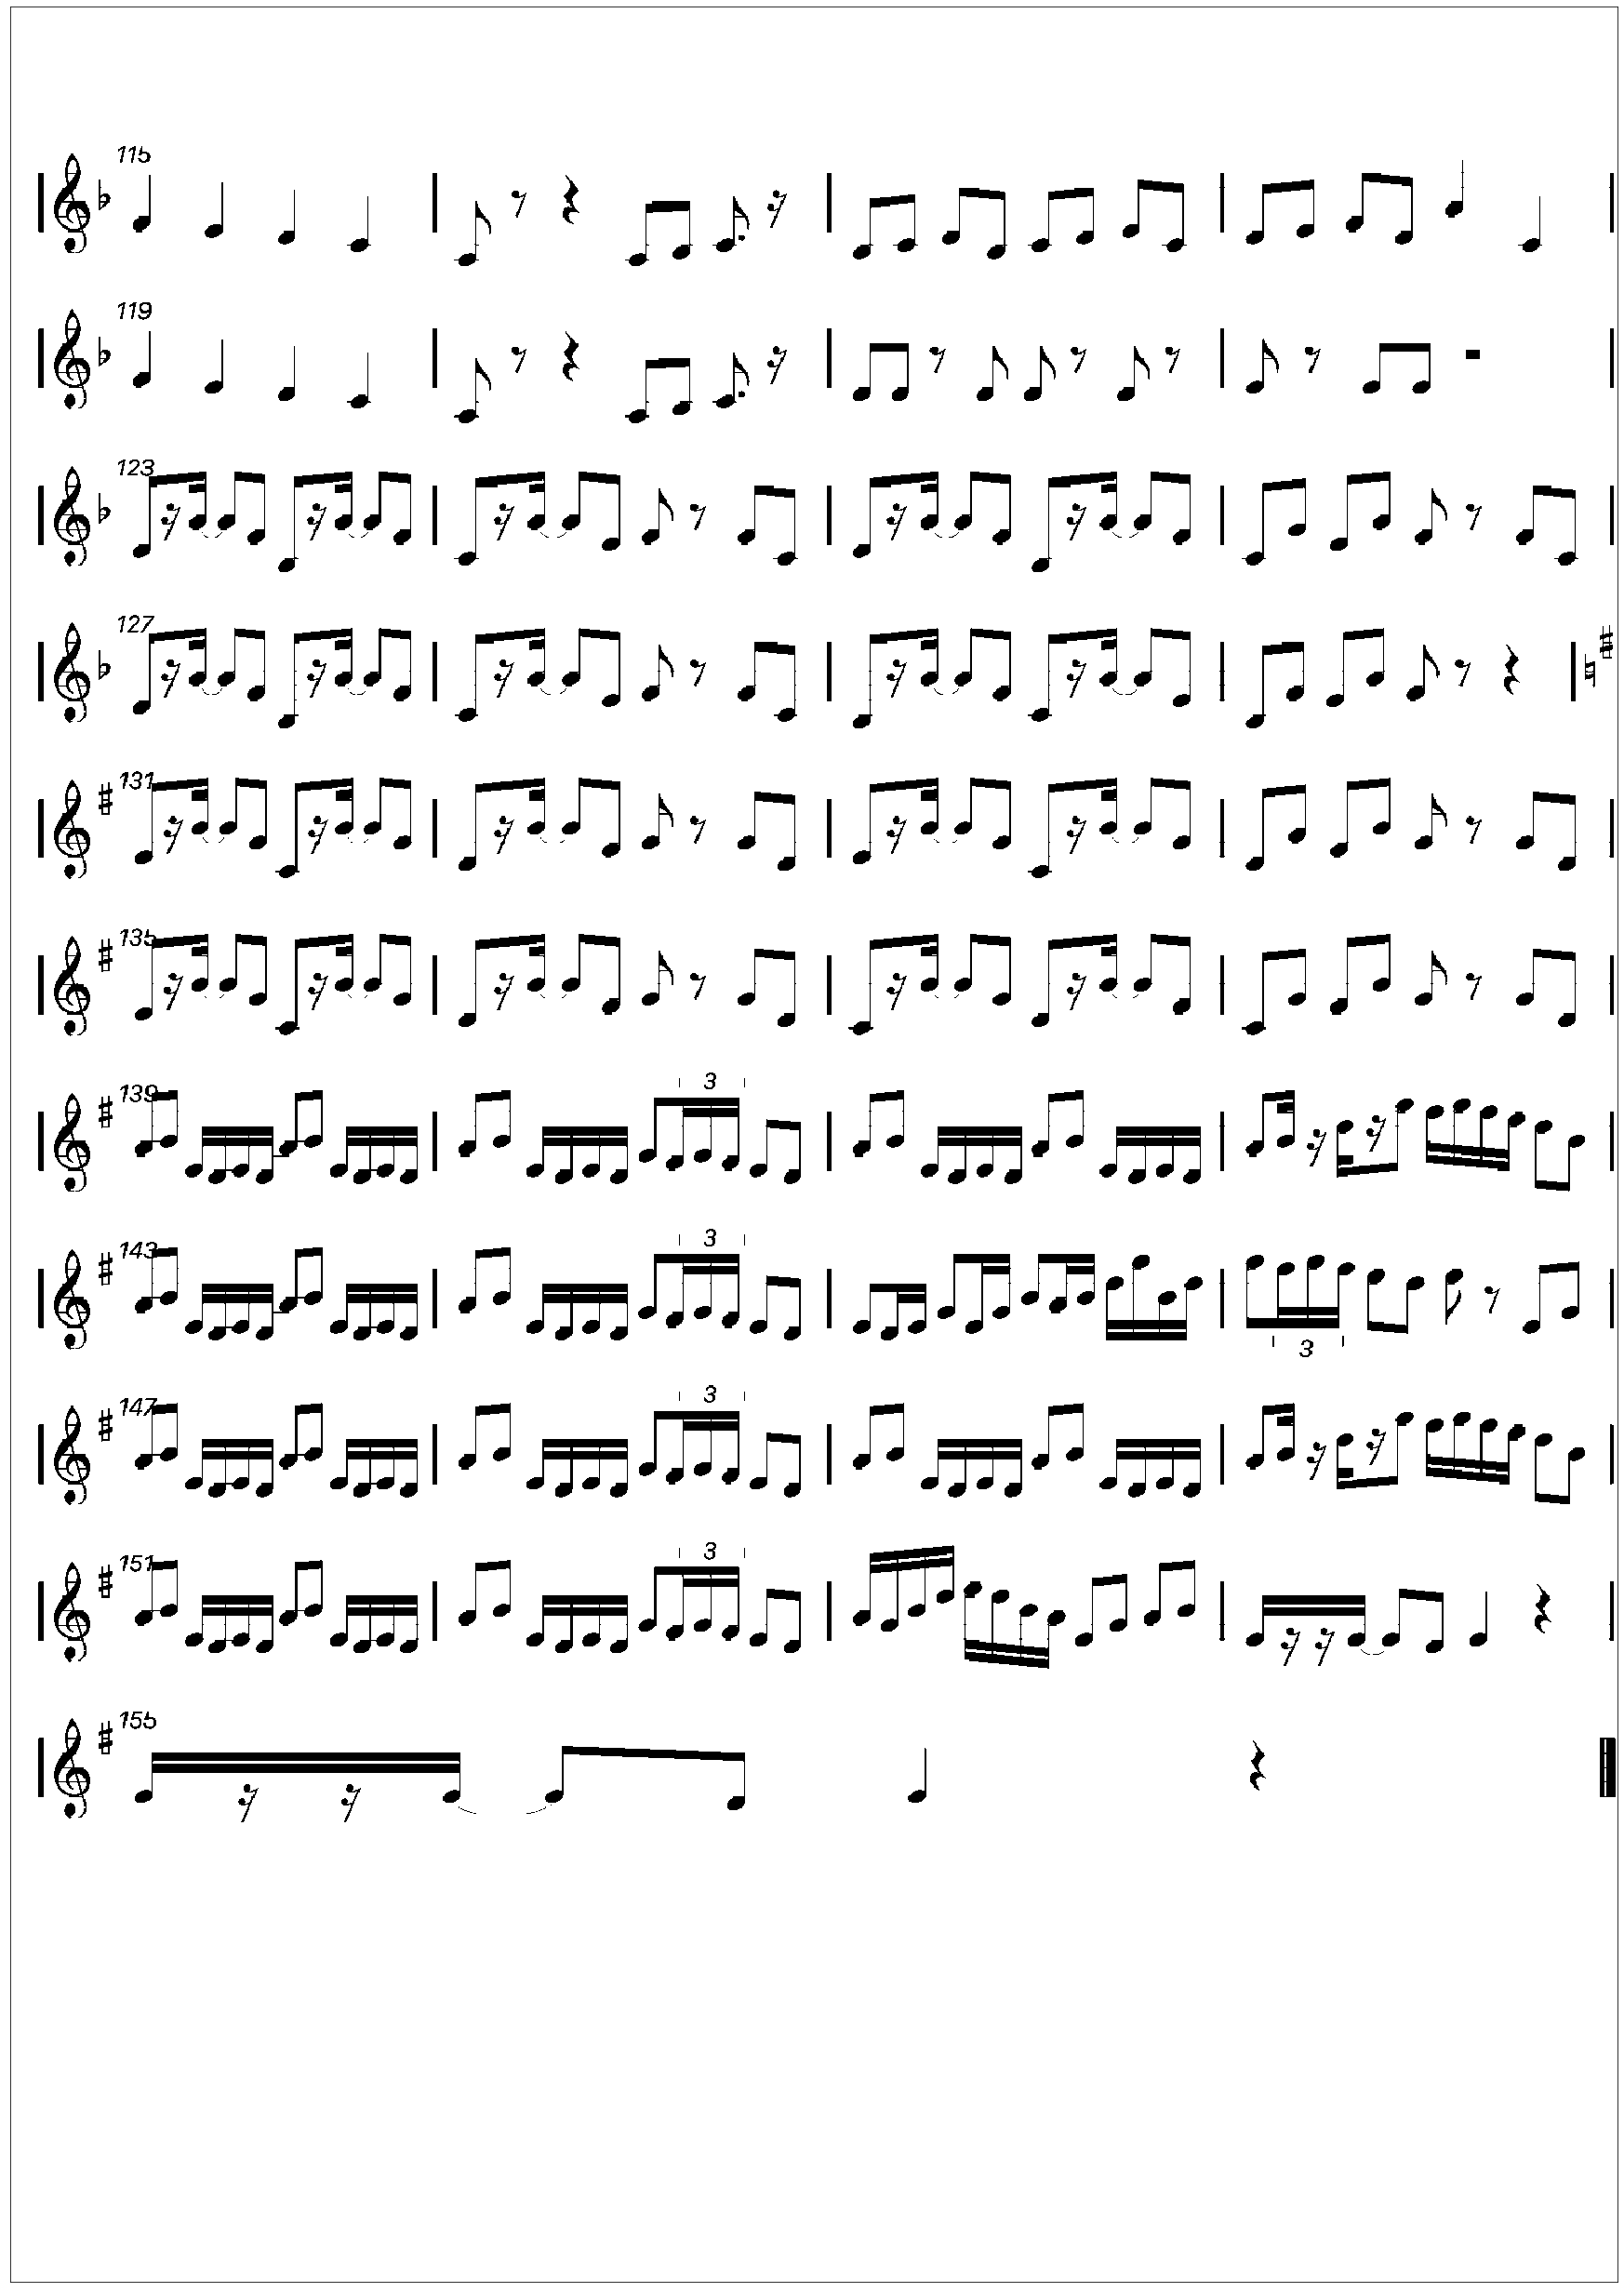

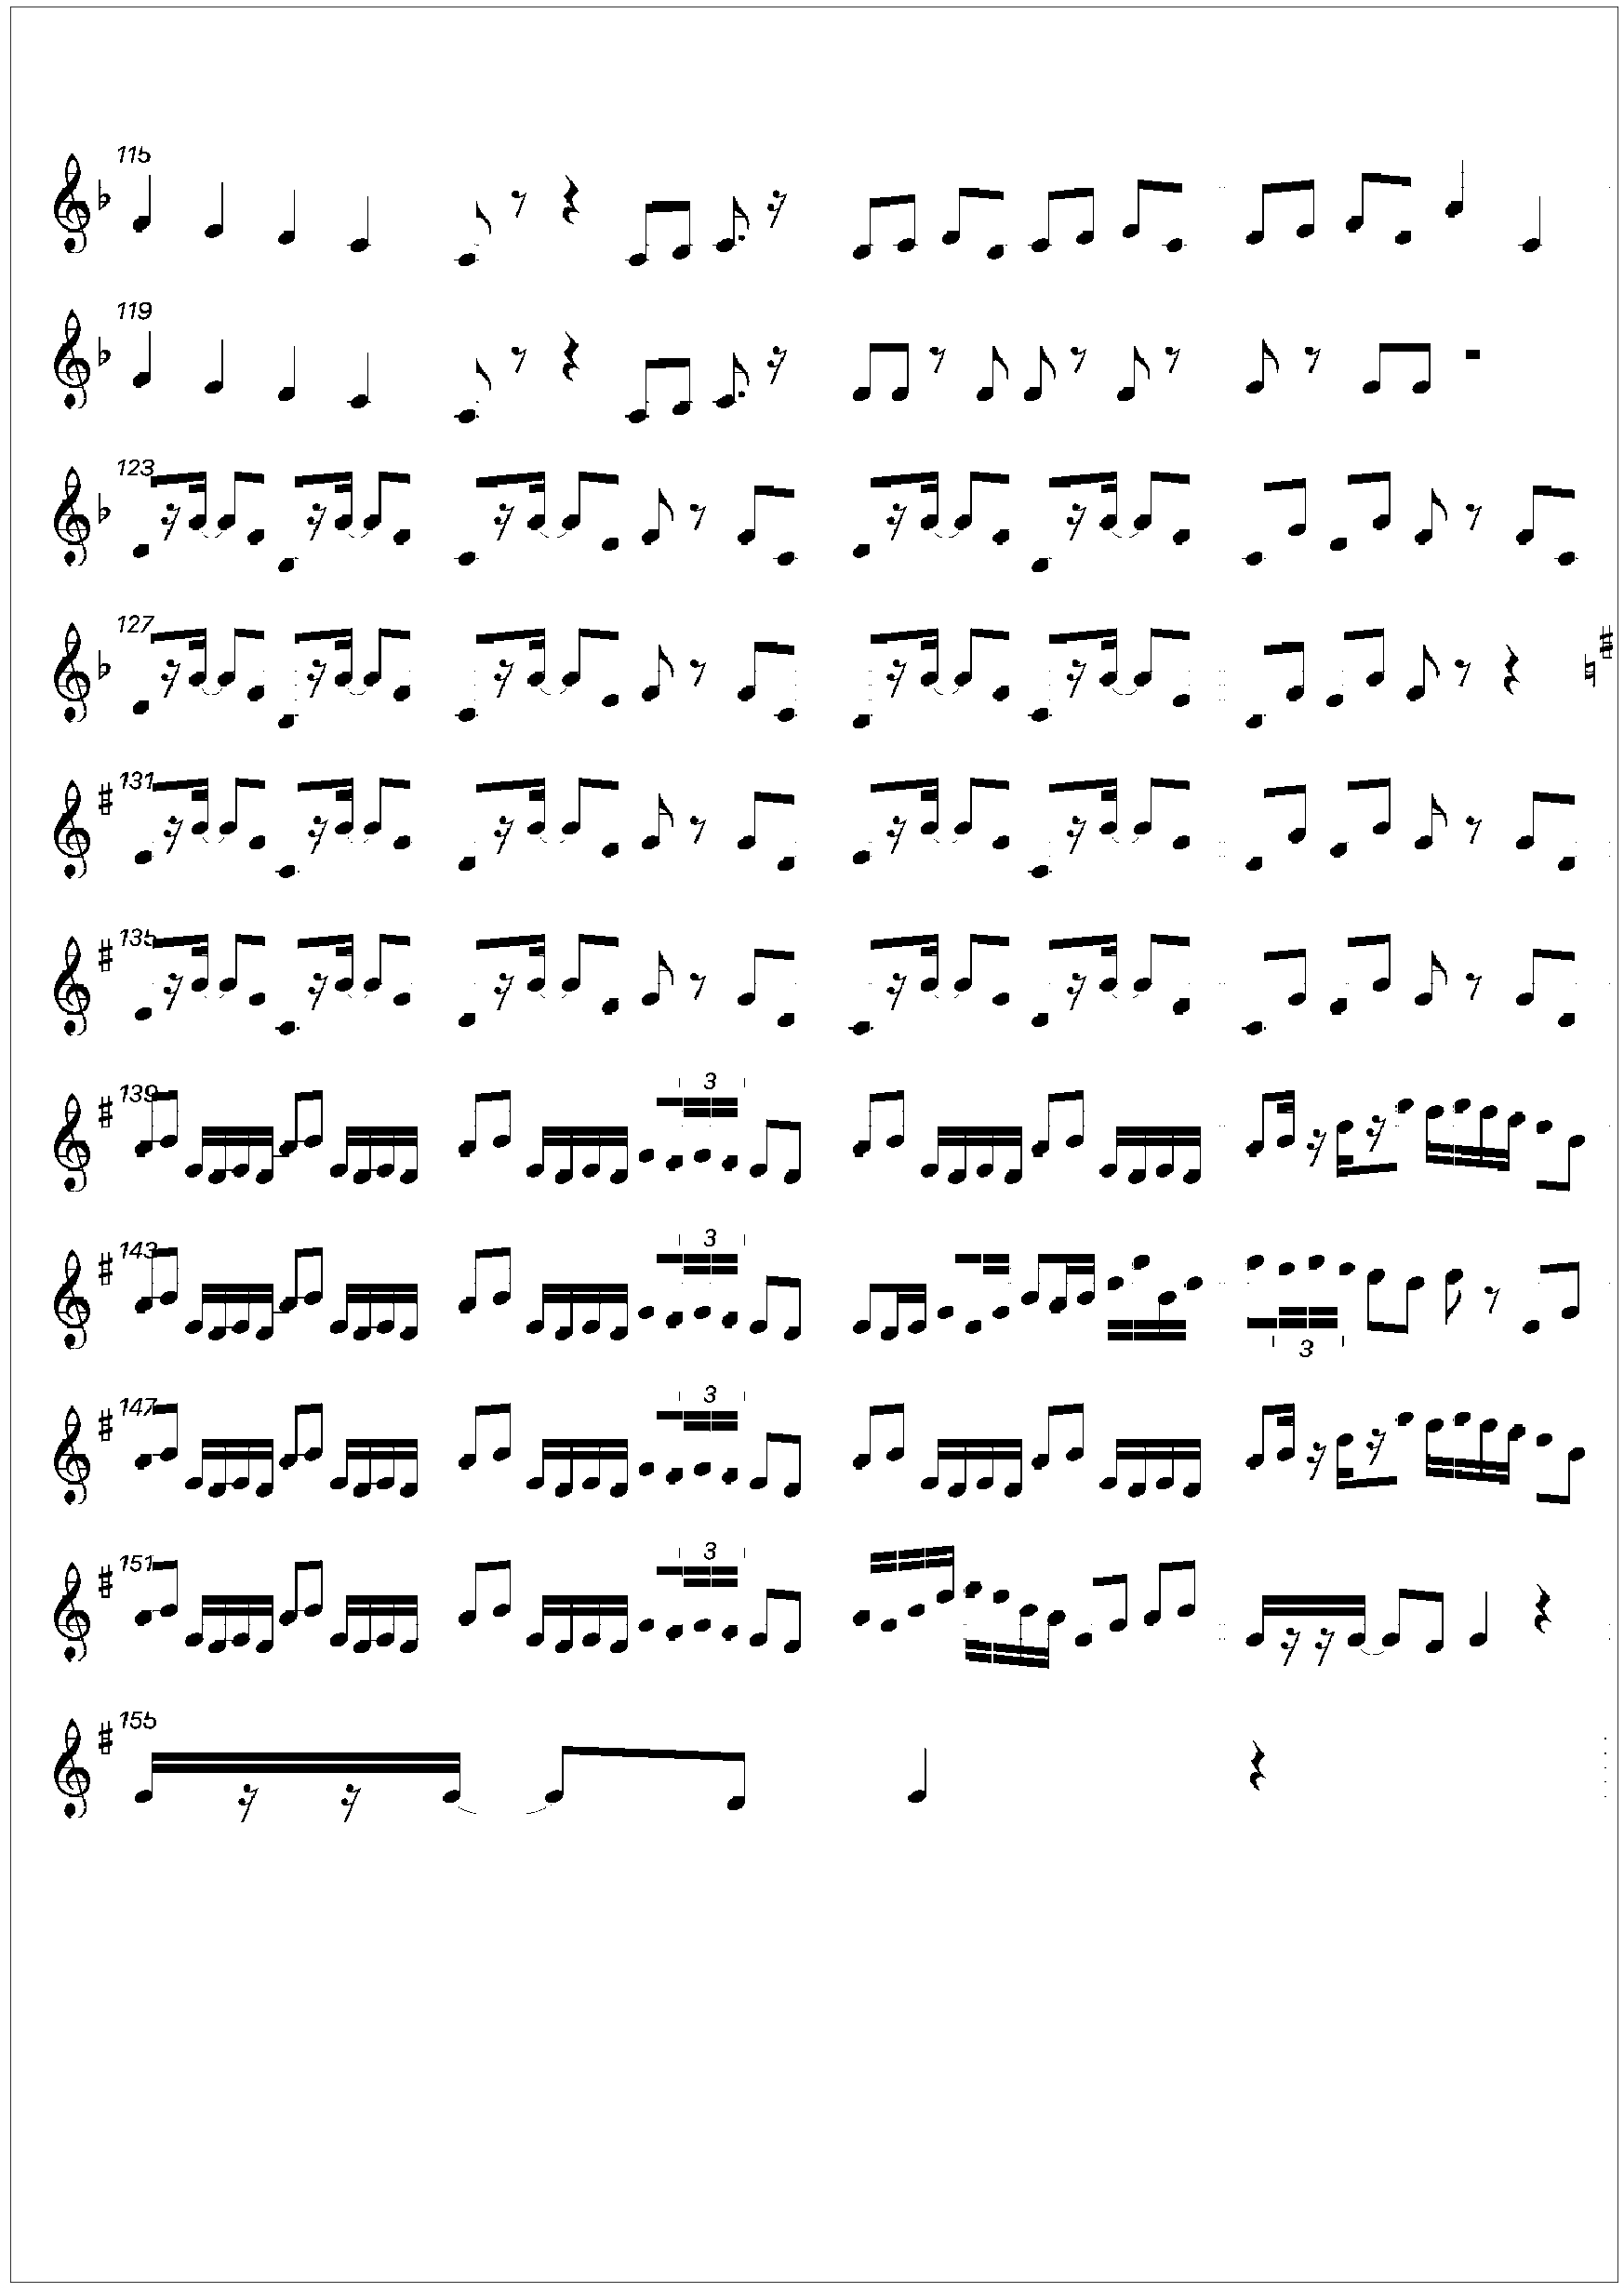

In [822]:
img_delete_gosen = Delete_Gosen(img,gosen_width)
# img_delete = img_delete_gosen
img_delete,info_bar = DetectAndDelete_Bar(img_delete_gosen,searchline,gosen_interval,gosen_width,n=1)
print('-------------行ごとの小節数------------')
for i,bar in enumerate(info_bar):
    print('{0}行めの小節数:'.format(i+1),len(bar))

fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img, cmap = "gray")
plt.xticks([]), plt.yticks([])

fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_delete_gosen, cmap = "gray")
plt.xticks([]), plt.yticks([])

fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_delete, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

In [823]:
for i in range(len(searchline)):
    print('-------------{0}行めの小節線:------------'.format(i+1))
    print(len(info_bar[i]))
    print(info_bar[i])

-------------1行めの小節線:------------
9
[  29  434  478  839 1021 1205 1244 1440 1644]
-------------2行めの小節線:------------
6
[  29  434  478  839 1244 1644]
-------------3行めの小節線:------------
19
[  29  142  261  292  411  434  478  625  806  839  883 1027 1067 1212
 1244 1287 1374 1608 1644]
-------------4行めの小節線:------------
18
[  29  142  261  292  411  434  478  625  806  839  883 1027 1067 1212
 1244 1287 1370 1604]
-------------5行めの小節線:------------
19
[  29  145  262  293  411  434  478  625  806  839  883 1027 1067 1212
 1244 1287 1374 1608 1644]
-------------6行めの小節線:------------
19
[  29  145  262  293  411  434  478  625  806  839  883 1027 1067 1212
 1244 1287 1374 1608 1644]
-------------7行めの小節線:------------
12
[  29  434  662  691  720  748  839 1244 1425 1484 1567 1644]
-------------8行めの小節線:------------
20
[  29  434  662  691  720  748  839  969  998 1027 1126 1154 1208 1244
 1271 1302 1333 1364 1572 1644]
-------------9行めの小節線:------------
13
[  29  145  434  662  691  720  748  8

In [824]:
img_delete = img_delete_gosen

## 5.ラベリング
連結している画像に同じラベルをふることで，複数の領域をグループとして分類する<br>
cv2.connectedComponents(img)を使う．

五線削除画像img_deleteの画素値を反転させる．

100%|██████████| 2339/2339 [00:06<00:00, 379.45it/s]


画像のサイズ: (2339, 1653)


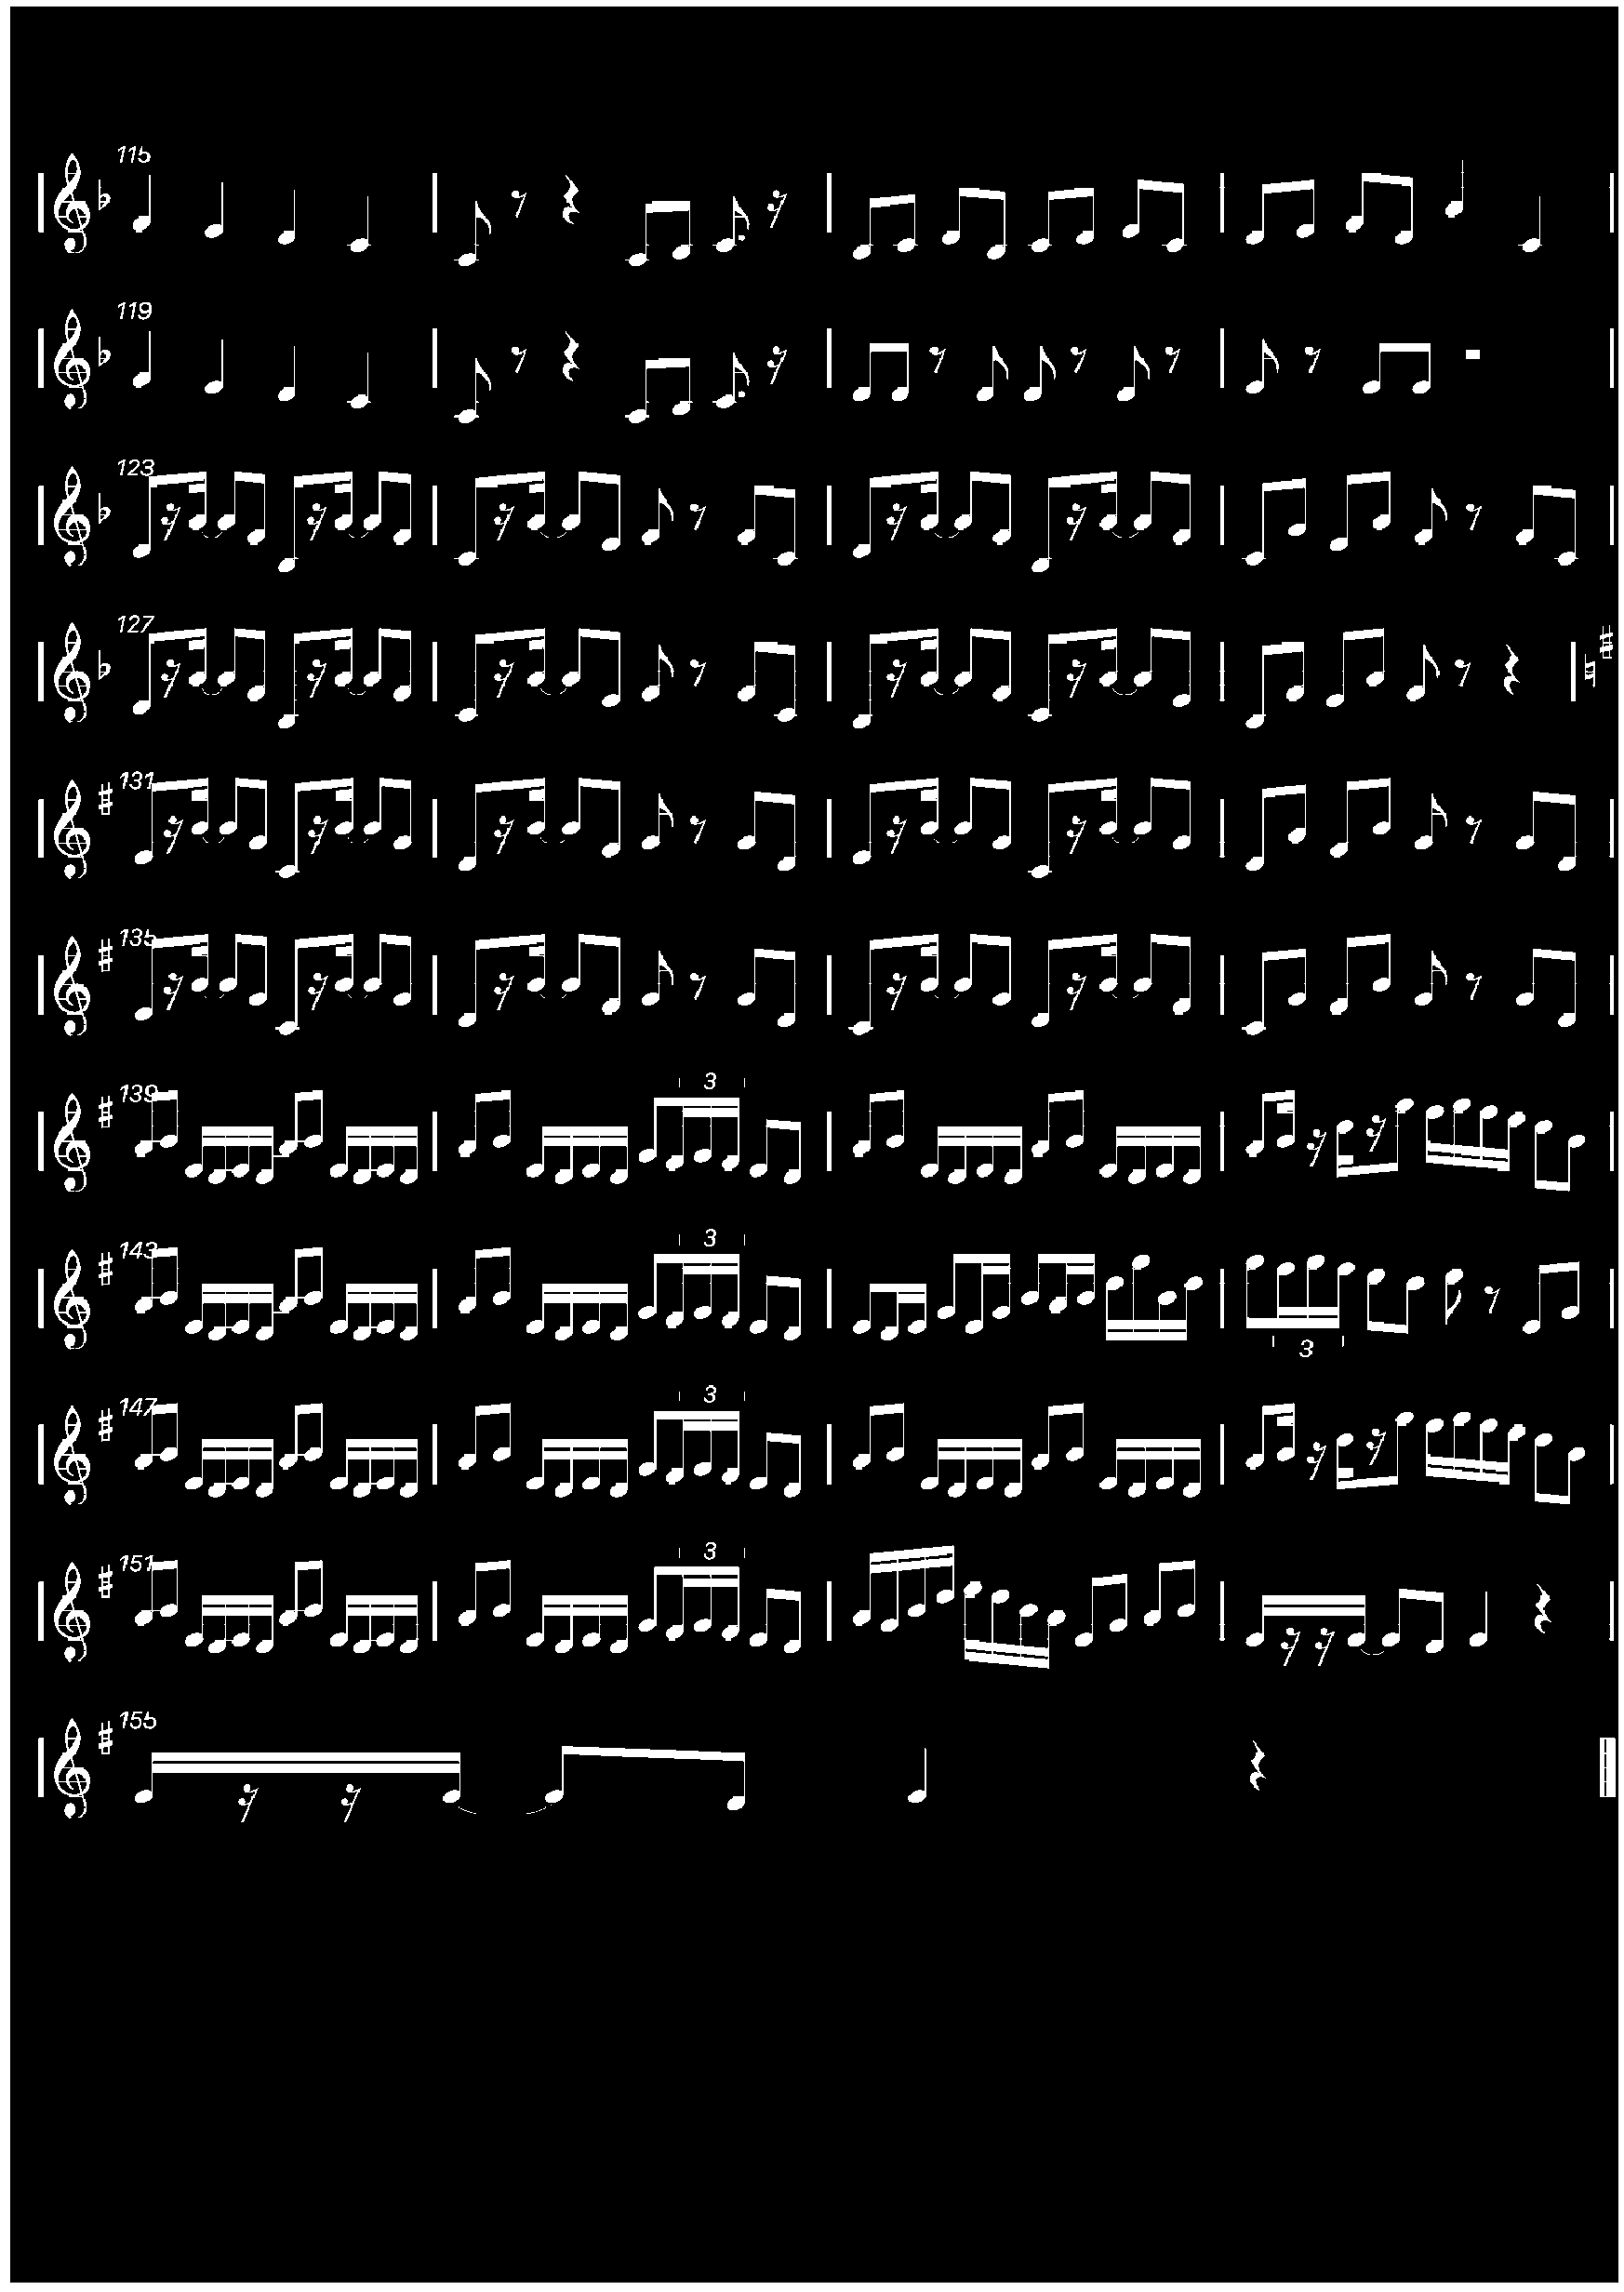

In [825]:
# turncolor_img_delete = Monochrome_Inversion(img_delete)
turncolor_img_delete = Monochrome_Inversion(img_delete)
print('画像のサイズ:',turncolor_img_delete.shape)
plt.figure(figsize=(45,45))
plt.imshow(turncolor_img_delete, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()

ラベリング実行

In [826]:
nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(turncolor_img_delete)

In [827]:
print("""ラベル数(背景自体もインデックス0に入っている)""")
print(nLabels)
print('\n')

print("""ラベル番号が入った配列データ""")
print(labelImages.shape)
print('\n')

print("""オブジェクトの外接矩形の左上のx座標、y座標、幅,高さ，　面積（pixcel）""")
print(data.shape)
print(data)
print('\n')

print("""オブジェクトの重心座標 (x, y) ※浮動小数点型で出力される""")
print(center.shape)
print(center)

ラベル数(背景自体もインデックス0に入っている)
398


ラベル番号が入った配列データ
(2339, 1653)


オブジェクトの外接矩形の左上のx座標、y座標、幅,高さ，　面積（pixcel）
(398, 5)
[[      0       0    1653    2339 3637645]
 [    111     144       8      18      58]
 [    121     144       8      18      56]
 ...
 [    540    1855       2       1       2]
 [    476    1857       3       1       3]
 [    531    1856       8       2       8]]


オブジェクトの重心座標 (x, y) ※浮動小数点型で出力される
(398, 2)
[[ 830.42809153 1174.28285031]
 [ 114.89655172  151.22413793]
 [ 125.41071429  151.08928571]
 [ 136.97590361  154.20481928]
 [  63.18056829  200.35655362]
 [1485.07581227  203.6534296 ]
 [  31.00657895  201.90131579]
 [ 436.          202.        ]
 [ 841.          202.        ]
 [1245.5         201.8699187 ]
 [1411.80293309  203.08982585]
 [1645.48979592  201.93469388]
 [ 136.66453674  215.64536741]
 [ 574.87774295  201.07210031]
 [  94.80985915  196.77464789]
 [1179.7840796   211.05870647]
 [1308.35218254  208.55753968]
 [ 211.69550173  222.7716263 ]
 [ 995.97592778  218.507

ラベリング画像を表示

In [658]:
# for idx in range(1,nLabels-1):
#     print(idx)
#     plt.imshow(img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]], cmap = "gray")
#     plt.xticks([])
#     plt.yticks([]) 
#     plt.show()

200
[951 857   4   3   5]


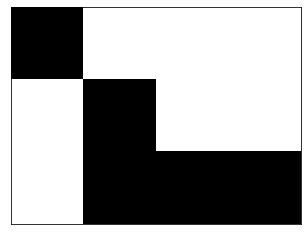

201
[968 857   5   3   5]


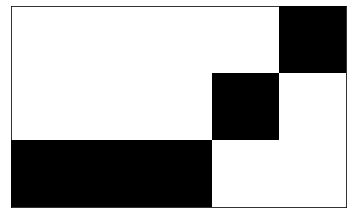

202
[1135  857    5    3    5]


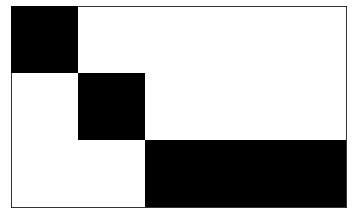

203
[350 859   2   1   2]


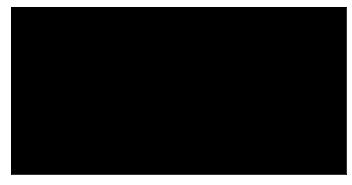

204
[363 858   2   2   3]


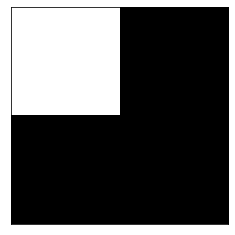

205
[1153  858    3    2    4]


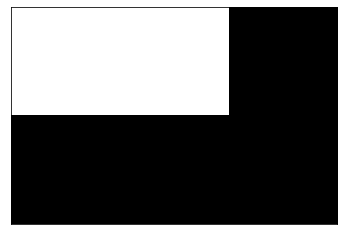

206
[ 55 882  12  16 134]


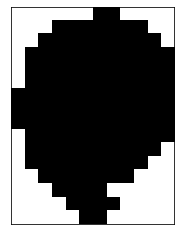

207
[113 949   8  17  56]


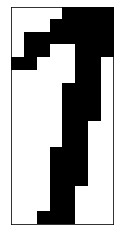

208
[122 948  14  18  93]


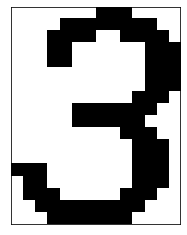

209
[ 128  949   76   94 1247]


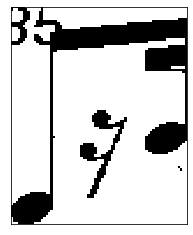

210
[215 954  49  74 863]


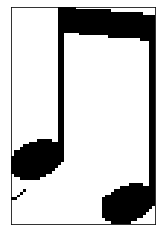

211
[ 272  954   81  104 1333]


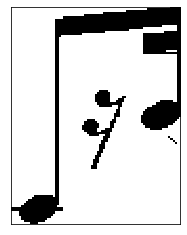

212
[363 954  50  74 768]


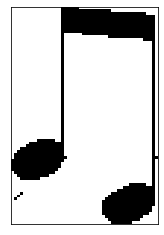

213
[ 461  954   89   96 1318]


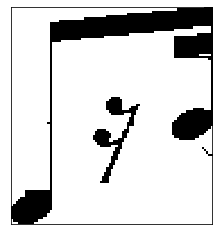

214
[ 567  954   60   83 1002]


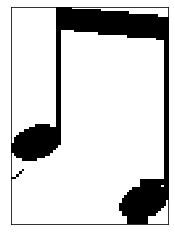

215
[ 861  954   93  104 1353]


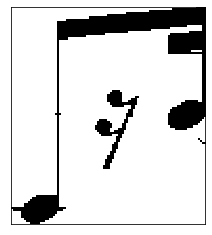

216
[970 954  59  74 955]


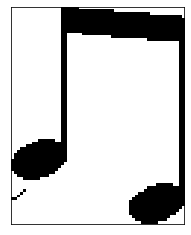

217
[1050  954   89   96 1308]


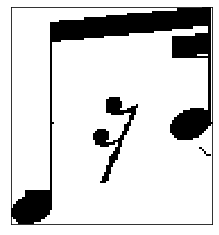

218
[1155  954   58   83  895]


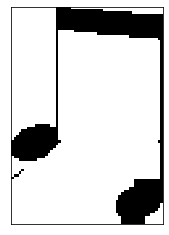

219
[1357  954   62   83  965]


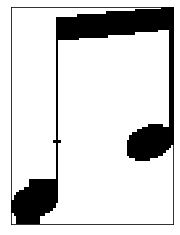

220
[  45  956   37  102 1077]


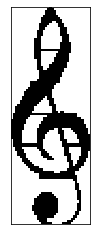

221
[ 91 959  14  34 225]


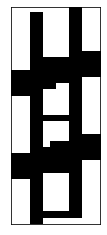

222
[748 969  60  81 885]


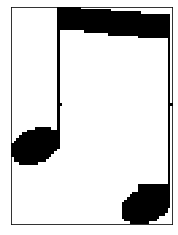

223
[1266  969   66   89  976]


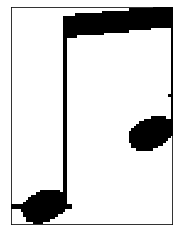

224
[1548  969   62   81  900]


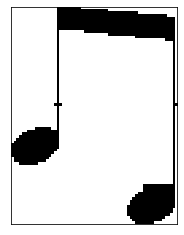

225
[649 971  33  57 383]


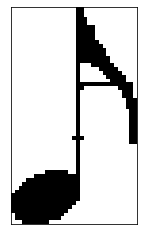

226
[1444  971   33   57  383]


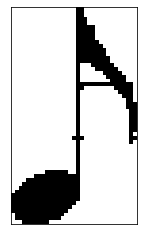

227
[ 29 976   5  61 305]


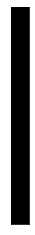

228
[434 976   5  61 305]


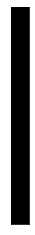

229
[839 976   5  61 305]


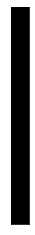

230
[1243  976    6   61  246]


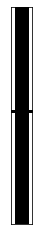

231
[1643  976    5   61  245]


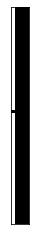

232
[158 994  20  38 199]


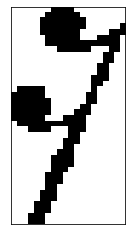

233
[306 994  21  38 194]


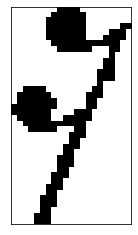

234
[497 994  21  38 196]


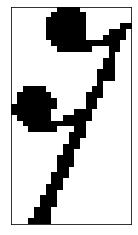

235
[699 994  16  28 127]


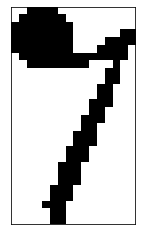

236
[901 994  21  38 197]


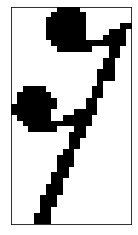

237
[1086  994   20   38  191]


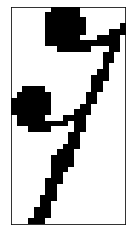

238
[1496  994   16   28  133]


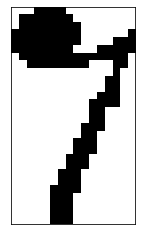

239
[ 215 1016    5    4    5]


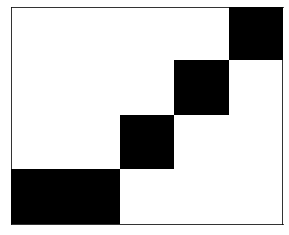

240
[ 347 1016    4    4    4]


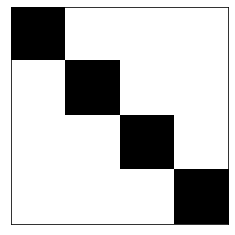

241
[ 364 1017    3    3    3]


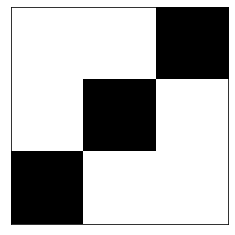

242
[ 545 1016    5    4    5]


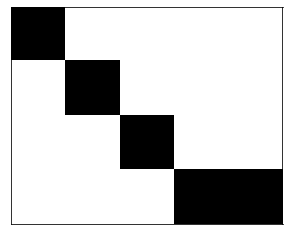

243
[ 567 1016    5    4    5]


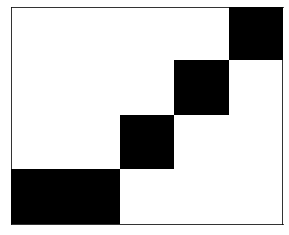

244
[ 950 1017    4    3    4]


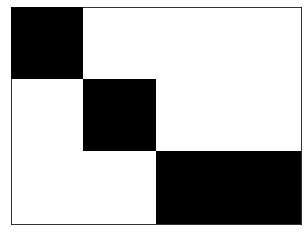

245
[ 970 1016    5    4    5]


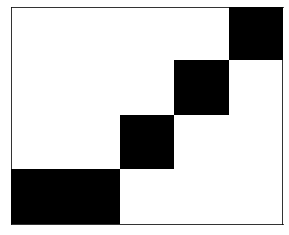

246
[1133 1016    5    4    5]


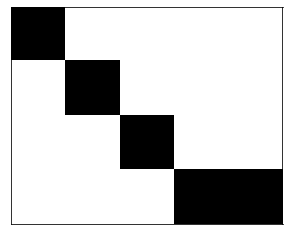

247
[1154 1016    6    4    6]


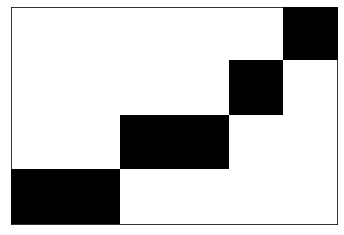

248
[ 200 1018    2    2    2]


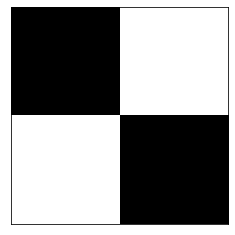

249
[  55 1043   12   16  134]


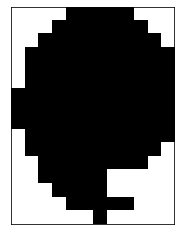

250
[ 713 1096   13   18   98]


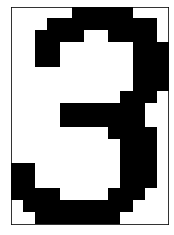

251
[ 687 1102    1   10   10]


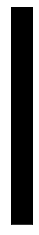

252
[ 754 1102    1   10   10]


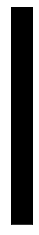

253
[ 113 1109    8   18   57]


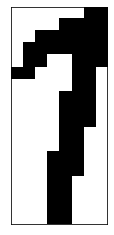

254
[ 122 1109   14   18   97]


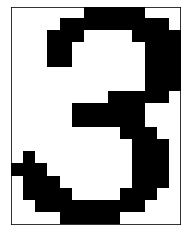

255
[ 128 1109   45   74  854]


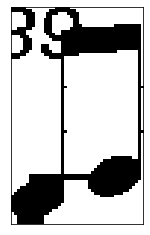

256
[ 180 1115  141   96 3164]


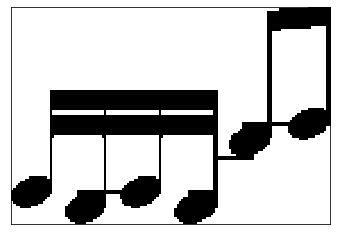

257
[ 461 1115   53   68  838]


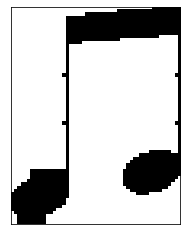

258
[ 866 1115   53   68  837]


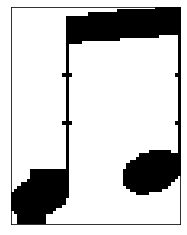

259
[1050 1115   54   68  833]


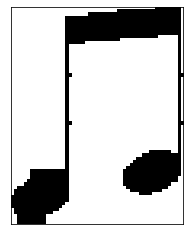

260
[1270 1115   50   68 1040]


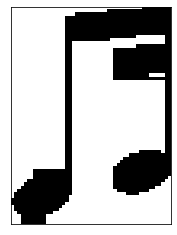

261
[  45 1117   37  102 1093]


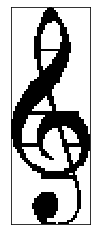

262
[  91 1120   14   34  229]


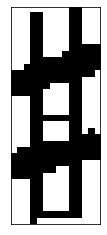

263
[ 646 1122  104   76 2436]


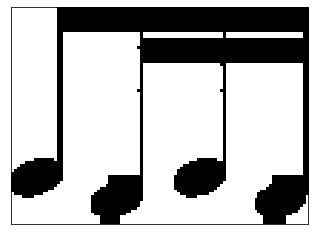

264
[1363 1123   80   81 1250]


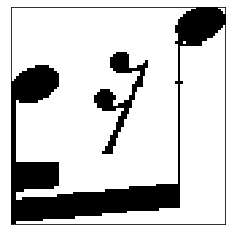

265
[1455 1123  102   75 2569]


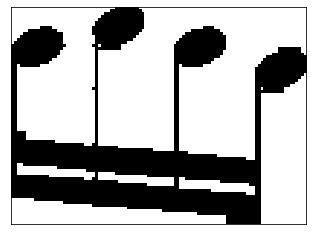

266
[  29 1137    5   61  304]


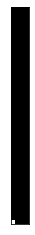

267
[ 434 1137    5   61  305]


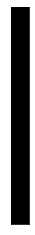

268
[ 839 1137    5   61  305]


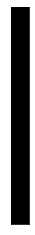

269
[1243 1137    6   61  246]


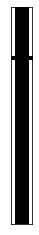

270
[1643 1137    5   61  245]


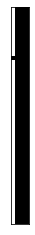

271
[1394 1140   20   38  198]


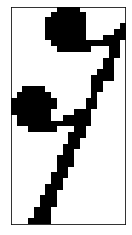

272
[ 760 1144   53   67  854]


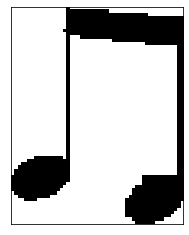

273
[1567 1145   52   74  886]


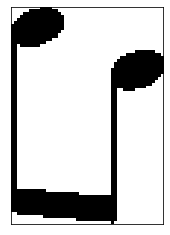

274
[ 329 1152   90   59 2315]


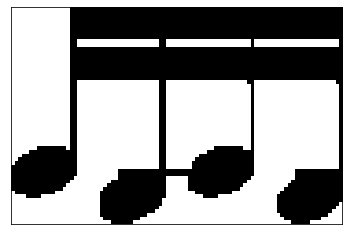

275
[ 531 1152  104   59 2551]


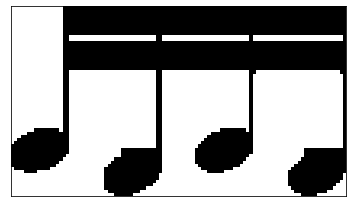

276
[ 936 1152  104   59 2544]


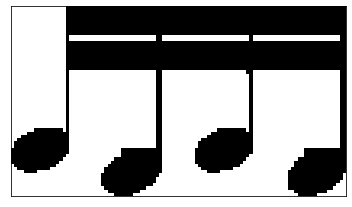

277
[1120 1152  104   59 2500]


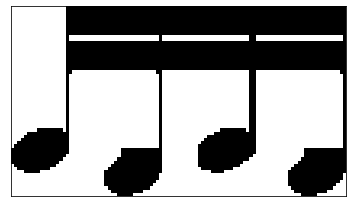

278
[1333 1155   20   38  190]


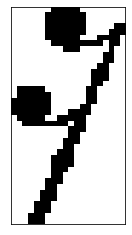

279
[  55 1204   12   15  136]


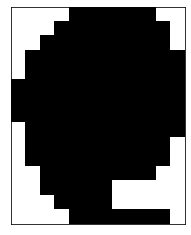

280
[ 713 1257   13   18   98]


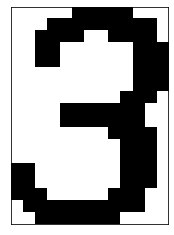

281
[ 687 1263    1   11   11]


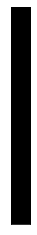

282
[ 754 1263    1   11   11]


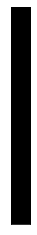

283
[ 113 1270    8   18   58]


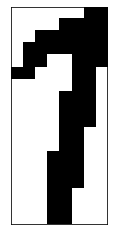

284
[ 122 1270   14   18  103]


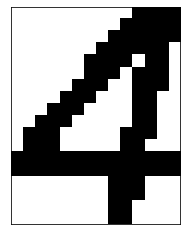

285
[ 128 1270   45   74  836]


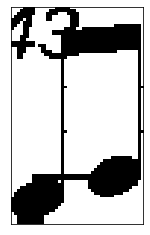

286
[ 180 1276  141   96 3166]


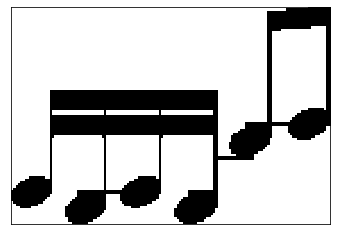

287
[ 461 1276   53   68  831]


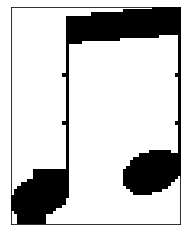

288
[  45 1278   37  102 1099]


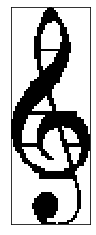

289
[  91 1281   14   34  228]


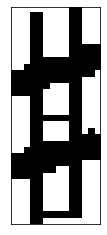

290
[ 645 1283  105   76 2442]


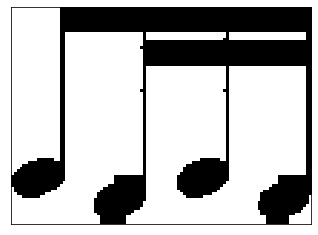

291
[ 953 1283   76   82 1624]


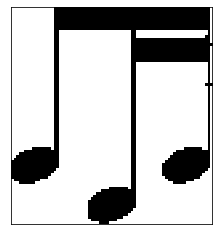

292
[1039 1283   76   61 1508]


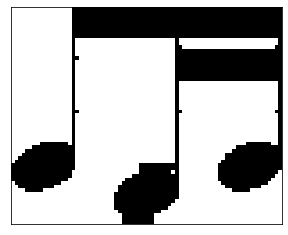

293
[1126 1284  100   88 2478]


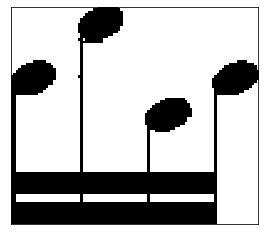

294
[1270 1284  112   75 2620]


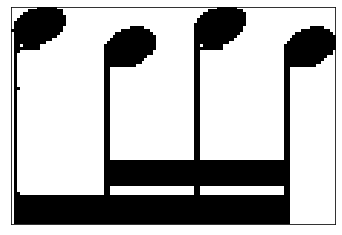

295
[1555 1290   58   75  893]


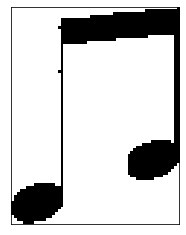

296
[  29 1298    5   61  304]


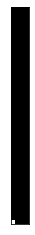

297
[ 434 1298    5   61  305]


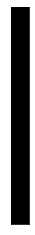

298
[ 839 1298    5   61  305]


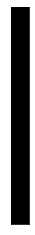

299
[1243 1298    6   61  246]


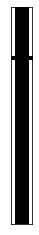

In [924]:
for idx in range(200,300):
    print(idx)
    print(data[idx])
    plt.imshow(img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]], cmap = "gray")
    plt.xticks([])
    plt.yticks([]) 
    plt.show()

## 6.記号の位置を認識
1. 音部記号,調号記号<br>
    -　テンプレートマッチング(TM)で認識する．
2. 黒符頭<br>
    -　五線譜の間隔を直径とする円を当てはめていき，どれだけ内円に黒点が存在するか調べる．<br>
3. 白符頭<br>
    -　テンプレートを当てはめていく．円の外周上に存在する黒画素の割合と，円内の白画素の割合から白符頭であるかどうかを判断する．

### 6.1音部記号,調号記号の認識

#### 6.1.1音部記号の認識

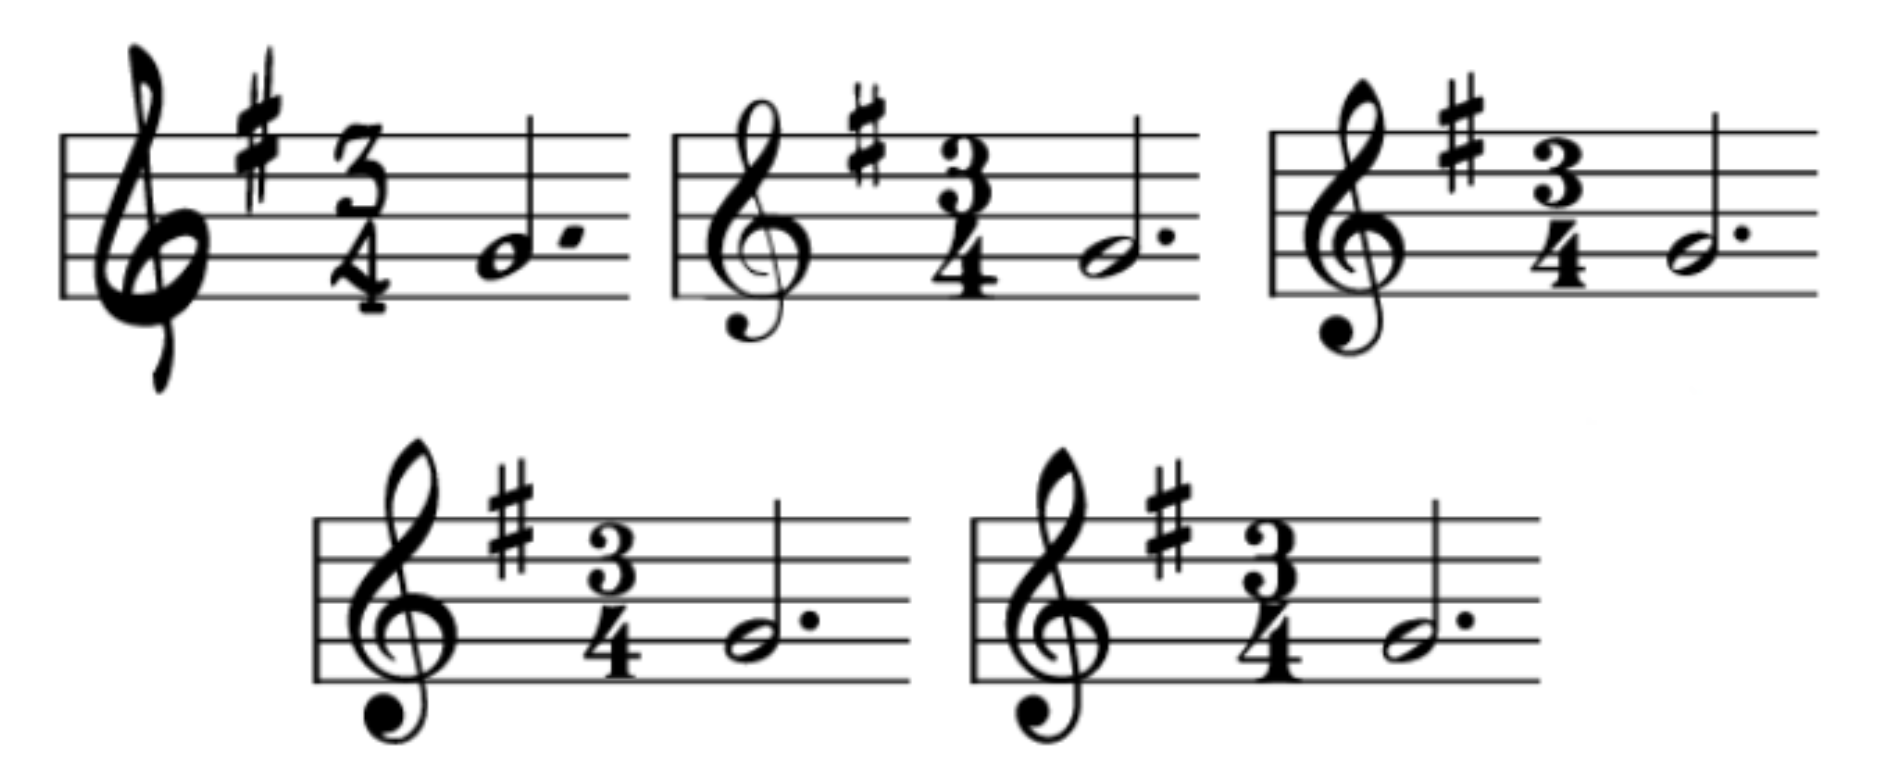

元のテンプレート読み込み

リサイズ前のサイズ (99, 35)


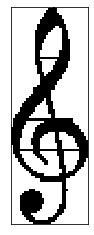

リサイズ後のサイズ：通常音部記号 (99, 32)


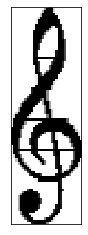

リサイズ後のサイズ：臨時音部記号 (81, 25)


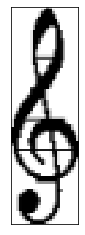

二値化後：通常音部記号


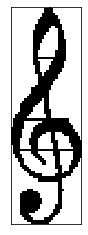

二値化後：臨時音部記号


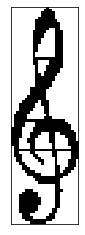

In [829]:
'''ト音記号'''
#テンプレートの読み込み
template_toonkigou = cv2.imread("./../template/template_toonkigou.png",0)
print("リサイズ前のサイズ",template_toonkigou.shape)
plt.imshow(template_toonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．
#通常のト音記号
template_toonkigou = cv2.resize(template_toonkigou , (( int(gosen_interval*2.20),int(gosen_interval*6.70))))
print("リサイズ後のサイズ：通常音部記号",template_toonkigou.shape)
plt.imshow(template_toonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()
#臨時のト音記号
template_toonkigou_rinji = cv2.resize(template_toonkigou , (( int(gosen_interval*1.70),int(gosen_interval*5.50))))
print("リサイズ後のサイズ：臨時音部記号",template_toonkigou_rinji.shape)
plt.imshow(template_toonkigou_rinji, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()


#テンプレートを二値化
# 閾値の設定
threshold = 150
print("二値化後：通常音部記号")
# 二値化(閾値150を超えた画素を255にする。)
ret, template_toonkigou = cv2.threshold(template_toonkigou , threshold, 255, cv2.THRESH_BINARY)
# template_toonkigou = Make_Binomial_Image(template_toonkigou)
plt.imshow(template_toonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()


print("二値化後：臨時音部記号")
# 閾値の設定
threshold = 150
# 二値化(閾値150を超えた画素を255にする。)
ret, template_toonkigou_rinji  = cv2.threshold(template_toonkigou_rinji , threshold, 255, cv2.THRESH_BINARY)
# template_toonkigou_rinji = Make_Binomial_Image(template_toonkigou_rinji)
plt.imshow(template_toonkigou_rinji, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

リサイズ前のサイズ (44, 30)


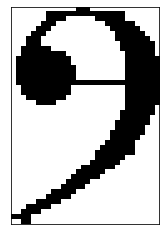

リサイズ後のサイズ：通常音部記号 (41, 26)


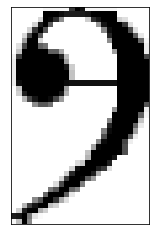

リサイズ後のサイズ：臨時音部記号 (32, 19)


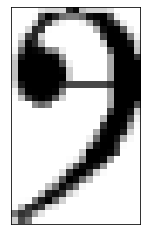

100%|██████████| 41/41 [00:00<00:00, 14904.36it/s]

二値化後：通常音部記号
閾値： 1
クラス間分散の最適値： 14381.587460267732


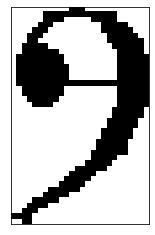

二値化後：臨時音部記号


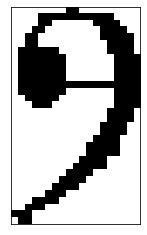

In [830]:
'''へ音記号'''
#テンプレートの読み込み
template_heonkigou = cv2.imread("./../template/template_heonkigou.png",0)
print("リサイズ前のサイズ",template_heonkigou.shape)
plt.imshow(template_heonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．
#通常のト音記号
template_heonkigou = cv2.resize(template_heonkigou , (( int(gosen_interval*1.8),int(gosen_interval*2.8))))
print("リサイズ後のサイズ：通常音部記号",template_heonkigou.shape)
plt.imshow(template_heonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()
#臨時のト音記号
template_heonkigou_rinji = cv2.resize(template_heonkigou , (( int(gosen_interval*1.30),int(gosen_interval*2.20))))
print("リサイズ後のサイズ：臨時音部記号",template_heonkigou_rinji.shape)
plt.imshow(template_heonkigou_rinji, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
print("二値化後：通常音部記号")
# 閾値の設定
threshold = 150
# 二値化(閾値150を超えた画素を255にする。)
ret, template_heonkigou  = cv2.threshold(template_heonkigou , threshold, 255, cv2.THRESH_BINARY)
template_heonkigou = Make_Binomial_Image(template_heonkigou)
plt.imshow(template_heonkigou, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

print("二値化後：臨時音部記号")
# 閾値の設定
threshold = 150
# 二値化(閾値150を超えた画素を255にする。)
ret, template_heonkigou_rinji  = cv2.threshold(template_heonkigou_rinji , threshold, 255, cv2.THRESH_BINARY)
# template_heonkigou_rinji = Make_Binomial_Image(template_heonkigou_rinji)
plt.imshow(template_heonkigou_rinji, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

100%|██████████| 32/32 [00:00<00:00, 18348.29it/s]

toon (99, 32)


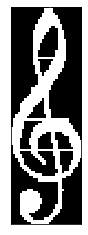

toon_rinji (81, 25)


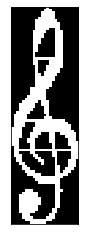

heon (41, 26)


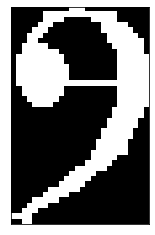

heon_rinji (32, 19)


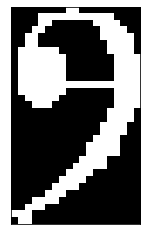

In [831]:
#音部記号のテンプレートをまとめる
template_onbu = {'toon':template_toonkigou, 'toon_rinji':template_toonkigou_rinji \
                , 'heon':template_heonkigou, 'heon_rinji':template_heonkigou_rinji}

turncolor_template_onbu = {'toon':Monochrome_Inversion(template_toonkigou) \
                           ,'toon_rinji':Monochrome_Inversion(template_toonkigou_rinji) \
                           ,'heon':Monochrome_Inversion(template_heonkigou) \
                           ,'heon_rinji':Monochrome_Inversion(template_heonkigou_rinji)}

for temp_name,temp in  turncolor_template_onbu.items():
    print(temp_name,temp.shape)
    plt.imshow(temp, cmap = "gray")
    plt.xticks([]), plt.yticks([])
    plt.show()

[  45  956   37  102 1077]


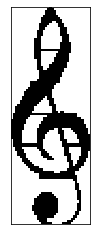

In [925]:
idx=220
print(data[idx])
plt.imshow(img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]], cmap = "gray")
plt.xticks([])
plt.yticks([]) 
plt.show()

メイン処理

In [926]:
def Detect_Clef(turncolor_img_delete,data,turncolor_template,threshold_toon = 0.70,threshold_heon = 0.70):
    """
    音部記号，臨時音部記号をテンプレートマッチング(TM)
    どれか一つのTMで閾値(0.80ぐらい)以上だった場合に抽出を実行
    
    入力：反転五線消去画像，ラベリングの座標情報,反転テンプレート画像
    出力：検出した記号名と座標
    """
    num_labelling_img = data.shape[0]#ラベリング画像の数
#     threshold = 0.70
    result = []
    for temp_name,temp in  turncolor_template.items():
        h_temp,w_temp = temp.shape
        
        for idx in tqdm(range(1,num_labelling_img - 1)):
            labeling_img  = turncolor_img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]]
            h_labeling_img,w_labeling_img = labeling_img.shape
            flag = False
            #ラベリング画像の幅高がテンプレート画像の幅高以上の場合TMを実行
            if h_labeling_img >= h_temp and  w_labeling_img >= w_temp:
                res = cv2.matchTemplate(labeling_img, temp, cv2.TM_CCORR_NORMED)
                if temp_name=='toon' or temp_name=='toon_rinji':
                    if np.any(np.where(res>threshold_toon,True,False))==True:#どれか一つでも閾値thresholdを超えたら検出
                        flag = True
                elif temp_name=='heon' or temp_name=='heon_rinji':
                    if np.any(np.where(res>threshold_heon,True,False))==True:#どれか一つでも閾値thresholdを超えたら検出
                        flag = True
            
                if flag==True:
                    t = data[idx,:].copy()
                    t = np.delete(t,-1)#面積を要素から削除
                    #ト音記号:0,ヘ音記号:1をつける
                    if temp_name=='toon' or temp_name=='toon_rinji':
                        t = np.append(t,0)
                    elif temp_name=='heon' or temp_name=='heon_rinji':
                        t = np.append(t,1)
                    result.append(t)
    return result

In [931]:
info_clef = Detect_Clef(turncolor_img_delete,data,turncolor_template_onbu\
                        ,threshold_toon = 0.64,threshold_heon = 0.80)
print(len(info_clef))
print(info_clef)

100%|██████████| 396/396 [00:00<00:00, 21655.92it/s]

11
[array([ 45, 152,  37, 102,   0]), array([ 45, 312,  37, 102,   0]), array([ 45, 473,  37, 102,   0]), array([ 45, 634,  37, 102,   0]), array([ 45, 795,  37, 102,   0]), array([ 45, 956,  37, 102,   0]), array([  45, 1117,   37,  102,    0]), array([  45, 1278,   37,  102,    0]), array([  45, 1439,   37,  101,    0]), array([  45, 1599,   37,  102,    0]), array([  45, 1760,   37,  102,    0])]


検出結果を楽譜上に表示

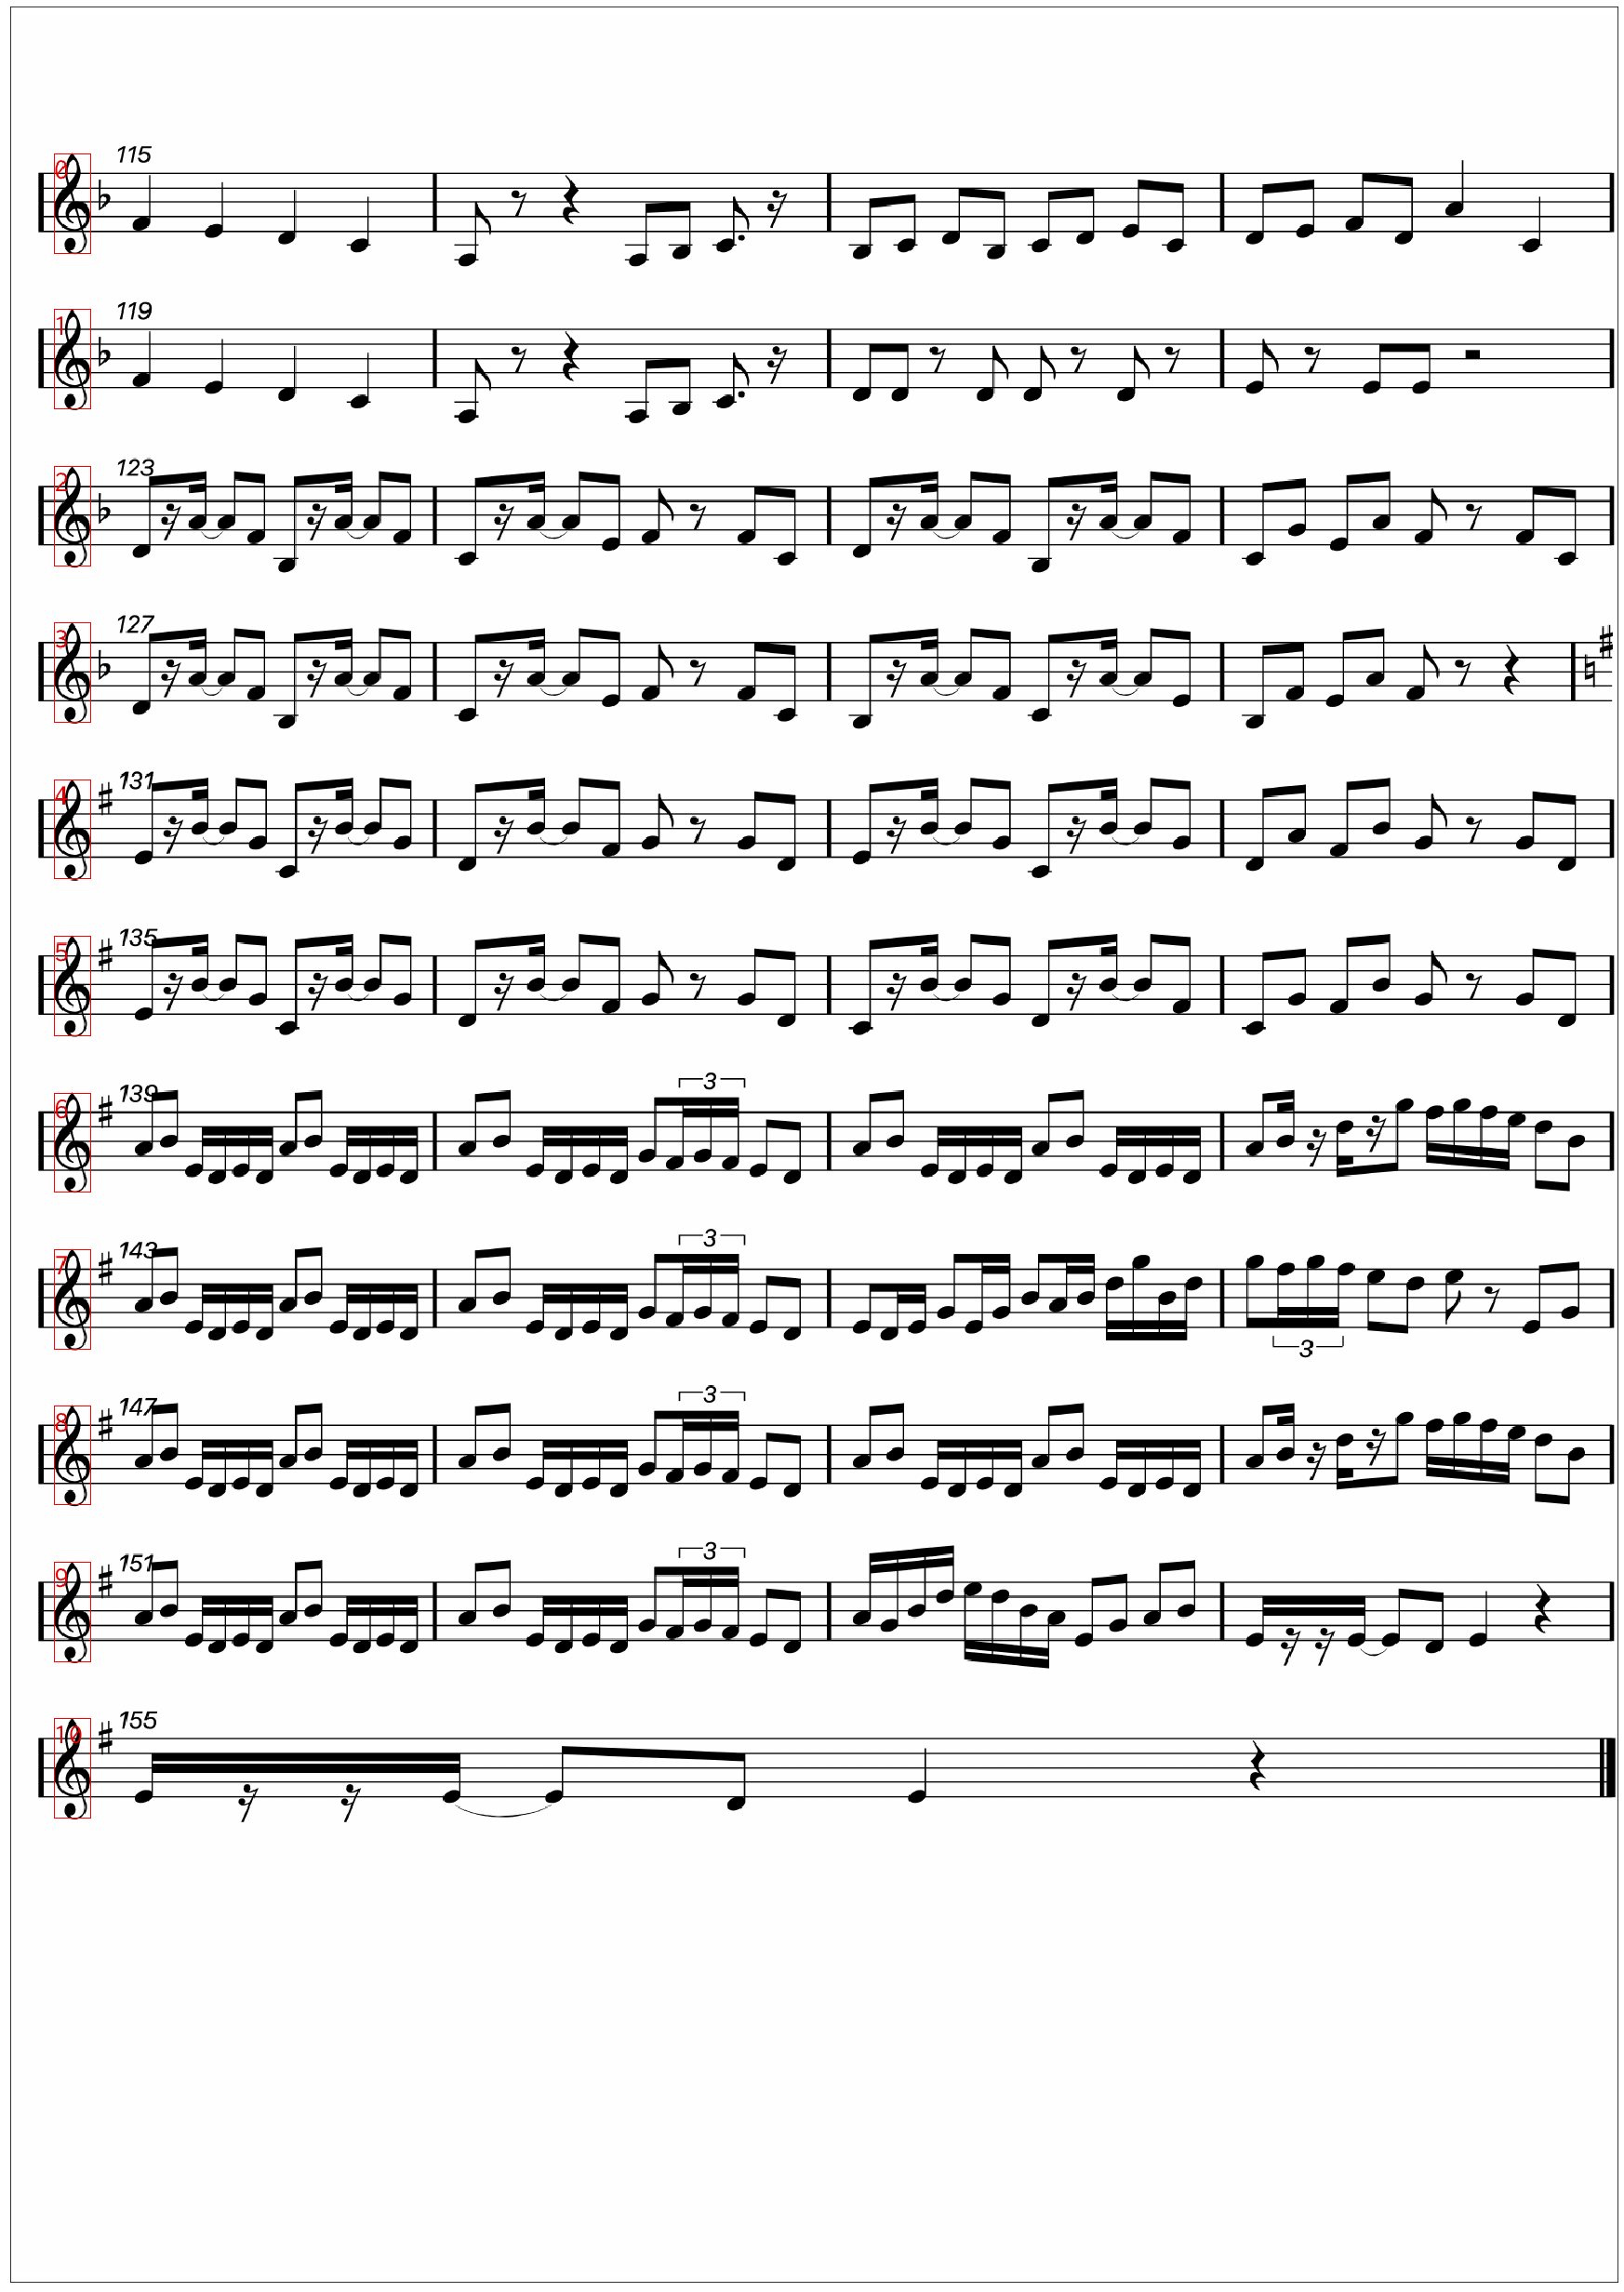

In [932]:
from PIL import Image, ImageDraw
img_draw = Image.fromarray(img_origin) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意
font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
font_size = 30       # フォントサイズ
fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義
for idx,a in enumerate(info_clef):
    draw.rectangle([(a[0], a[1]), (a[0]+a[2], a[1]+a[3])] , outline='red',  width=1)
    draw.text((a[0],  a[1]),'{0}'.format(idx), font=fnt,fill=222)
img_draw.show()
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

五線idの情報を付加

In [933]:
def Add_Gosenid(info_something,searchline):
    result = []
    for i,x in enumerate(info_something):
        for gosen_idx,gosen in enumerate(searchline):#探索線を広げすぎると五線範囲重なるのでうまくいかない．
            if x[1]>=gosen[0] and x[1]<=gosen[-1]:
                res = x
                res = np.append(res,gosen_idx)
                result.append(res)
                break
    return result

In [934]:
info_clef_addid = Add_Gosenid(info_clef,searchline)
print(len(info_clef_addid))
print(info_clef_addid )

11
[array([ 45, 152,  37, 102,   0,   0]), array([ 45, 312,  37, 102,   0,   1]), array([ 45, 473,  37, 102,   0,   2]), array([ 45, 634,  37, 102,   0,   3]), array([ 45, 795,  37, 102,   0,   4]), array([ 45, 956,  37, 102,   0,   5]), array([  45, 1117,   37,  102,    0,    6]), array([  45, 1278,   37,  102,    0,    7]), array([  45, 1439,   37,  101,    0,    8]), array([  45, 1599,   37,  102,    0,    9]), array([  45, 1760,   37,  102,    0,   10])]


#### 6.1.2 調号記号の検出

リサイズ前のサイズ (43, 9)


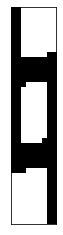

リサイズ後のサイズ (43, 9)


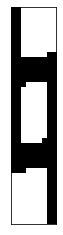

二値化後のサイズ (43, 9)


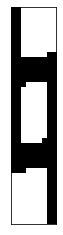

In [935]:
'''ナチュラル'''
#ナチュラルのシェイプ (43, 9)
#縦/横 4.777777777777778

#テンプレートの読み込み
template_natural = cv2.imread("./../template/template_natural.png",0)
print("リサイズ前のサイズ",template_natural.shape)
plt.imshow(template_natural, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_natural = cv2.resize(template_natural , (( int(gosen_interval*0.620),int(gosen_interval*2.94))))
print("リサイズ後のサイズ",template_natural.shape)
plt.imshow(template_natural, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値150を超えた画素を255にする。)
ret, template_natural = cv2.threshold(template_natural, threshold, 255, cv2.THRESH_BINARY)
# template_natural = Make_Binomial_Image(template_natural)
print("二値化後のサイズ",template_natural.shape)
plt.imshow(template_natural, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

リサイズ前のサイズ (41, 15)


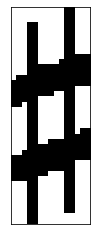

リサイズ後のサイズ (31, 10)


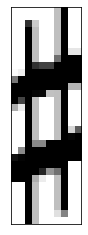

二値化後のサイズ (31, 10)


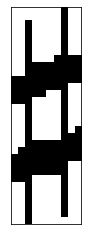

In [936]:
'''シャープ'''
#シャープのシェイプ (41, 15)
#縦/横 2.7333333333333334

#テンプレートの読み込み
template_sharp = cv2.imread("./../template/template_sharp.png",0)
print("リサイズ前のサイズ",template_sharp.shape)
plt.imshow(template_sharp, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_sharp = cv2.resize(template_sharp , (( int(gosen_interval*0.70),int(gosen_interval*2.10))))
print("リサイズ後のサイズ",template_sharp.shape)
plt.imshow(template_sharp, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値100を超えた画素を255にする。)
ret, template_sharp = cv2.threshold(template_sharp, threshold, 255, cv2.THRESH_BINARY)
# template_sharp = Make_Binomial_Image(template_sharp)
print("二値化後のサイズ",template_sharp.shape)
plt.imshow(template_sharp, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

リサイズ前のサイズ (35, 12)


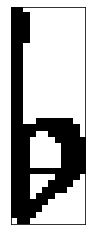

リサイズ後のサイズ (29, 9)


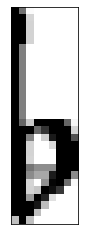

二値化後のサイズ (29, 9)


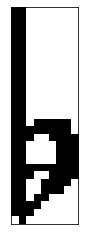

In [937]:
'''フラット'''
#フラットのシェイプ (35, 12)
#縦/横 2.9166666666666665

#テンプレートの読み込み
template_flat = cv2.imread("./../template/template_flat.png",0)
print("リサイズ前のサイズ",template_flat.shape)
plt.imshow(template_flat, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_flat = cv2.resize(template_flat , (( int(gosen_interval*0.65),int(gosen_interval*2.00))))
print("リサイズ後のサイズ",template_flat.shape)
plt.imshow(template_flat, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値150を超えた画素を255にする。)
ret, template_flat = cv2.threshold(template_flat, threshold, 255, cv2.THRESH_BINARY)
# template_flat = Make_Binomial_Image(template_flat)
print("二値化後のサイズ",template_flat.shape)
plt.imshow(template_flat, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

100%|██████████| 29/29 [00:00<00:00, 35753.91it/s]

natural (43, 9)


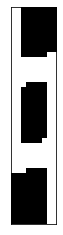

sharp (31, 10)


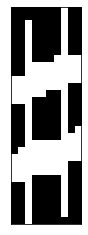

flat (29, 9)


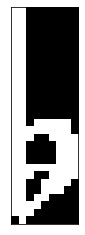

In [938]:
#調号記号のテンプレートをまとめる．
template_key = {'natural':template_natural,'sharp':template_sharp, 'flat':template_flat}
turncolor_template_key = {'natural':Monochrome_Inversion(template_natural),\
                          'sharp':Monochrome_Inversion(template_sharp),\
                          'flat':Monochrome_Inversion(template_flat)}
for temp_name,temp in  turncolor_template_key.items():
    print(temp_name,temp.shape)
    plt.imshow(temp, cmap = "gray")
    plt.xticks([]), plt.yticks([])
    plt.show()

In [939]:
# idx = 457
# print(data[idx])
# plt.imshow(img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]], cmap = "gray")
# plt.xticks([])
# plt.yticks([]) 
# plt.show()

In [940]:
len(turncolor_template_key)

3

メイン処理

In [941]:
def Detect_Key(turncolor_img_delete,data,turncolor_template,natural_thr,sharp_thr,flat_thr):
    """
    調号記号，臨時調号記号をTM
    1.閾値を超える箇所を認識
    2.x座標が近いものは外し，スコアが高いところだけ抽出
    3. 検出した位置を保存(ラベリング画像の位置ではない)
    
    入力：反転五線消去画像，ラベリングの座標情報,テンプレート画像，閾値
    出力:検出した記号名と座標
    出力形式は，[x,y,幅，高さ,記号名]，記号名は，♮:0,♯:1,♭:-1とする．
    """
    result = []
    num_labelling_img = data.shape[0]#ラベリング画像の数
    
    for temp_name,temp in  tqdm(turncolor_template.items()):
        h_temp,w_temp = temp.shape
#         print('------------{0}-------------'.format(temp_name))
        
        for idx in range(1,num_labelling_img - 1):
            labeling_img  = turncolor_img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]]
            h_labeling_img,w_labeling_img  = labeling_img.shape
            
            #ラベリング画像がテンプレートより大きい場合TMを実行
            if h_labeling_img >= h_temp and  w_labeling_img >= w_temp:
                res = cv2.matchTemplate(labeling_img, temp, cv2.TM_CCORR_NORMED)
                #閾値を超える箇所を検出
                    #ナチュラルとシャープは混同しやすい．
                    #ナチュラルの閾値を下げすぎるとシャープを検出してしまうので，ナチュラルの閾値は高めに設定
                if temp_name=='natural':
                    locs = np.column_stack(np.where(res >= natural_thr))#ラベリング画像内の座標
                elif temp_name=='sharp':
                    locs = np.column_stack(np.where(res >= sharp_thr))
                elif temp_name=='flat':
                    locs = np.column_stack(np.where(res >= flat_thr))
                
                #x座標，y座標が近いもの(付近±3くらい)は削除
                if len(locs)!=0:
                    #x座標でソート
                    locs = locs[np.argsort(locs[:,1],axis=0)]#x座標の昇順に従って配列を並び替える
                    i=0
                    while not (locs[-1] == locs[i]).all():
                        difx = np.abs(locs[i+1,1] - locs[i,1])
                        dify = np.abs(locs[i+1,0] - locs[i,0])
                        if difx <= 5 and dify <= 5:
                            locs = np.delete(locs,obj=i,axis=0)
                            i -= 1
                        i += 1
                    #y座標でソート
                    locs = locs[np.argsort(locs[:,0],axis=0)]#x座標の昇順に従って配列を並び替える
                    i=0
                    while not (locs[-1] == locs[i]).all():
                        difx = np.abs(locs[i+1,1] - locs[i,1])
                        dify = np.abs(locs[i+1,0] - locs[i,0])
                        if difx <= 5 and dify <= 5:
                            locs = np.delete(locs,obj=i,axis=0)
                            i -= 1
                        i += 1
                    
                #検出した位置も保存
                    ##locsはラベリング画像内の座標なので，全体画像内の座標にする必要がある．
                    locs = locs[:,[1,0]]#xとyの位置を入れ替える
                    locs[:,0]  += int(data[idx,0])#x
                    locs[:,1]  += int(data[idx,1])#y
                    for loc in locs:
                        loc = np.append(loc,w_temp)
                        loc = np.append(loc,h_temp)
                        if temp_name=='natural':
                            loc = np.append(loc,0)
                            result.append(loc)
                        elif temp_name=='sharp':
                            loc = np.append(loc,1)
                            result.append(loc)
                        elif temp_name=='flat':
                            loc = np.append(loc,-1)
                            result.append(loc)
    #らんべリング画像の探索で生じる重複問題を解決．
    #二つずつ取り出して比較
    result = np.array(result)
    print(result)
    res = []
    if len(result)!=0:
        for i in [-1,0,1]:
            del_list = []
            res_key_each = result[result[:,-1]==i].copy()
            idx_list = np.arange(len(res_key_each))
            if len(idx_list)!=0:
                for idx in itertools.combinations(idx_list, 2):
#                 print(idx[0],idx[1])x
                    difx = np.abs(res_key_each[idx[0],1] - res_key_each[idx[1],1])
                    dify = np.abs(res_key_each[idx[0],0] - res_key_each[idx[1],0])
                    if difx <= 5 and dify <= 5:
                        del_list.append(idx[0])
                res_key_each = np.delete(res_key_each,obj=del_list,axis=0)
                for r in res_key_each.tolist():
                    res.append(r)
            
    result = np.array(res)
    
    return result

In [942]:
info_key = Detect_Key(turncolor_img_delete,data,turncolor_template_key\
                      ,natural_thr=0.90,sharp_thr=0.760,flat_thr=0.836)
print(len(info_key))
print(type(info_key))
print(info_key)

100%|██████████| 3/3 [00:00<00:00, 51.87it/s]

[[  93  799   10   31    1]
 [  93  960   10   31    1]
 [  93 1121   10   31    1]
 [  93 1282   10   31    1]
 [  93 1443   10   31    1]
 [  93 1603   10   31    1]
 [  93 1764   10   31    1]
 [  91  180    9   29   -1]
 [  91  341    9   29   -1]
 [  91  502    9   29   -1]
 [  91  663    9   29   -1]
 [1363 1166    9   29   -1]
 [1511 1158    9   29   -1]
 [1363 1488    9   29   -1]
 [1009 1667    9   29   -1]]
15
<class 'numpy.ndarray'>
[[  91  180    9   29   -1]
 [  91  341    9   29   -1]
 [  91  502    9   29   -1]
 [  91  663    9   29   -1]
 [1363 1166    9   29   -1]
 [1511 1158    9   29   -1]
 [1363 1488    9   29   -1]
 [1009 1667    9   29   -1]
 [  93  799   10   31    1]
 [  93  960   10   31    1]
 [  93 1121   10   31    1]
 [  93 1282   10   31    1]
 [  93 1443   10   31    1]
 [  93 1603   10   31    1]
 [  93 1764   10   31    1]]


In [943]:
#調号記号の検出結果
for idx,a in enumerate(info_key):
    print(idx,a)
#     plt.imshow(img_delete[a[1]:a[1]+a[3],a[0]:a[0]+a[2]], cmap = "gray")
#     plt.xticks([]), plt.yticks([])
#     plt.show()

0 [ 91 180   9  29  -1]
1 [ 91 341   9  29  -1]
2 [ 91 502   9  29  -1]
3 [ 91 663   9  29  -1]
4 [1363 1166    9   29   -1]
5 [1511 1158    9   29   -1]
6 [1363 1488    9   29   -1]
7 [1009 1667    9   29   -1]
8 [ 93 799  10  31   1]
9 [ 93 960  10  31   1]
10 [  93 1121   10   31    1]
11 [  93 1282   10   31    1]
12 [  93 1443   10   31    1]
13 [  93 1603   10   31    1]
14 [  93 1764   10   31    1]


15


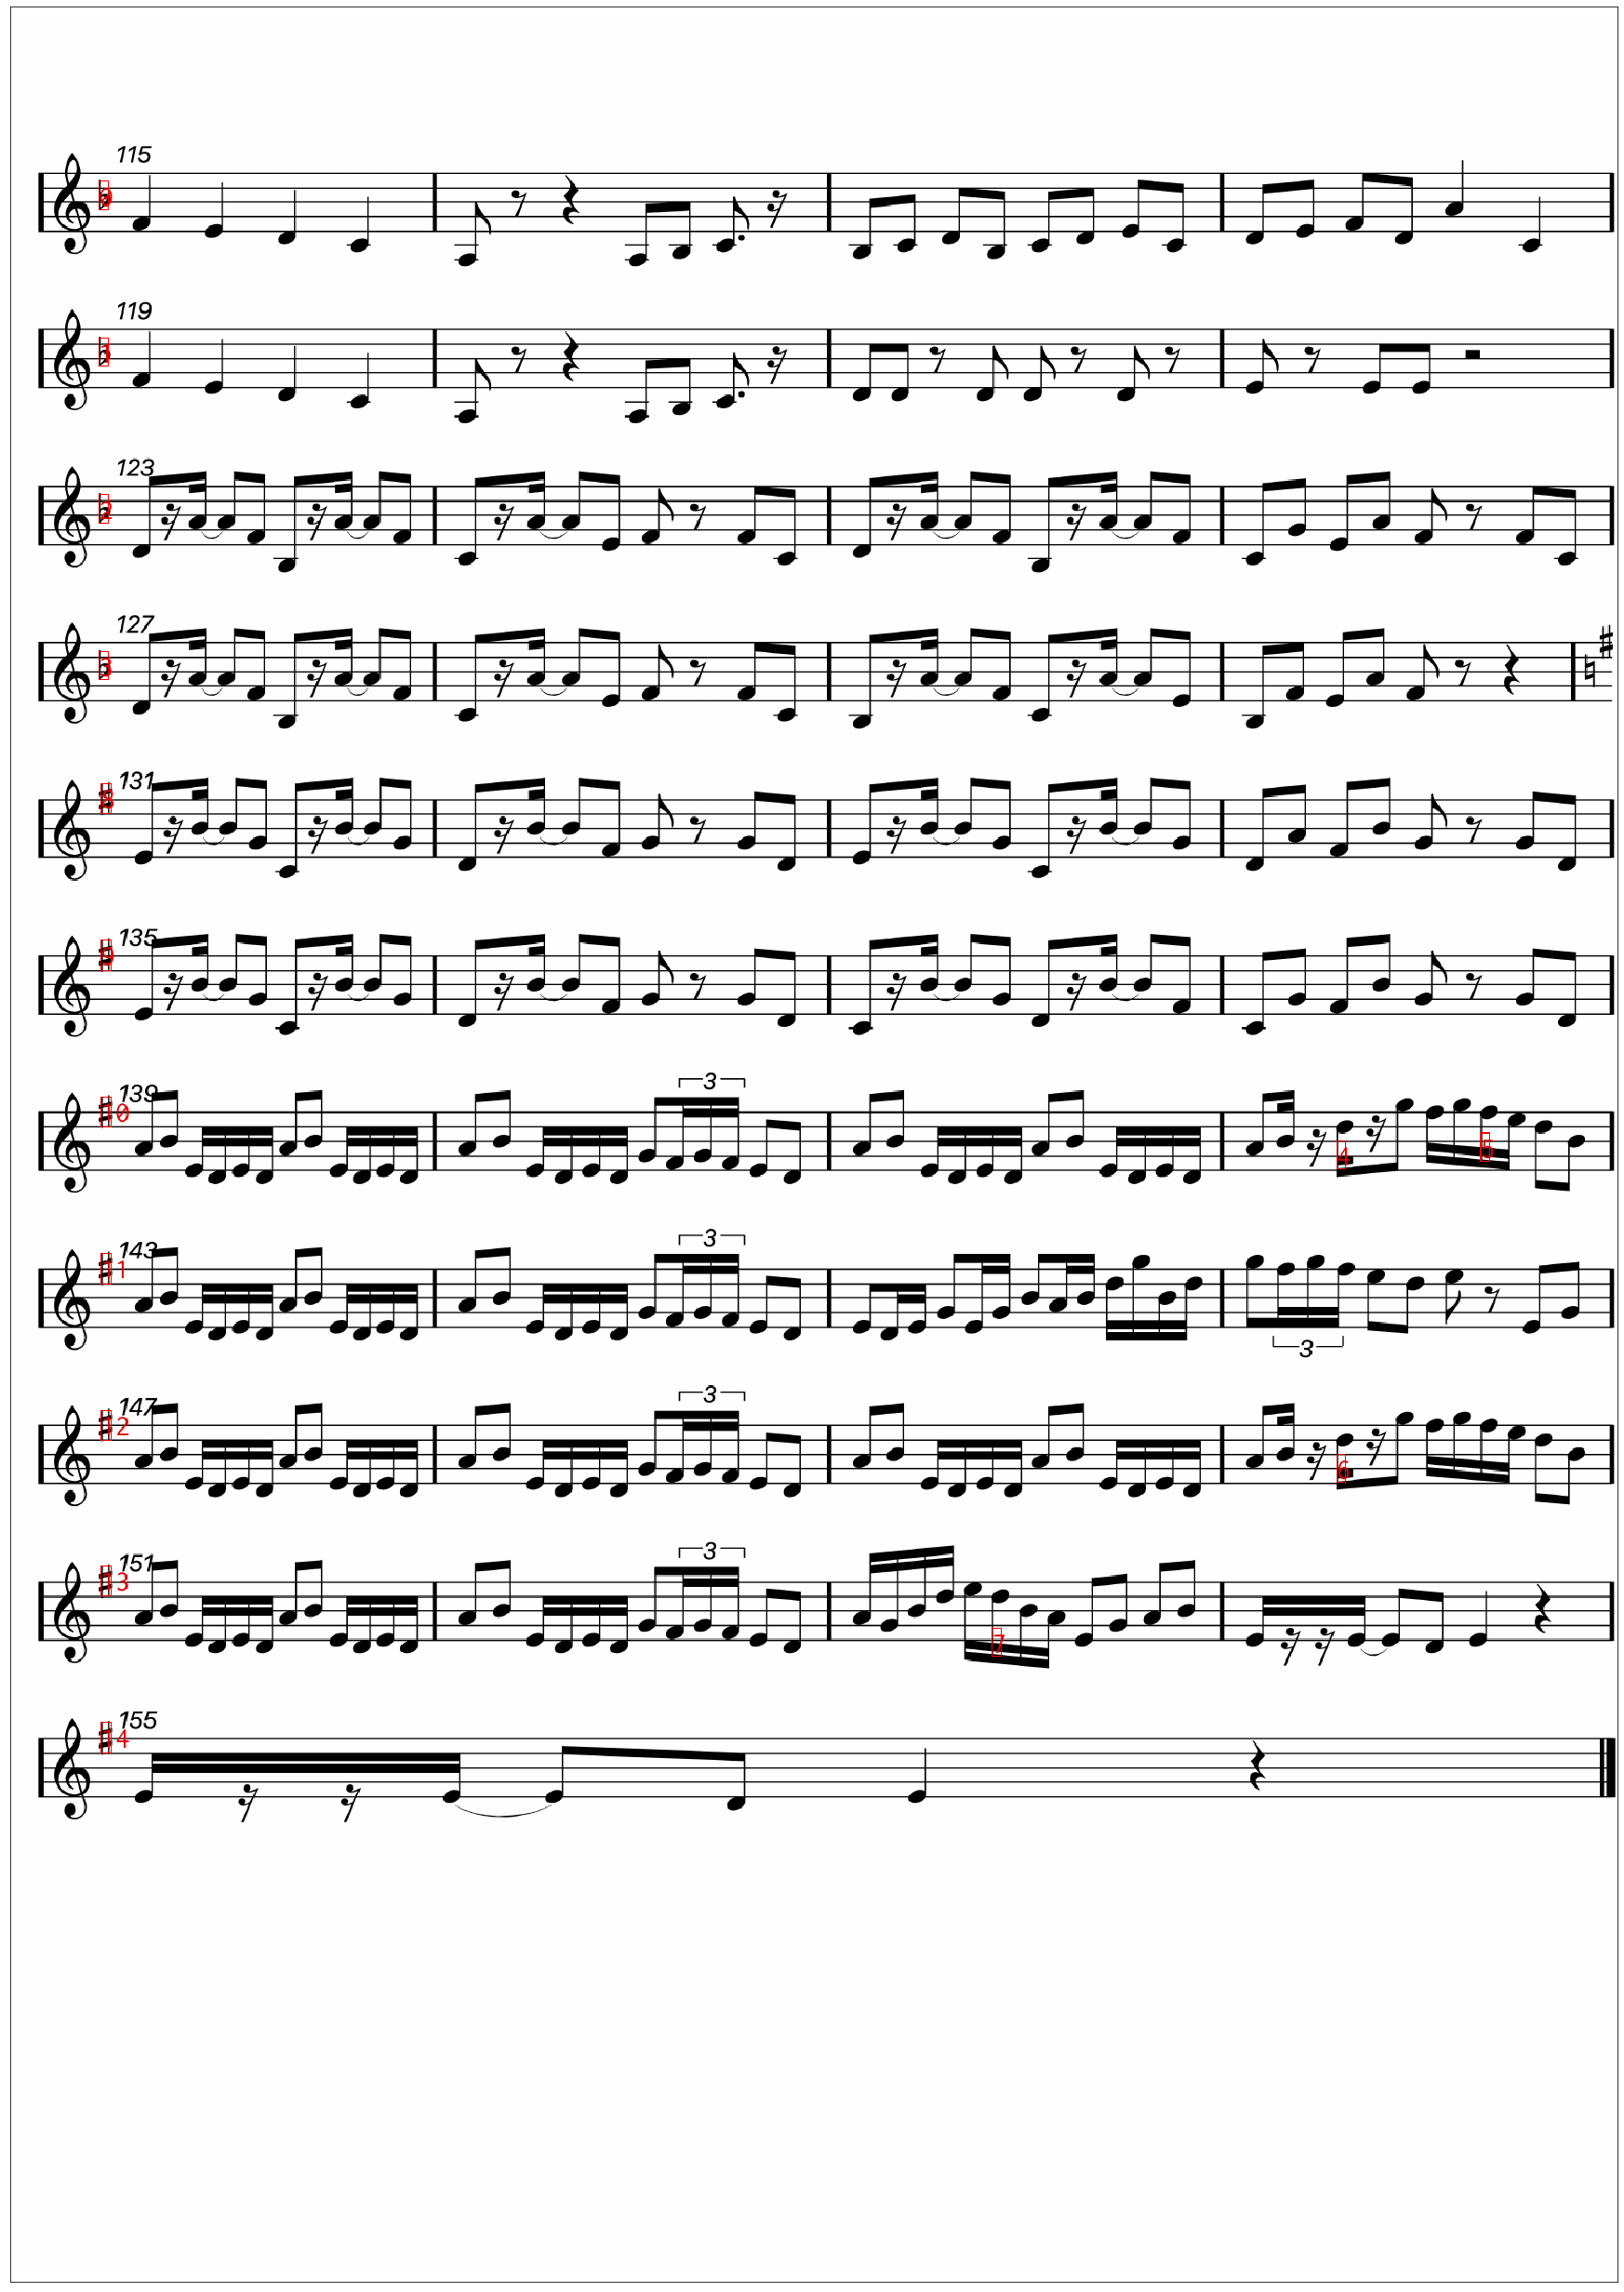

In [944]:
from PIL import Image, ImageDraw
img_draw = Image.fromarray(img_origin) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意
font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
font_size = 30       # フォントサイズ
fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義
print(len(info_key))
for idx,a in enumerate(info_key):
    draw.rectangle([(a[0], a[1]), (a[0]+a[2], a[1]+a[3])] , outline='red',  width=1)
    draw.text((a[0],  a[1]),'{0}'.format(idx), font=fnt,fill=222)
    
img_draw.show()
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

五線idの情報を付加

In [945]:
info_key_addid = Add_Gosenid(info_key,searchline)
print(len(info_key))
print(info_key)
print(len(info_key_addid))
print(info_key_addid)

15
[[  91  180    9   29   -1]
 [  91  341    9   29   -1]
 [  91  502    9   29   -1]
 [  91  663    9   29   -1]
 [1363 1166    9   29   -1]
 [1511 1158    9   29   -1]
 [1363 1488    9   29   -1]
 [1009 1667    9   29   -1]
 [  93  799   10   31    1]
 [  93  960   10   31    1]
 [  93 1121   10   31    1]
 [  93 1282   10   31    1]
 [  93 1443   10   31    1]
 [  93 1603   10   31    1]
 [  93 1764   10   31    1]]
15
[array([ 91, 180,   9,  29,  -1,   0]), array([ 91, 341,   9,  29,  -1,   1]), array([ 91, 502,   9,  29,  -1,   2]), array([ 91, 663,   9,  29,  -1,   3]), array([1363, 1166,    9,   29,   -1,    6]), array([1511, 1158,    9,   29,   -1,    6]), array([1363, 1488,    9,   29,   -1,    8]), array([1009, 1667,    9,   29,   -1,    9]), array([ 93, 799,  10,  31,   1,   4]), array([ 93, 960,  10,  31,   1,   5]), array([  93, 1121,   10,   31,    1,    6]), array([  93, 1282,   10,   31,    1,    7]), array([  93, 1443,   10,   31,    1,    8]), array([  93, 1603,   10

調号記号，臨時記号の検出結果を五線に対応させる<br>
シャープ，ナチュラルの場合は中心座標，フラットの場合はy座標を半分ずらした1/2中心座標
を求め，音程線(探索線)の内で最も近い奴の値に，中心y座標を変更する

In [946]:
def Correspond_Gosen_To_Key(info_key_addid,searchline):
    """
    調号記号，臨時記号の検出結果を五線に対応させる
    シャープ，ナチュラルの場合は中心座標，フラットの場合はy座標を半分ずらした1/2中心座標を求め，
    音程線(探索線)の内で最も近い奴の値に，中心y座標を変更する
    
    入力:五線id情報を付加済の調号臨時記号情報，探索線
    出力：[y,x,記号,五線id] ※y座標は探索線に対応させている
    """
    result = []
    #中心座標を求める
    result_key_center = []
    for i,key in enumerate(info_key_addid):
        key_id = key[-2]
        if key_id==0 or key_id==1:
            x_center = int((key[0]*2 + key[2])/2)
            y_center = int((key[1]*2 + key[3])/2)
        elif key_id==-1:
            x_center = int((key[0]*2 + key[2])/2)
            y_center = int(((key[1]*2+ key[3])/2+key[1]+key[3])/2)
        result_key_center.append(np.array([y_center,x_center,key[-2],key[-1]]))
    #探索線と中心y座標を対応させる
    for i, key in enumerate(result_key_center):
        gosen_id = key[-1]
        min_dif = 1000000
        kari = []
        for line in searchline[gosen_id]:
            dif = np.abs(line - key[0])
            if dif < min_dif:
                kari = [line,key[1],key[-2],gosen_id]
                min_dif = dif
        result.append(np.array(kari))
    return result

In [947]:
info_key_addid_center = Correspond_Gosen_To_Key(info_key_addid,searchline)
print(len(info_key_addid_center))
print(info_key_addid_center)

15
[array([202,  95,  -1,   0]), array([362,  95,  -1,   1]), array([523,  95,  -1,   2]), array([684,  95,  -1,   3]), array([1189, 1367,   -1,    6]), array([1182, 1515,   -1,    6]), array([1511, 1367,   -1,    8]), array([1686, 1013,   -1,    9]), array([816,  98,   1,   4]), array([976,  98,   1,   5]), array([1137,   98,    1,    6]), array([1298,   98,    1,    7]), array([1459,   98,    1,    8]), array([1620,   98,    1,    9]), array([1781,   98,    1,   10])]


### 6.2黒符頭の認識
1. ブランク画像に黒色の円を描画し，(反転)黒符頭画像を生成
2. 黒色円画像をラベル画像に一つずつ当てはめていく
    - 当てはめていく円の中心は五線・加線上，もしくは五線間・加線間の中心に固定
    - 当てはめていく円の中心のx 座標は対象となる図形の横幅の範囲で走査する
    - 黒点の存在の割合が高い円を黒符頭とし，円の中心座標を黒符頭の中心座標とする

In [948]:
def Make_BlacknoteImg(gosen_interval):
    """
    白のブランク画像を生成し，ブランク画像に黒色の円を描画することで黒符頭画像を生成
    入力:五線間隔
    出力：(反転)黒符頭画像
    """
    #ブランク画像を生成
    #一辺は偶数値にする
    if int(gosen_interval)%2==0:
        height = int(gosen_interval)
        width = int(gosen_interval)
    else:
        height = int(gosen_interval)+1
        width = int(gosen_interval)+1
    blank = np.zeros((height,width,3), dtype=np.uint8)
    blank += 255
    blank = cv2.cvtColor(blank, cv2.COLOR_RGB2BGR)
    blank_gray = cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY)
    blank_binary = Make_Binomial_Image(blank_gray)#二値化
#     cv2.imwrite("./../template/blank_gray.png",blank_gray)
#     blank_gray = cv2.imread("./../template/blank_gray.png",0)
    
    #円をプランク画像の内部に描く
    r = int(blank_binary.shape[0]/2)
    circle_black = cv2.circle(blank_binary, center=(r,r), radius=r, color=(0,0,0), \
                    thickness=-1)
    turncolor_circle_black = Monochrome_Inversion(circle_black)
    return circle_black,turncolor_circle_black 

100%|██████████| 14/14 [00:00<00:00, 23136.43it/s]

閾値： 0
クラス間分散の最適値： 0
(14, 14)
ピクセル数：　 196
黒部分のピクセル数：　 147
黒の割合：　 0.75


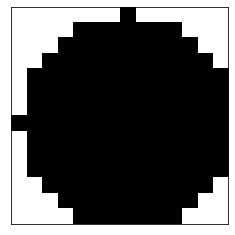

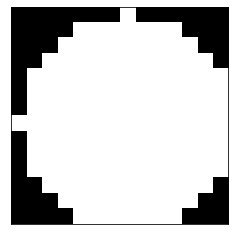

In [949]:
circle_black,turncolor_circle_black  = Make_BlacknoteImg(gosen_interval)
num_pixel = turncolor_circle_black.shape[0]*turncolor_circle_black.shape[1]
print(turncolor_circle_black.shape)
print('ピクセル数：　',num_pixel)
num_blackpixel_template = np.size(turncolor_circle_black[turncolor_circle_black!=0])
print('黒部分のピクセル数：　',num_blackpixel_template)
print('黒の割合：　',num_blackpixel_template/num_pixel)
plt.imshow(circle_black ,cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(turncolor_circle_black ,cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

In [950]:
print(gosen_interval)

14.8


メイン処理

In [951]:
def Detect_Blacknote(turncolor_img_delete,data,turncolor_circle_black,searchline,gosen_interval,gosen_id,threthold):
    """
    ラベリング画像内の黒符頭を検出し，座標を保存する．
    
    1.探索線上を舐めて行きながら，ラベリング画像と黒丸画像を掛け算した時の非ゼロ要素の個数を算出．
    2.黒丸画像の黒丸部分の画素数に対しての非ゼロの個数が閾値(9割ぐらい？)以上なら黒符頭と断定．
    3.断定された黒符頭の座標を保存．
    4.上下左右gosen_interval/2分内にある検出は同一音符とみなし，重複を削除
    
    入力: 五線除去後の反転楽譜，ラベリング画像の情報，反転黒丸画像，探索線情報，五線間隔,対象の五線id
    出力:　抽出された黒符頭の座標
    """
    #縦方向の探索範囲を定義(探索線の削減)
    dummy = searchline[gosen_id]
    searchline_del = dummy[(dummy>=data[1]) & (dummy<=data[1]+data[3])]
    #横の探索範囲を定義(黒丸画像の半円分は削る)
    r = int(turncolor_circle_black.shape[0]/2)#半径
    search_range_x = [data[0]+r ,data[0] +data[2]-r]
    #黒丸画像の黒部分の画素数
    num_pixel = turncolor_circle_black.shape[0]*turncolor_circle_black.shape[1]
    num_blackpixel_template = np.size(turncolor_circle_black[turncolor_circle_black!=0])
    num_whitepixel_template = num_pixel - num_blackpixel_template
    
    search_data = []#座標を保存する配列
    for line in searchline_del:
        for x in range(search_range_x[0],search_range_x[1]):
            labeling_img_part  = turncolor_img_delete[line-r:line+r, x - r : x + r]
            mat = labeling_img_part*turncolor_circle_black
            res = np.size(mat[mat!=0])
            if res/num_blackpixel_template >= threthold :#閾値
                search_data.append([line, x, gosen_id])
    #検出できなかった時の例外処理      
    if len(search_data)==0:
        return search_data
    
    
    #上下左右に音符があっても五線間隔gosen_interval/2くらいは離れているだろう..
    #上下左右gosen_interval/2分内にある検出は同一音符とみなす．
    #重複を削除
    search_data = np.array(search_data)
    
    while True:
        count_del = 0
        ##---x方向---##
        search_data = search_data[np.argsort(search_data[:,1],axis=0)]#x座標の昇順に従って並び替え
        i=0
        while not (search_data[-1] == search_data[i]).all(): 
            dif_x = abs(search_data[i+1,1] - search_data[i,1])
            dif_y = abs(search_data[i+1,0] - search_data[i,0])
            if (dif_x <= (gosen_interval-1)/2) and (dif_y <= (gosen_interval-1)/2):
                search_data = np.delete(search_data,obj=i,axis=0)
                count_del += 1 
                i -= 1
            i += 1
        ##---y方向---##
        search_data = search_data[np.argsort(search_data[:,0],axis=0)]#y座標の昇順に従って並び替え
        i=0
        while not (search_data[-1] == search_data[i]).all():
            dif_x = abs(search_data[i+1,1] - search_data[i,1])
            dif_y = abs(search_data[i+1,0] - search_data[i,0])
            if (dif_y<=(gosen_interval-1)/2) and (dif_x <= (gosen_interval-1)/2):
                search_data = np.delete(search_data,obj=i,axis=0)
                count_del += 1 
                i -= 1
            i += 1
        if count_del==0:
            break
    
    return search_data

  0%|          | 0/11 [00:00<?, ?it/s]

------------1行目-------------
60 343
1 [111 144   8  18  58] 0
2 [121 144   8  18  56] 0
3 [131 144  13  18  83] 0
4 [  45  152   37  102 1091] 0
5 [1475  159   19   59  277] 0
[[ 209 1485    0]]


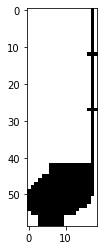

6 [ 29 172   5  61 304] 0
7 [434 172   5  61 305] 0
8 [839 172   5  61 305] 0
9 [1243  172    6   61  246] 0
10 [1373  172   69   74 1091] 0
[[ 224 1383    0]
 [ 238 1434    0]]


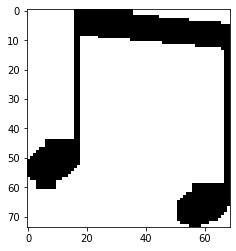

11 [1643  172    5   61  245] 0
12 [126 174  18  59 313] 0
[[224 136   0]]


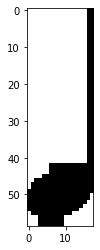

13 [568 174  17  51 319] 0
14 [ 91 179  12  31 142] 0
15 [1143  179   66   74 1005] 0
[[ 231 1154    0]
 [ 245 1200    0]]


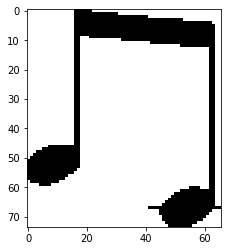

16 [1270  179   70   67 1008] 0
[[ 231 1332    0]
 [ 238 1282    0]]


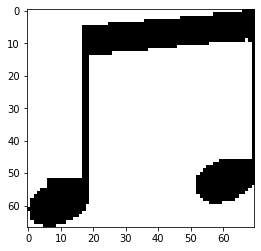

17 [200 182  19  57 289] 0
[[231 211   0]]


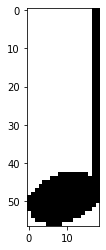

18 [958 187  67  74 997] 0
[[ 238  969    0]
 [ 252 1016    0]]


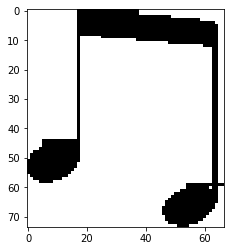

19 [1046  187   68   66  926] 0
[[ 238 1106    0]
 [ 245 1061    0]]


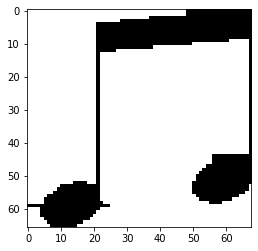

20 [275 189  18  57 252] 0
[[238 285   0]]


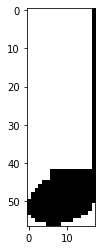

21 [778 189  20  39 191] 0
22 [515 190  16  28 126] 0
23 [866 194  67  67 916] 0
[[245 923   0]
 [252 877   0]]


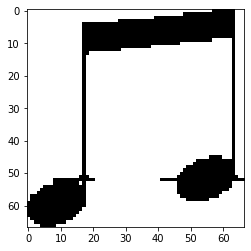

24 [346 196  25  57 249] 0
[[245 361   0]]


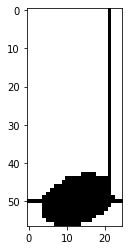

25 [722 196  38  57 429] 0
[[245 738   0]]


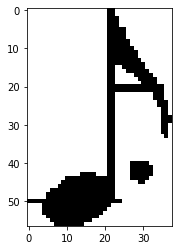

26 [1550  196   25   57  248] 0
[[ 245 1566    0]]


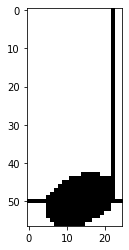

27 [456 201  38  67 392] 0
[[259 471   0]]


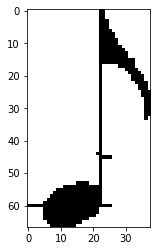

28 [632 201  70  67 970] 0
[[252 692   0]
 [259 647   0]]


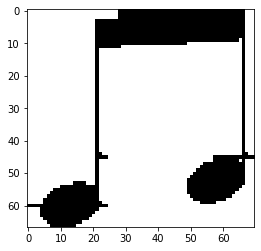

  9%|▉         | 1/11 [00:01<00:19,  1.93s/it]

29 [749 236   6   6  30] 0
30 [ 55 239  12  15 135] 0
31 [111 305   8  17  56] 0
32 [122 305   8  17  54] 0
33 [131 305  14  18 116] 0
------------2行目-------------
221 504
29 [749 236   6   6  30] 1
30 [ 55 239  12  15 135] 1
31 [111 305   8  17  56] 1
32 [122 305   8  17  54] 1
33 [131 305  14  18 116] 1
34 [  45  312   37  102 1071] 1
35 [ 29 332   5  61 304] 1
36 [434 332   5  61 305] 1
37 [839 332   5  61 305] 1
38 [1244  332    4   61  244] 1
39 [1644  332    4   61  244] 1
40 [126 335  18  58 303] 1
[[384 136   1]]


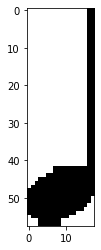

41 [568 335  17  51 313] 1
42 [ 91 340  12  31 138] 1
43 [200 343  19  56 287] 1
[[392 211   1]]


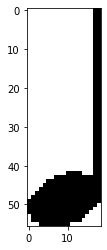

44 [1270  342   34   57  414] 1
[[ 392 1281    1]]


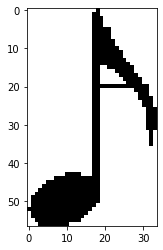

45 [866 347  58  59 889] 1
[[399 877   1]
 [399 916   1]]


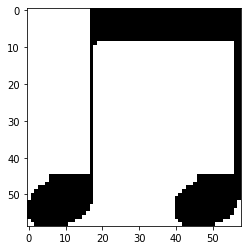

46 [1390  347   70   52  963] 1
[[ 392 1401    1]
 [ 392 1452    1]]


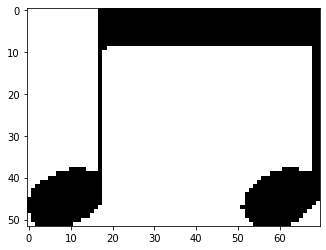

47 [275 350  18  56 245] 1
[[399 285   1]]


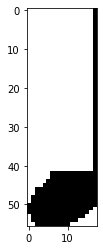

48 [515 351  16  27 126] 1
49 [778 350  20  39 196] 1
50 [945 351  17  27 130] 1
51 [993 350  33  56 376] 1
[[ 399 1004    1]]


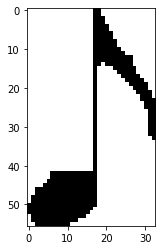

52 [1042  350   33   56  414] 1
[[ 399 1053    1]]


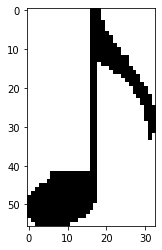

53 [1090  351   16   27  122] 1
54 [1138  350   33   56  376] 1
[[ 399 1149    1]]


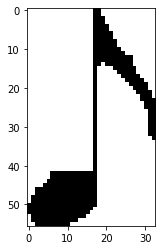

55 [1187  351   16   27  129] 1
56 [1331  351   16   27  129] 1
57 [1496  354   15    9  135] 1
58 [346 357  25  57 254] 1
[[406 361   1]]


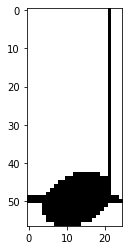

59 [722 357  38  57 427] 1
[[406 738   1]]


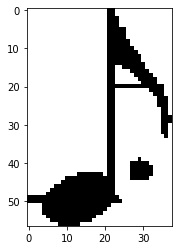

60 [456 362  38  67 395] 1
[[420 472   1]]


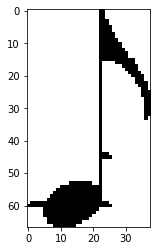

61 [632 362  70  67 965] 1
[[413 692   1]
 [420 647   1]]


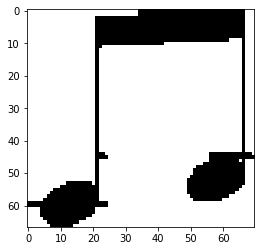

 18%|█▊        | 2/11 [00:03<00:16,  1.89s/it]

62 [749 396   6   6  29] 1
63 [ 55 399  12  16 132] 1
64 [111 466   8  17  56] 1
65 [120 466  13  17  86] 1
------------3行目-------------
382 665
62 [749 396   6   6  29] 2
63 [ 55 399  12  16 132] 2
64 [111 466   8  17  56] 2
65 [120 466  13  17  86] 2
66 [ 126  466   76  102 1417] 2
[[530 194   2]
 [560 137   2]]


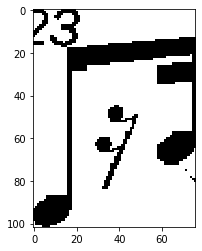

67 [  45  473   37  102 1072] 2
68 [213 479  49  75 803] 2
[[530 224   2]
 [545 254   2]]


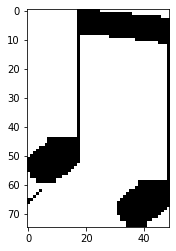

69 [ 275  479   77  103 1264] 2
[[530 344   2]
 [574 286   2]]


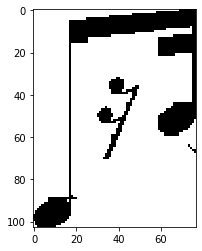

70 [363 479  49  75 851] 2
[[530 374   2]
 [545 404   2]]


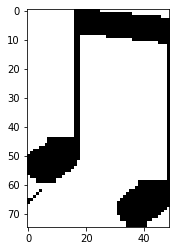

71 [ 456  479   94   96 1342] 2
[[530 542   2]
 [567 472   2]]


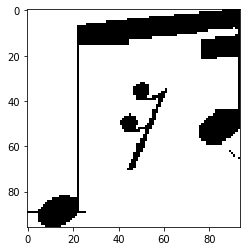

72 [567 479  60  81 983] 2
[[530 579   2]
 [553 619   2]]


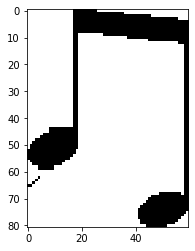

73 [ 866  479   88   89 1360] 2
[[530 946   2]
 [560 877   2]]


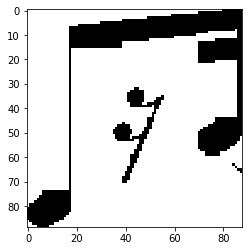

74 [970 479  59  75 984] 2
[[ 530  982    2]
 [ 545 1021    2]]


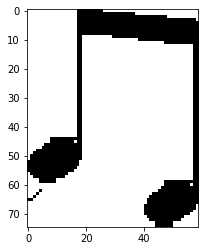

75 [1050  479   88  103 1334] 2
[[ 530 1130    2]
 [ 574 1061    2]]


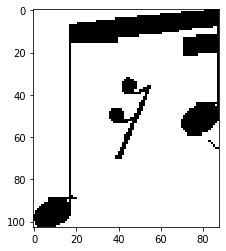

76 [1155  479   58   75  886] 2
[[ 530 1166    2]
 [ 545 1205    2]]


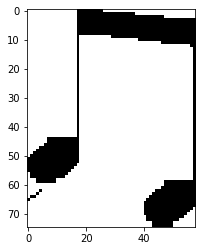

77 [1357  479   62   81  941] 2
[[ 530 1411    2]
 [ 553 1368    2]]


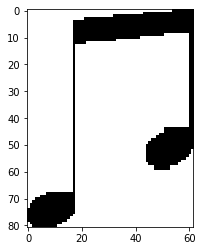

78 [1266  486   66   89  969] 2
[[ 538 1324    2]
 [ 567 1282    2]]


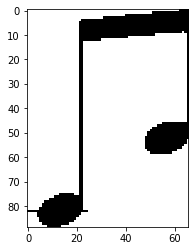

79 [ 29 493   5  61 304] 2
80 [434 493   5  61 305] 2
81 [748 493  62  82 921] 2
[[545 759   2]
 [567 800   2]]


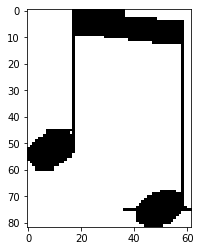

82 [839 493   5  61 305] 2
83 [1244  493    4   61  244] 2
84 [1548  493   64   82  934] 2
[[ 545 1559    2]
 [ 567 1602    2]]


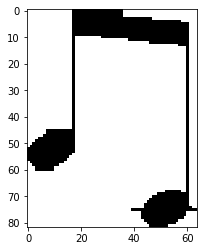

85 [1644  493    4   61  244] 2
86 [649 496  33  58 385] 2
[[545 660   2]]


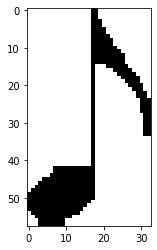

87 [1444  496   33   58  385] 2
[[ 545 1455    2]]


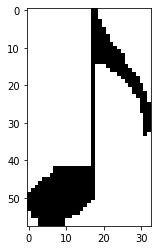

 27%|██▋       | 3/11 [00:05<00:15,  1.99s/it]

88 [ 91 501  12  31 136] 2
89 [155 511  20  39 190] 2
90 [305 511  20  39 188] 2
91 [497 511  21  39 194] 2
92 [901 511  21  39 192] 2
93 [1086  511   20   39  191] 2
94 [699 512  16  27 123] 2
95 [1496  512   16   27  130] 2
96 [197 541   1   1   1] 2
97 [210 541   8   6  10] 2
98 [360 541   8   6   9] 2
99 [545 541   3   3   3] 2
100 [562 541  10   6  10] 2
101 [965 541  10   6  11] 2
102 [1133  541    9    6   10] 2
103 [1150  541   10    6   11] 2
104 [348 543   6   4   7] 2
105 [950 542   8   5   9] 2
106 [199 544   5   3   6] 2
107 [549 544   5   3   6] 2
108 [ 55 560  12  16 130] 2
109 [111 627   8  17  53] 2
110 [120 626  13  18  90] 2
111 [134 627  14  17  64] 2
------------4行目-------------
543 826
104 [348 543   6   4   7] 3
106 [199 544   5   3   6] 3
107 [549 544   5   3   6] 3
108 [ 55 560  12  16 130] 3
109 [111 627   8  17  53] 3
110 [120 626  13  18  90] 3
111 [134 627  14  17  64] 3
112 [  45  634   37  102 1072] 3
113 [1634  637   13   34  196] 3
114 [ 126  639   76  

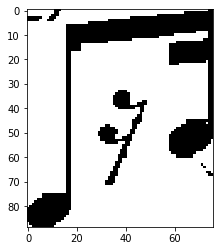

115 [213 639  49  76 809] 3
[[691 224   3]
 [706 254   3]]


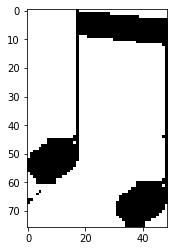

116 [ 275  639   77  104 1276] 3
[[691 344   3]
 [735 286   3]]


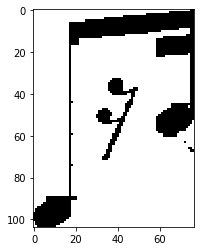

117 [363 639  49  76 854] 3
[[691 374   3]
 [706 404   3]]


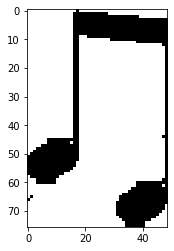

118 [ 457  639   93   97 1342] 3
[[691 542   3]
 [728 472   3]]


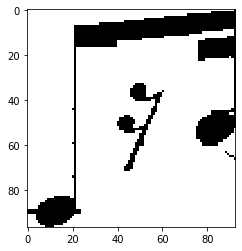

119 [567 639  60  82 984] 3
[[691 579   3]
 [714 619   3]]


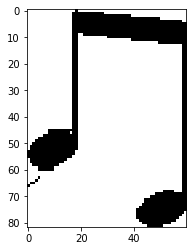

120 [ 866  639   88  104 1390] 3
[[691 946   3]
 [735 877   3]]


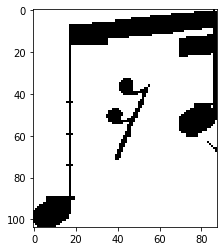

121 [970 639  59  76 978] 3
[[ 691  982    3]
 [ 706 1021    3]]


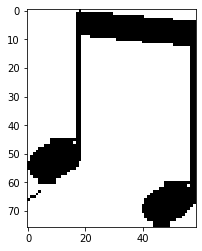

122 [1046  639   93   97 1332] 3
[[ 691 1131    3]
 [ 728 1061    3]]


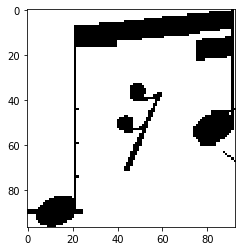

123 [1155  639   58   82  877] 3
[[ 691 1166    3]
 [ 714 1205    3]]


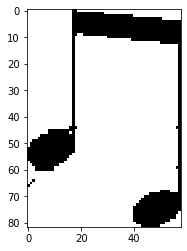

124 [1353  639   60   82  880] 3
[[ 691 1405    3]
 [ 714 1363    3]]


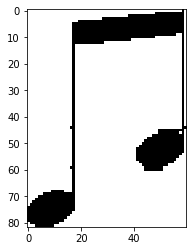

125 [ 29 654   5  61 305] 3
126 [434 654   5  61 305] 3
127 [748 654  61  82 930] 3
[[706 759   3]
 [728 800   3]]


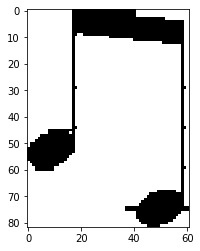

128 [839 654   5  61 305] 3
129 [1243  654    6   61  250] 3
130 [1270  654   60   89 1020] 3
[[ 706 1322    3]
 [ 735 1282    3]]


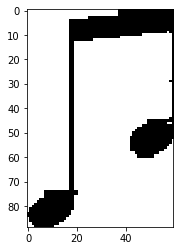

131 [1604  654    5   61  305] 3
132 [649 657  34  58 391] 3
[[706 660   3]]


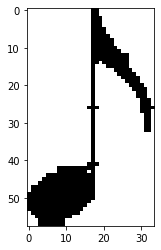

133 [1435  657   34   58  423] 3
[[ 706 1447    3]]


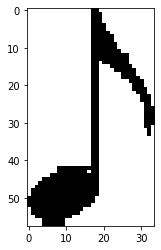

 36%|███▋      | 4/11 [00:08<00:14,  2.07s/it]

134 [1535  657   17   51  315] 3
135 [ 91 662  12  31 138] 3
136 [1619  666   10   35  154] 3
137 [155 672  20  39 200] 3
138 [305 672  20  39 197] 3
139 [497 672  21  39 197] 3
140 [699 672  16  28 129] 3
141 [901 672  21  39 198] 3
142 [1086  672   20   39  192] 3
143 [1485  672   16   28  133] 3
144 [197 702   2   2   2] 3
145 [216 702   2   2   2] 3
146 [347 702   1   1   1] 3
147 [545 702  10   6  10] 3
148 [565 702   7   5   8] 3
149 [949 702  10   6  12] 3
150 [968 702   7   5   8] 3
151 [1133  702   10    6   10] 3
152 [1146  703   12    5   13] 3
153 [199 705   6   3   7] 3
154 [207 705   8   3   9] 3
155 [349 705   6   3   7] 3
156 [357 704   8   4   9] 3
157 [ 55 721  12  16 137] 3
158 [122 787  14  19 100] 3
159 [113 788   8  17  57] 3
------------5行目-------------
704 987
153 [199 705   6   3   7] 4
154 [207 705   8   3   9] 4
155 [349 705   6   3   7] 4
156 [357 704   8   4   9] 4
157 [ 55 721  12  16 137] 4
158 [122 787  14  19 100] 4
159 [113 788   8  17  57] 4
160 [ 128

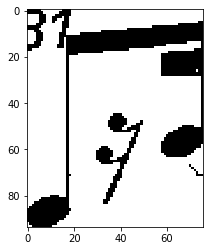

161 [215 793  49  74 863] 4
[[845 225   4]
 [860 256   4]]


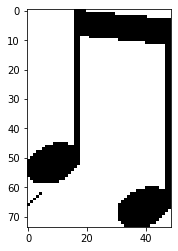

162 [ 272  793   81  104 1351] 4
[[845 345   4]
 [889 288   4]]


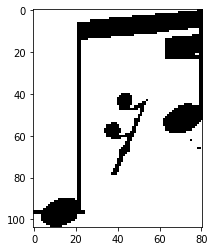

163 [363 793  50  74 768] 4
[[845 374   4]
 [860 405   4]]


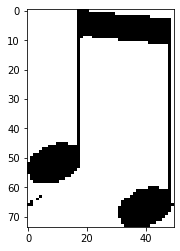

164 [ 461  793   89   96 1324] 4
[[845 542   4]
 [882 472   4]]


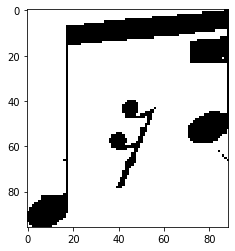

165 [567 793  60  83 991] 4
[[845 578   4]
 [867 619   4]]


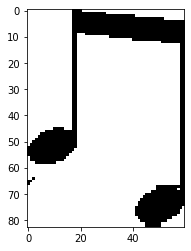

166 [ 866  793   88   89 1340] 4
[[845 946   4]
 [875 877   4]]


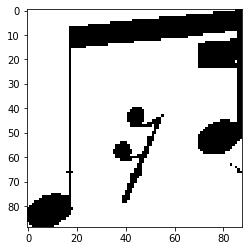

167 [970 793  59  74 952] 4
[[ 845  981    4]
 [ 860 1021    4]]


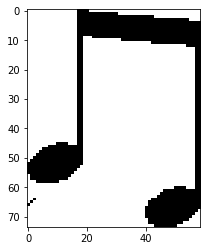

168 [1046  793   92  104 1327] 4
[[ 845 1130    4]
 [ 889 1061    4]]


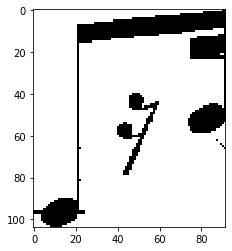

169 [1155  793   58   74  851] 4
[[ 845 1166    4]
 [ 860 1205    4]]


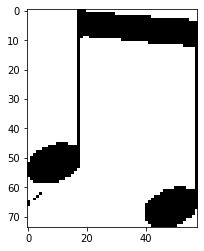

170 [1357  793   62   83  949] 4
[[ 845 1411    4]
 [ 867 1368    4]]


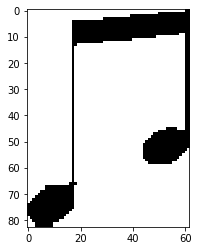

171 [  45  795   37  102 1077] 4
172 [ 91 798  14  34 238] 4
173 [1270  800   62   89  986] 4
[[ 852 1324    4]
 [ 882 1281    4]]


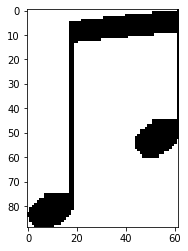

174 [748 808  60  81 875] 4
[[860 759   4]
 [882 800   4]]


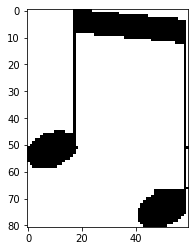

175 [1548  808   62   81  892] 4
[[ 860 1559    4]
 [ 882 1602    4]]


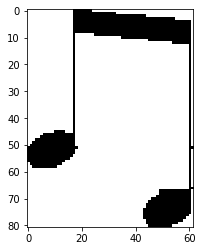

176 [649 810  33  57 391] 4
[[860 660   4]]


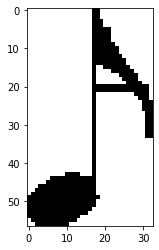

177 [1444  810   33   57  389] 4
[[ 860 1455    4]]


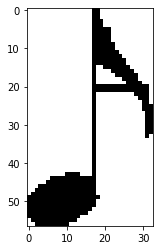

 45%|████▌     | 5/11 [00:10<00:13,  2.21s/it]

178 [ 29 815   5  61 304] 4
179 [434 815   5  61 305] 4
180 [839 815   5  61 305] 4
181 [1243  815    6   61  248] 4
182 [1643  815    5   61  246] 4
183 [158 833  20  39 198] 4
184 [306 833  21  39 199] 4
185 [497 833  21  39 199] 4
186 [699 833  16  28 127] 4
187 [901 833  21  39 199] 4
188 [1086  833   20   39  193] 4
189 [1496  833   16   28  132] 4
190 [198 855   6   5   7] 4
191 [214 855   6   5   6] 4
192 [347 855   1   1   1] 4
193 [545 855   1   1   1] 4
194 [1133  855    1    1    1] 4
195 [1157  855    3    3    3] 4
196 [366 856   2   2   2] 4
197 [547 857   5   3   5] 4
198 [565 857   5   3   6] 4
199 [949 856   1   1   1] 4
200 [951 857   4   3   5] 4
201 [968 857   5   3   5] 4
202 [1135  857    5    3    5] 4
203 [350 859   2   1   2] 4
204 [363 858   2   2   3] 4
205 [1153  858    3    2    4] 4
206 [ 55 882  12  16 134] 4
207 [113 949   8  17  56] 4
208 [122 948  14  18  93] 4
------------6行目-------------
864 1148
206 [ 55 882  12  16 134] 5
207 [113 949   8  17  56] 

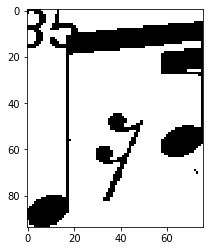

210 [215 954  49  74 863] 5
[[1006  225    5]
 [1021  256    5]]


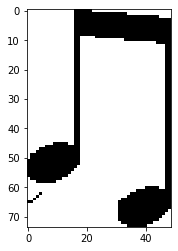

211 [ 272  954   81  104 1333] 5
[[1006  345    5]
 [1050  287    5]]


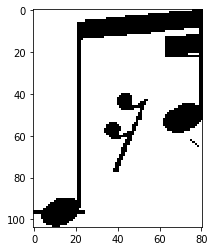

212 [363 954  50  74 768] 5
[[1006  374    5]
 [1021  404    5]]


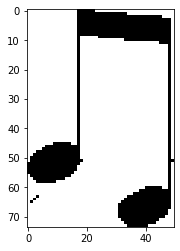

213 [ 461  954   89   96 1318] 5
[[1006  542    5]
 [1043  471    5]]


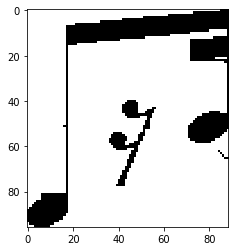

214 [ 567  954   60   83 1002] 5
[[1006  578    5]
 [1028  619    5]]


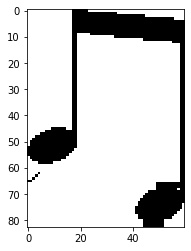

215 [ 861  954   93  104 1353] 5
[[1006  946    5]
 [1050  877    5]]


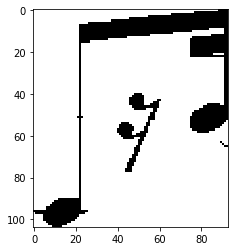

216 [970 954  59  74 955] 5
[[1006  981    5]
 [1021 1021    5]]


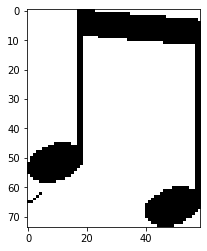

217 [1050  954   89   96 1308] 5
[[1006 1130    5]
 [1043 1061    5]]


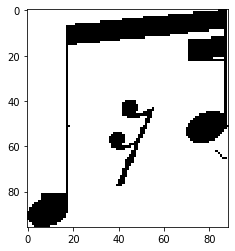

218 [1155  954   58   83  895] 5
[[1006 1165    5]
 [1028 1205    5]]


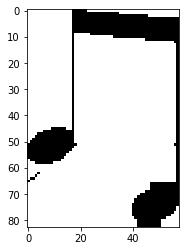

219 [1357  954   62   83  965] 5
[[1006 1411    5]
 [1028 1368    5]]


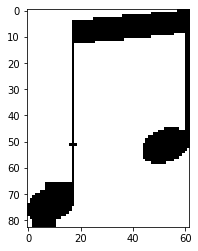

220 [  45  956   37  102 1077] 5
221 [ 91 959  14  34 225] 5
222 [748 969  60  81 885] 5
[[1021  758    5]
 [1043  799    5]]


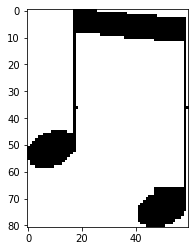

223 [1266  969   66   89  976] 5
[[1021 1324    5]
 [1050 1282    5]]


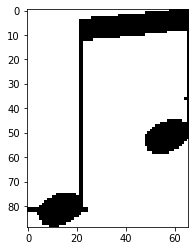

224 [1548  969   62   81  900] 5
[[1021 1558    5]
 [1043 1601    5]]


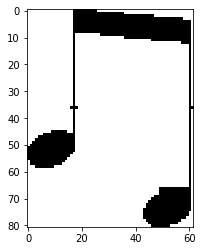

225 [649 971  33  57 383] 5
[[1021  659    5]]


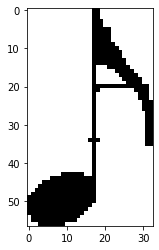

226 [1444  971   33   57  383] 5
[[1021 1454    5]]


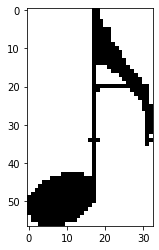

 55%|█████▍    | 6/11 [00:12<00:10,  2.19s/it]

227 [ 29 976   5  61 305] 5
228 [434 976   5  61 305] 5
229 [839 976   5  61 305] 5
230 [1243  976    6   61  246] 5
231 [1643  976    5   61  245] 5
232 [158 994  20  38 199] 5
233 [306 994  21  38 194] 5
234 [497 994  21  38 196] 5
235 [699 994  16  28 127] 5
236 [901 994  21  38 197] 5
237 [1086  994   20   38  191] 5
238 [1496  994   16   28  133] 5
239 [ 215 1016    5    4    5] 5
240 [ 347 1016    4    4    4] 5
241 [ 364 1017    3    3    3] 5
242 [ 545 1016    5    4    5] 5
243 [ 567 1016    5    4    5] 5
244 [ 950 1017    4    3    4] 5
245 [ 970 1016    5    4    5] 5
246 [1133 1016    5    4    5] 5
247 [1154 1016    6    4    6] 5
248 [ 200 1018    2    2    2] 5
249 [  55 1043   12   16  134] 5
250 [ 713 1096   13   18   98] 5
251 [ 687 1102    1   10   10] 5
252 [ 754 1102    1   10   10] 5
253 [ 113 1109    8   18   57] 5
254 [ 122 1109   14   18   97] 5
------------7行目-------------
1025 1308
249 [  55 1043   12   16  134] 6
250 [ 713 1096   13   18   98] 6
251 [ 687 1

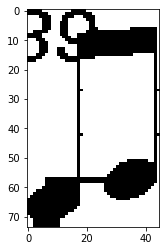

256 [ 180 1115  141   96 3164] 6
[[1167  312    6]
 [1174  287    6]
 [1196  191    6]
 [1196  239    6]
 [1203  215    6]
 [1203  264    6]]


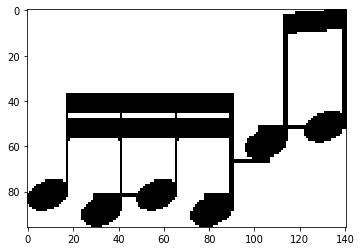

257 [ 461 1115   53   68  838] 6
[[1167  506    6]
 [1174  472    6]]


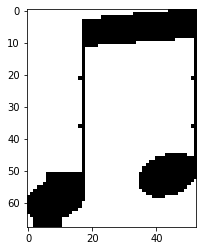

258 [ 866 1115   53   68  837] 6
[[1167  911    6]
 [1174  877    6]]


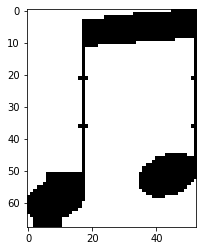

259 [1050 1115   54   68  833] 6
[[1167 1095    6]
 [1174 1061    6]]


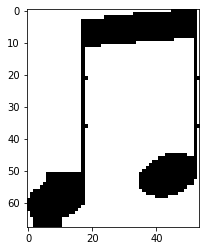

260 [1270 1115   50   68 1040] 6
[[1167 1311    6]
 [1174 1281    6]]


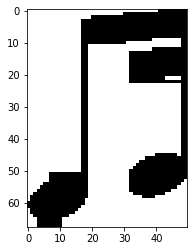

261 [  45 1117   37  102 1093] 6
262 [  91 1120   14   34  229] 6
263 [ 646 1122  104   76 2436] 6
[[1182  655    6]
 [1182  713    6]
 [1189  684    6]
 [1189  742    6]]


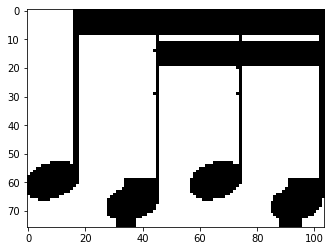

264 [1363 1123   80   81 1250] 6
[[1130 1434    6]
 [1152 1373    6]]


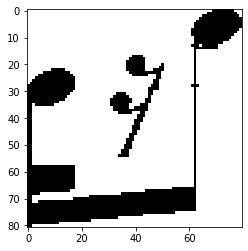

265 [1455 1123  102   75 2569] 6
[[1130 1493    6]
 [1137 1465    6]
 [1137 1521    6]
 [1144 1549    6]]


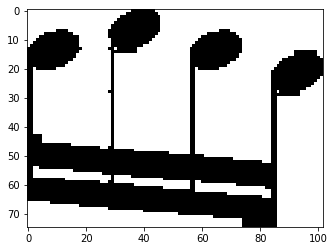

266 [  29 1137    5   61  304] 6
267 [ 434 1137    5   61  305] 6
268 [ 839 1137    5   61  305] 6
269 [1243 1137    6   61  246] 6
270 [1643 1137    5   61  245] 6
271 [1394 1140   20   38  198] 6
272 [ 760 1144   53   67  854] 6
[[1196  771    6]
 [1203  805    6]]


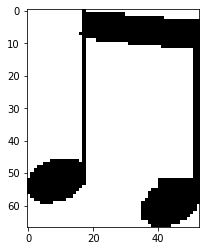

273 [1567 1145   52   74  886] 6
[[1152 1577    6]
 [1167 1611    6]]


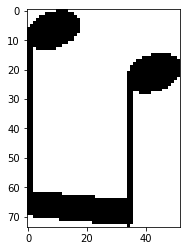

274 [ 329 1152   90   59 2315] 6
[[1196  340    6]
 [1196  388    6]
 [1203  364    6]
 [1203  411    6]]


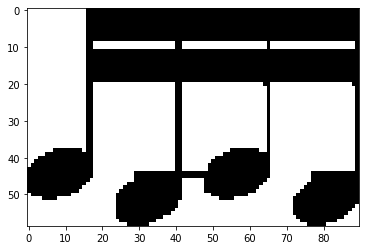

275 [ 531 1152  104   59 2551] 6
[[1196  542    6]
 [1196  599    6]
 [1203  571    6]
 [1203  627    6]]


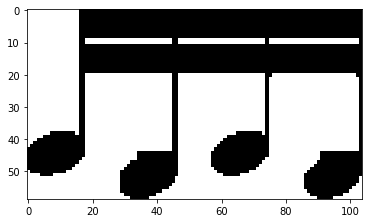

276 [ 936 1152  104   59 2544] 6
[[1196  947    6]
 [1196 1004    6]
 [1203  976    6]
 [1203 1032    6]]


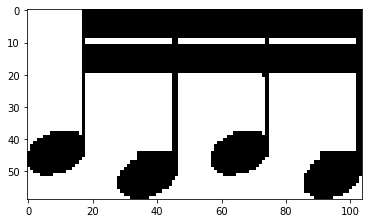

277 [1120 1152  104   59 2500] 6
[[1196 1131    6]
 [1196 1189    6]
 [1203 1160    6]
 [1203 1216    6]]


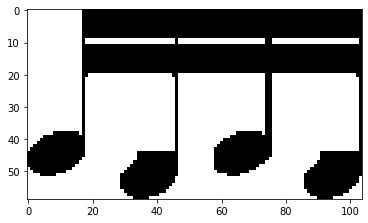

 64%|██████▎   | 7/11 [00:15<00:08,  2.20s/it]

278 [1333 1155   20   38  190] 6
279 [  55 1204   12   15  136] 6
280 [ 713 1257   13   18   98] 6
281 [ 687 1263    1   11   11] 6
282 [ 754 1263    1   11   11] 6
283 [ 113 1270    8   18   58] 6
284 [ 122 1270   14   18  103] 6
------------8行目-------------
1186 1469
279 [  55 1204   12   15  136] 7
280 [ 713 1257   13   18   98] 7
281 [ 687 1263    1   11   11] 7
282 [ 754 1263    1   11   11] 7
283 [ 113 1270    8   18   58] 7
284 [ 122 1270   14   18  103] 7
285 [ 128 1270   45   74  836] 7
[[1328  164    7]
 [1335  139    7]]


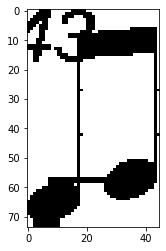

286 [ 180 1276  141   96 3166] 7
[[1328  312    7]
 [1335  287    7]
 [1357  191    7]
 [1357  239    7]
 [1364  215    7]
 [1364  264    7]]


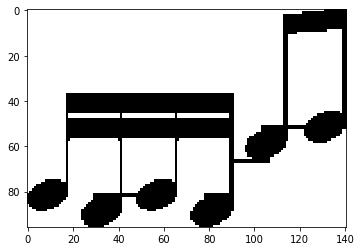

287 [ 461 1276   53   68  831] 7
[[1328  506    7]
 [1335  472    7]]


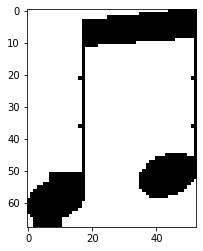

288 [  45 1278   37  102 1099] 7
289 [  91 1281   14   34  228] 7
290 [ 645 1283  105   76 2442] 7
[[1343  655    7]
 [1343  713    7]
 [1350  685    7]
 [1350  742    7]]


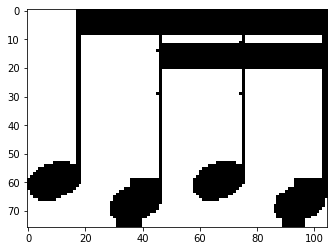

291 [ 953 1283   76   82 1624] 7
[[1343  963    7]
 [1343 1020    7]
 [1357  993    7]]


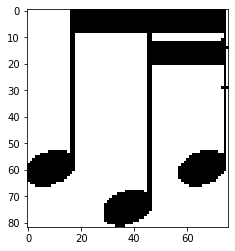

292 [1039 1283   76   61 1508] 7
[[1328 1049    7]
 [1328 1107    7]
 [1335 1079    7]]


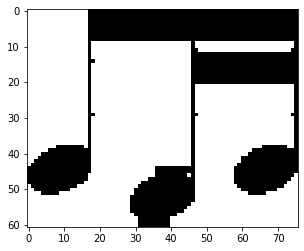

293 [1126 1284  100   88 2478] 7
[[1291 1163    7]
 [1313 1136    7]
 [1313 1218    7]
 [1328 1190    7]]


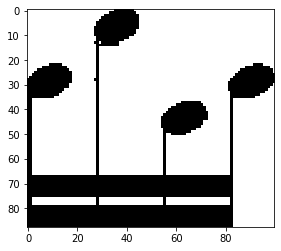

294 [1270 1284  112   75 2620] 7
[[1291 1280    7]
 [1291 1343    7]
 [1298 1312    7]
 [1298 1374    7]]


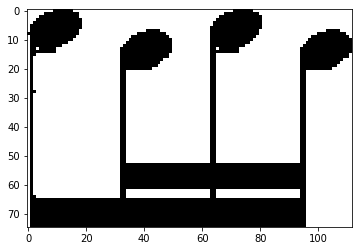

295 [1555 1290   58   75  893] 7
[[1343 1605    7]
 [1357 1566    7]]


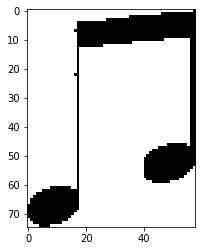

296 [  29 1298    5   61  304] 7
297 [ 434 1298    5   61  305] 7
298 [ 839 1298    5   61  305] 7
299 [1243 1298    6   61  246] 7
300 [1395 1298   59   67  953] 7
[[1305 1406    7]
 [1313 1446    7]]


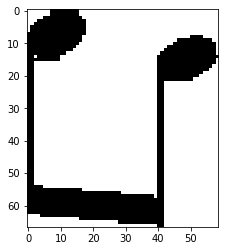

301 [1475 1298   18   57  413] 7
[[1305 1485    7]]


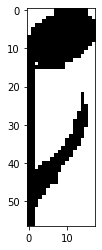

302 [1643 1298    5   61  245] 7
303 [ 760 1305   53   67  856] 7
[[1357  771    7]
 [1364  805    7]]


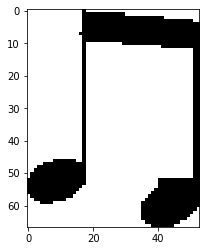

304 [ 329 1313   90   59 2316] 7
[[1357  340    7]
 [1357  388    7]
 [1364  364    7]
 [1364  411    7]]


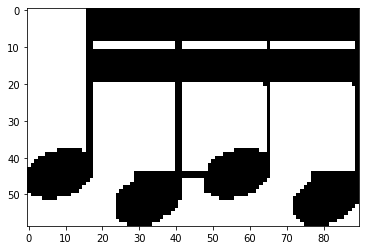

305 [ 531 1313  104   59 2554] 7
[[1357  542    7]
 [1357  599    7]
 [1364  571    7]
 [1364  627    7]]


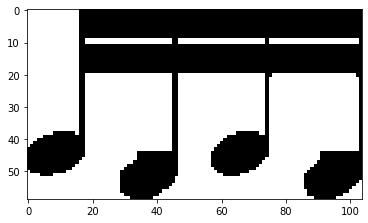

306 [ 866 1313   76   59 1547] 7
[[1357  877    7]
 [1357  934    7]
 [1364  906    7]]


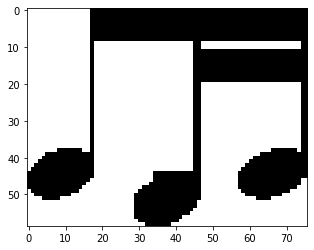

 73%|███████▎  | 8/11 [00:17<00:06,  2.21s/it]

307 [1515 1316   17   28  130] 7
308 [  55 1365   12   16  135] 7
309 [1297 1367    2   11   22] 7
310 [1369 1367    2   11   21] 7
311 [1325 1371   14   18   96] 7
312 [ 713 1418   13   18   97] 7
313 [ 687 1424    1   10   10] 7
314 [ 754 1424    1   10   10] 7
315 [ 113 1431    8   18   58] 7
316 [ 122 1431   14   18   99] 7
------------9行目-------------
1347 1630
308 [  55 1365   12   16  135] 8
309 [1297 1367    2   11   22] 8
310 [1369 1367    2   11   21] 8
311 [1325 1371   14   18   96] 8
312 [ 713 1418   13   18   97] 8
313 [ 687 1424    1   10   10] 8
314 [ 754 1424    1   10   10] 8
315 [ 113 1431    8   18   58] 8
316 [ 122 1431   14   18   99] 8
317 [ 128 1431   44   74  826] 8
[[1489  163    8]
 [1496  138    8]]


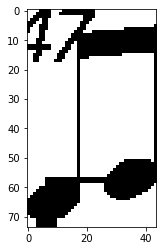

318 [ 276 1436   45   69  847] 8
[[1489  312    8]
 [1496  287    8]]


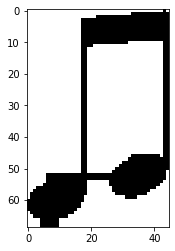

319 [ 461 1436   53   69  825] 8
[[1489  505    8]
 [1496  471    8]]


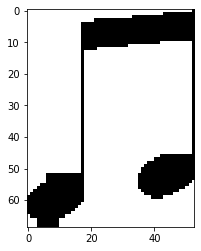

320 [ 866 1436   53   69  825] 8
[[1489  910    8]
 [1496  876    8]]


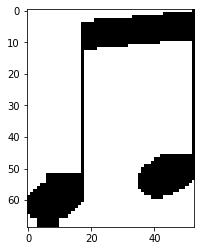

321 [1050 1436   53   69  820] 8
[[1489 1095    8]
 [1496 1061    8]]


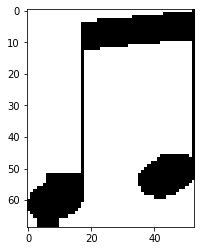

322 [1270 1436   50   69 1036] 8
[[1489 1311    8]
 [1496 1281    8]]


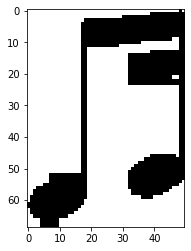

323 [  45 1439   37  101 1099] 8
324 [  91 1441   14   35  242] 8
325 [ 646 1444  104   76 2427] 8
[[1504  655    8]
 [1504  712    8]
 [1511  684    8]
 [1511  742    8]]


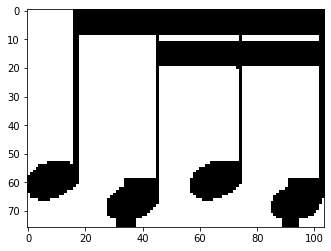

326 [1363 1445   80   80 1244] 8
[[1452 1434    8]
 [1474 1373    8]]


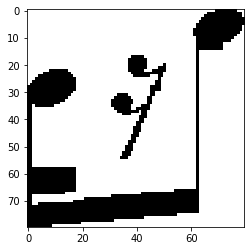

327 [1455 1445  102   75 2593] 8
[[1452 1493    8]
 [1459 1465    8]
 [1459 1521    8]
 [1466 1549    8]]


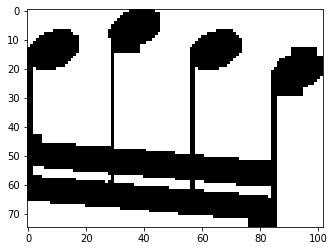

328 [  29 1458    5   62  308] 8
329 [ 434 1458    5   62  310] 8
330 [ 839 1458    5   62  310] 8
331 [1244 1458    4   62  248] 8
332 [1644 1458    4   62  244] 8
333 [1394 1462   20   38  196] 8
334 [ 760 1466   53   67  850] 8
[[1518  771    8]
 [1525  805    8]]


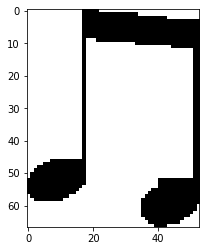

335 [1567 1467   52   73  888] 8
[[1474 1577    8]
 [1489 1610    8]]


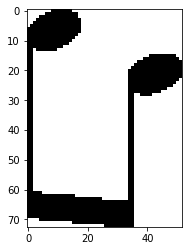

336 [ 180 1473   91   60 2279] 8
[[1518  191    8]
 [1518  239    8]
 [1525  215    8]
 [1525  263    8]]


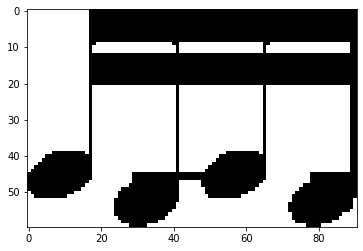

337 [ 329 1473   90   60 2308] 8
[[1518  340    8]
 [1518  388    8]
 [1525  364    8]
 [1525  411    8]]


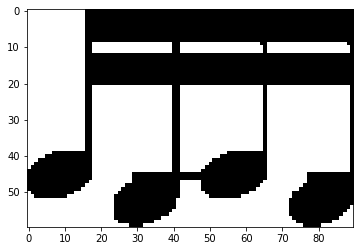

338 [ 531 1473  104   60 2541] 8
[[1518  542    8]
 [1518  599    8]
 [1525  571    8]
 [1525  627    8]]


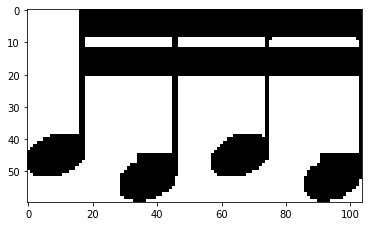

339 [ 936 1473  104   60 2533] 8
[[1518  947    8]
 [1518 1004    8]
 [1525  975    8]
 [1525 1032    8]]


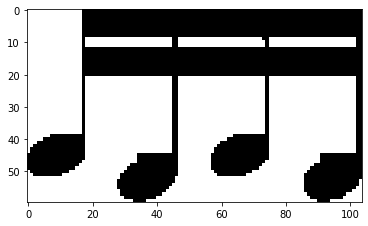

340 [1120 1473  104   60 2494] 8
[[1518 1131    8]
 [1518 1188    8]
 [1525 1160    8]
 [1525 1216    8]]


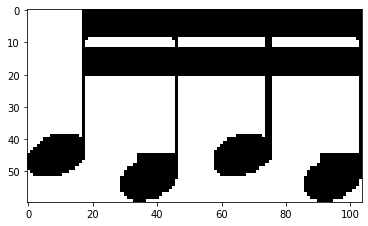

 82%|████████▏ | 9/11 [00:19<00:04,  2.21s/it]

341 [1333 1476   20   39  195] 8
342 [  55 1526   12   15  129] 8
343 [ 713 1579   13   18   99] 8
345 [ 687 1585    1   10   10] 8
346 [ 754 1585    1   10   10] 8
347 [ 113 1592    8   17   57] 8
348 [ 123 1592   13   18   99] 8
------------10行目-------------
1508 1791
342 [  55 1526   12   15  129] 9
343 [ 713 1579   13   18   99] 9
344 [ 866 1582  104   89 2591] 9
[[1635  961    9]
 [1649  934    9]
 [1656  877    9]
 [1664  905    9]]


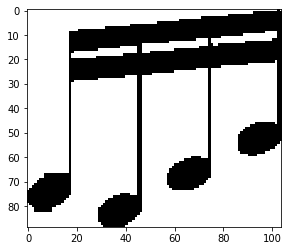

345 [ 687 1585    1   10   10] 9
346 [ 754 1585    1   10   10] 9
347 [ 113 1592    8   17   57] 9
348 [ 123 1592   13   18   99] 9
349 [ 128 1592   44   73  798] 9
[[1649  164    9]
 [1656  139    9]]


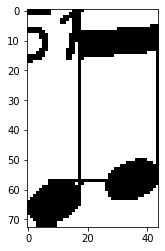

350 [ 276 1597   45   68  834] 9
[[1649  313    9]
 [1656  287    9]]


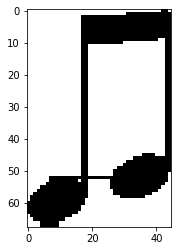

351 [ 461 1597   53   68  814] 9
[[1649  506    9]
 [1656  472    9]]


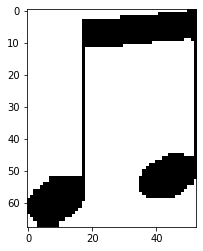

352 [1165 1597   53   68  868] 9
[[1649 1210    9]
 [1656 1176    9]]


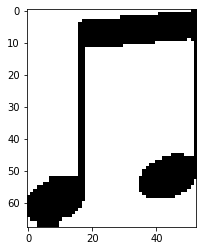

353 [  45 1599   37  102 1077] 9
354 [  91 1602   14   34  238] 9
355 [ 645 1604  105   76 2411] 9
[[1664  656    9]
 [1664  713    9]
 [1671  685    9]
 [1671  742    9]]


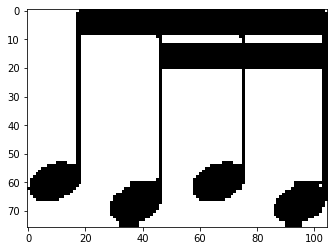

356 [1095 1612   53   74  844] 9
[[1664 1140    9]
 [1679 1105    9]]


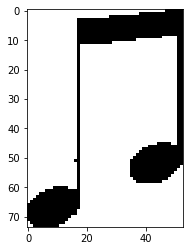

357 [  29 1619    5   61  304] 9
358 [ 434 1619    5   61  305] 9
359 [ 839 1619    5   61  305] 9
360 [ 980 1619  105   90 2606] 9
[[1627  991    9]
 [1635 1019    9]
 [1649 1048    9]
 [1656 1077    9]]


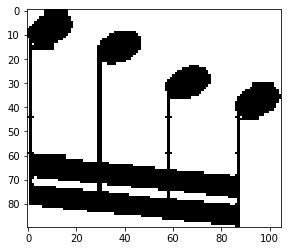

361 [1243 1619    6   61  248] 9
362 [1643 1619    5   61  246] 9
363 [1567 1622   17   51  314] 9
364 [ 760 1627   53   66  846] 9
[[1679  771    9]
 [1686  805    9]]


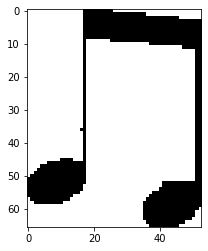

365 [1410 1627   63   66  934] 9
[[1679 1420    9]
 [1686 1465    9]]


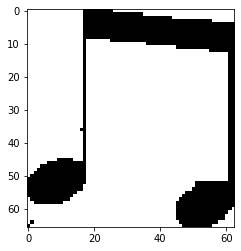

366 [1500 1630   18   56  282] 9
[[1679 1510    9]]


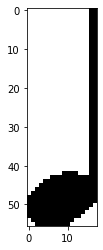

367 [ 180 1634   91   59 2275] 9
[[1679  191    9]
 [1679  239    9]
 [1686  215    9]
 [1686  263    9]]


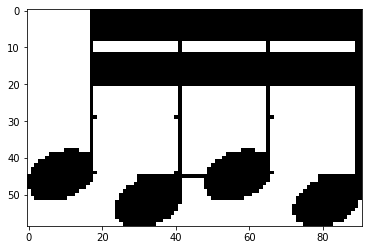

368 [ 329 1634   91   59 2296] 9
[[1679  339    9]
 [1679  387    9]
 [1686  363    9]
 [1686  412    9]]


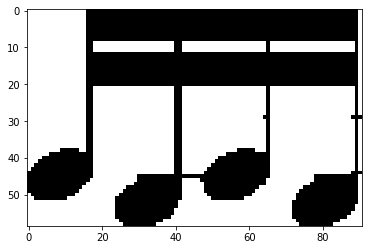

369 [ 531 1634  104   59 2537] 9
[[1679  541    9]
 [1679  599    9]
 [1686  570    9]
 [1686  627    9]]


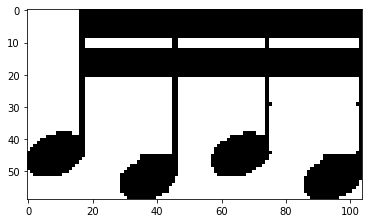

370 [1270 1634  123   52 2367] 9
[[1679 1281    9]
 [1679 1385    9]]


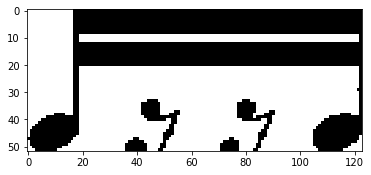

 91%|█████████ | 10/11 [00:21<00:02,  2.20s/it]

371 [1306 1667   20   39  198] 9
372 [1341 1667   20   39  193] 9
373 [  55 1686   12   16  133] 9
374 [1388 1689   10    6   10] 9
375 [1401 1691   11    4   11] 9
376 [ 113 1753    8   17   58] 9
377 [ 123 1753   13   18   98] 9
378 [ 137 1753   13   18   85] 9
------------11行目-------------
1669 1952
373 [  55 1686   12   16  133] 10
374 [1388 1689   10    6   10] 10
375 [1401 1691   11    4   11] 10
376 [ 113 1753    8   17   58] 10
377 [ 123 1753   13   18   98] 10
378 [ 137 1753   13   18   85] 10
379 [  45 1760   37  102 1071] 10
380 [  91 1763   14   34  241] 10
381 [  29 1780    5   61  304] 10
382 [1634 1780   16   61  867] 10
383 [1274 1783   17   51  312] 10
384 [ 550 1788  205   66 2203] 10
[[1840  561   10]
 [1847  747   10]]


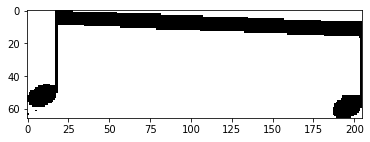

385 [ 923 1790   19   57  288] 10
[[1840  934   10]]


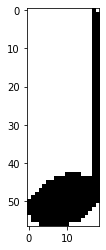

386 [ 128 1795  335   52 6161] 10
[[1840  139   10]
 [1840  455   10]]


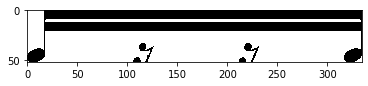

100%|██████████| 11/11 [00:22<00:00,  2.01s/it]

387 [ 234 1828   21   39  194] 10
388 [ 340 1828   20   39  195] 10
389 [  55 1847   12   16  132] 10
390 [ 555 1849    1    1    1] 10
391 [ 461 1851    1    1    1] 10
392 [ 548 1851    3    2    3] 10
393 [ 463 1852   12    5   12] 10
394 [ 543 1853    4    2    4] 10
395 [ 540 1855    2    1    2] 10
396 [ 476 1857    3    1    3] 10


In [952]:
#黒符頭を検出実行
info_black_note = []
upper_hypara = 4
lower_hypara = 4
for i in tqdm(range(len(searchline))):
    print('------------{0}行目-------------'.format(i+1))
    print(searchline[i][0] - upper_hypara*int(gosen_interval),searchline[i][-1] +  lower_hypara*int(gosen_interval))
    for idx in range(1,data.shape[0]-1):
        #探索線(+五線間隔)の範囲内にラベリング画像が収まっていれば探索開始
        if (searchline[i][0] - upper_hypara*int(gosen_interval)<= data[idx,1]) \
            and (searchline[i][-1] +  lower_hypara*int(gosen_interval) >=data[idx,1]+data[idx,3]):
            print(idx,data[idx],i)
            
            res = Detect_Blacknote(turncolor_img_delete,data[idx],turncolor_circle_black\
                                   ,searchline,gosen_interval,i,threthold = 0.90)#探索
            if len(res)!=0:
                for r in res.tolist():
                    info_black_note.append(r)
                print(res)
                labeling_img  = img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]]
                plt.imshow(labeling_img,cmap='gray')
                plt.show()
info_black_note = np.array(info_black_note)

340


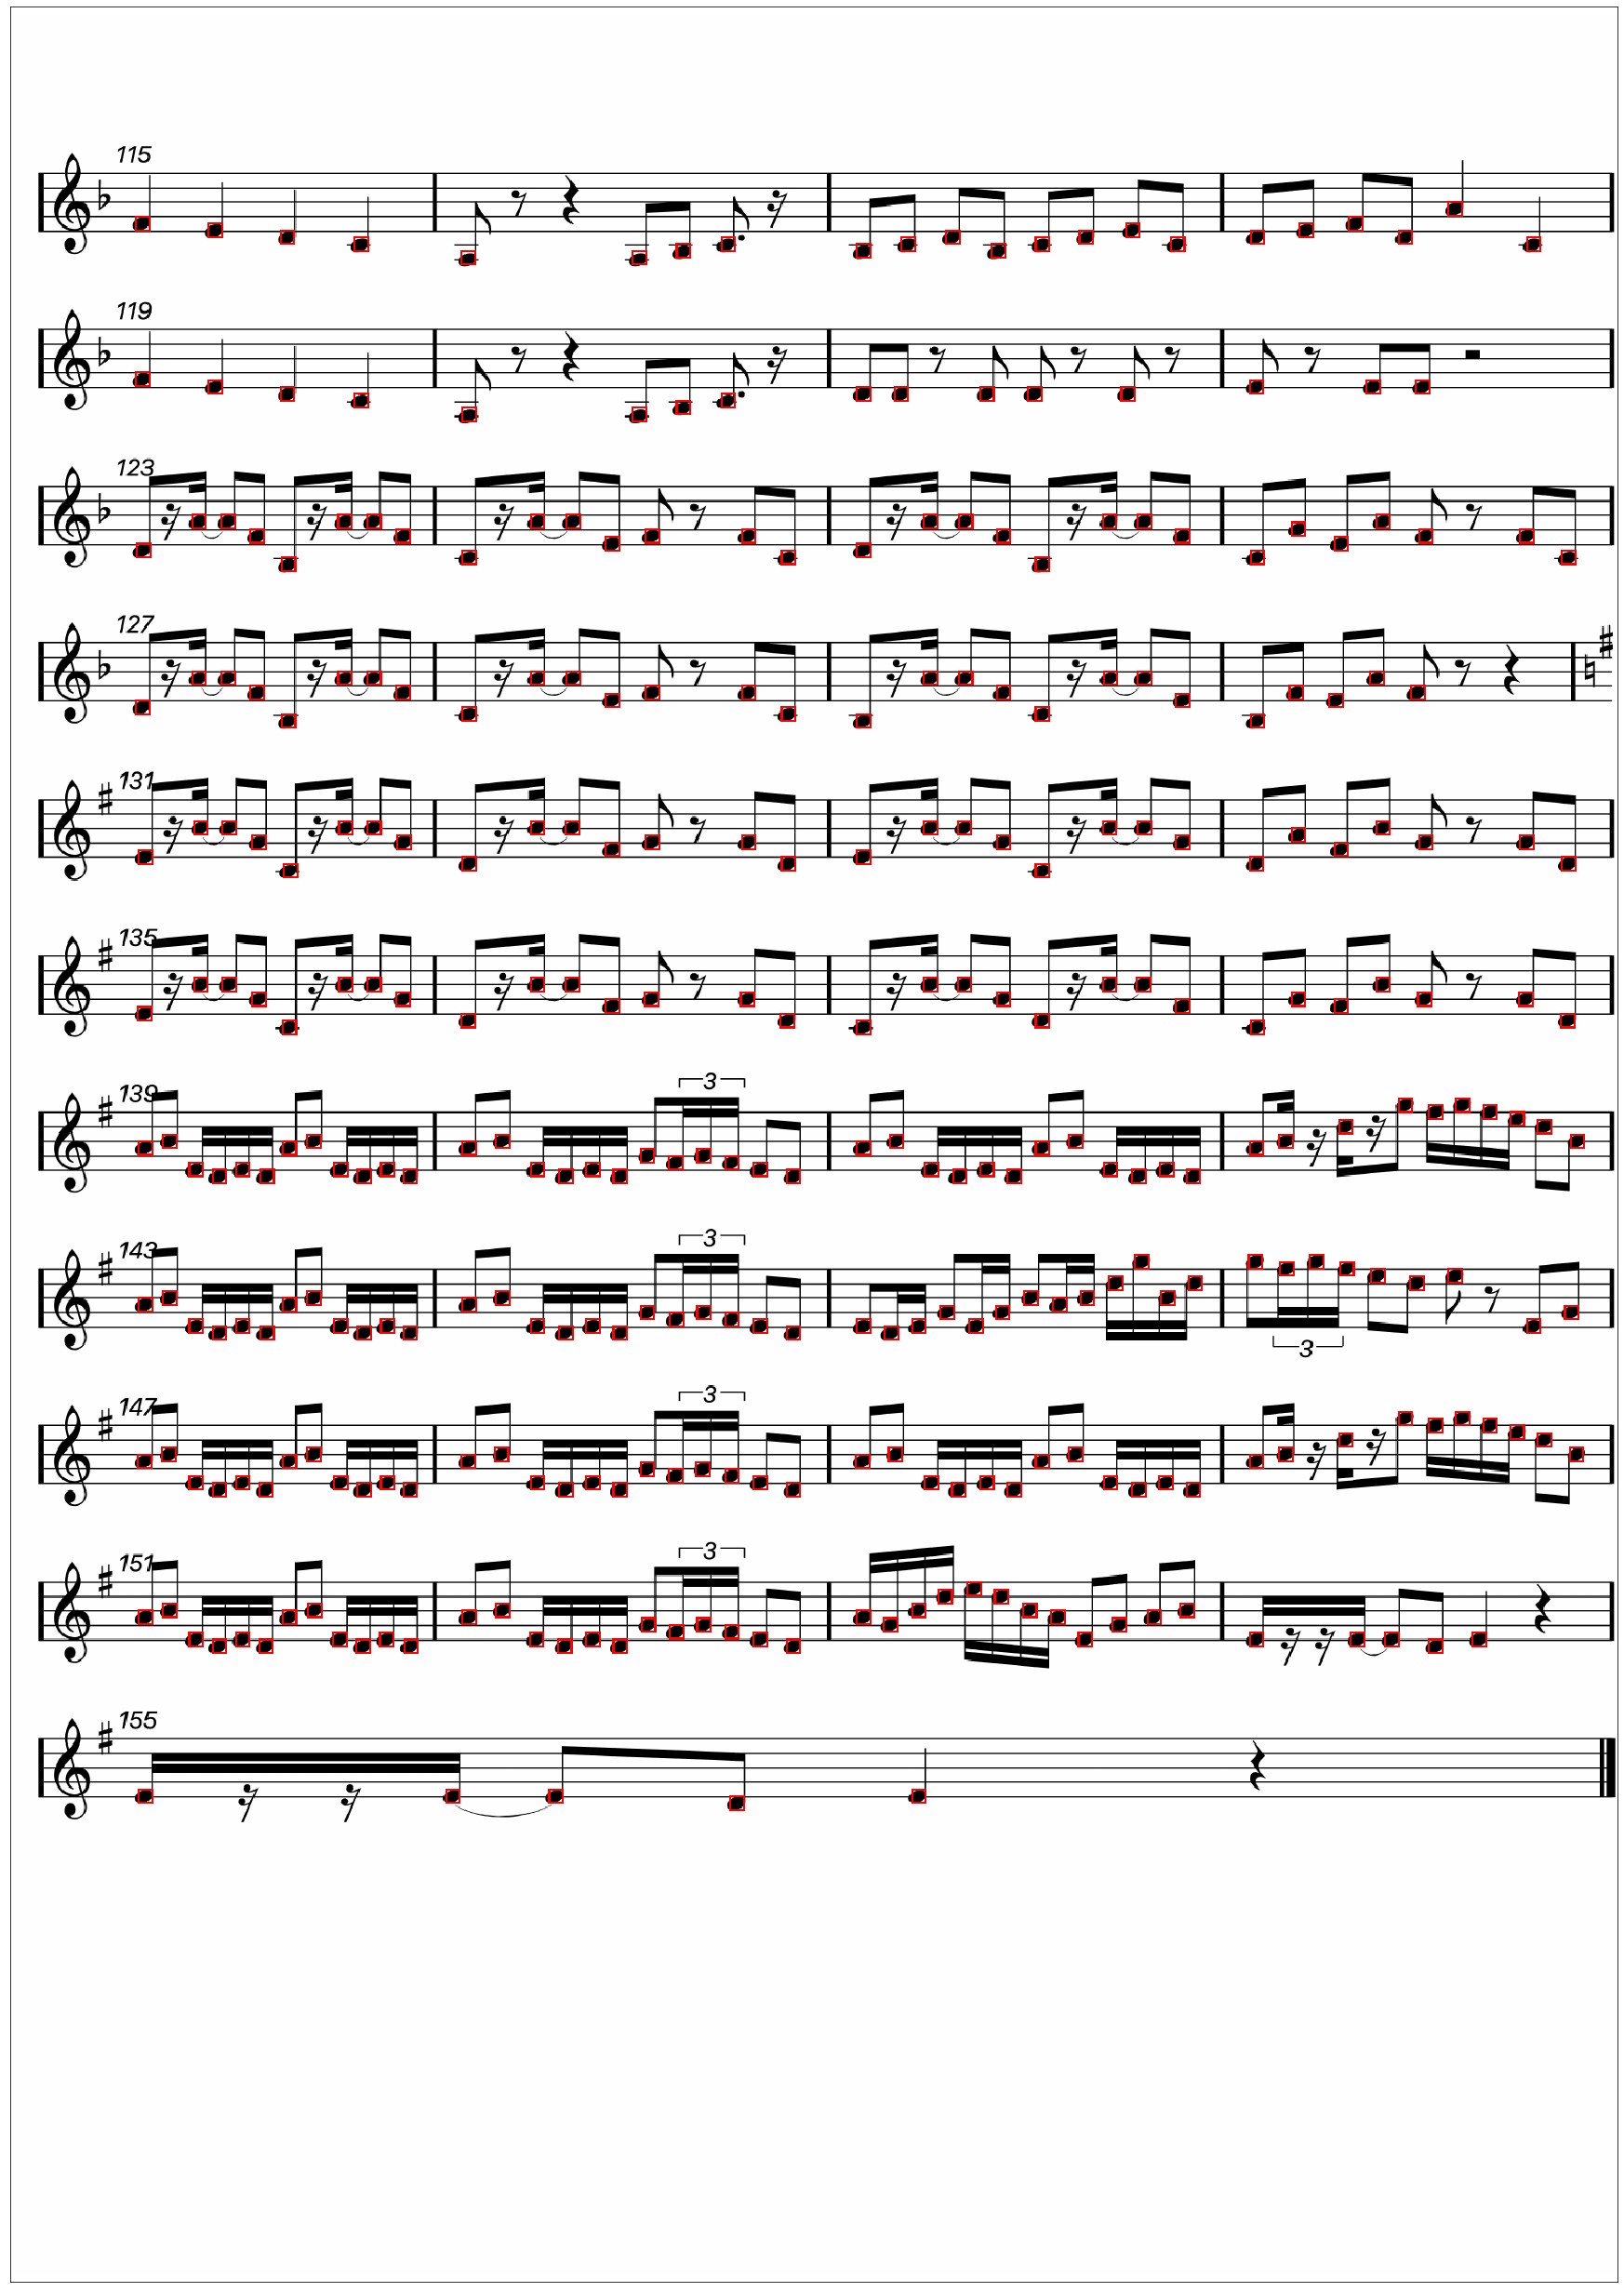

In [953]:
#検出結果の表示
from PIL import Image, ImageDraw
img_draw = Image.fromarray(img_origin) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意
print(len(info_black_note))
# font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
# font_size = 25       # フォントサイズ
# fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義
for idx,a in enumerate(info_black_note):
    draw.rectangle([(a[1]-gosen_interval/2, a[0]-gosen_interval/2), (a[1]+gosen_interval/2, a[0]+gosen_interval/2)]\
                   , outline='red',  width=2)
#     draw.text((a[1]-gosen_interval/2,  a[0]-gosen_interval/2),'{0}'.format(idx), font=fnt,fill=222)
img_draw.show()
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

### 6.3白符頭の認識
3種類のテンプレート(二分音符2種，全音符1種)を当てはめていく．円の外周上に存在する黒画素の割合と，円内の白画素の割合から白符頭であるかどうかを判断する．

リサイズ前のサイズ (15, 19)


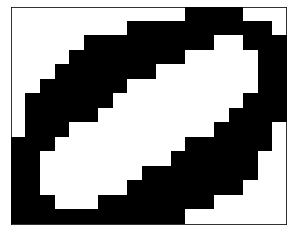

リサイズ後のサイズ (16, 20)


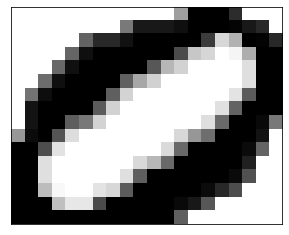

二値化後のサイズ (16, 20)


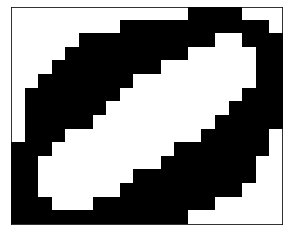

In [954]:
'''二分音符'''
#二分音符のシェイプ (15, 19)
#縦/横 0.7894736842105263
#テンプレートの読み込み

template_nibu = cv2.imread("./../template/template_nibu.png",0)
print("リサイズ前のサイズ",template_nibu.shape)
plt.imshow(template_nibu, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_nibu = cv2.resize(template_nibu , (( int(gosen_interval*1.38),int(gosen_interval*1.09))))
print("リサイズ後のサイズ",template_nibu.shape)
plt.imshow(template_nibu, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値100を超えた画素を255にする。)
ret, template_nibu = cv2.threshold(template_nibu, threshold, 255, cv2.THRESH_BINARY)
# template_nibu = Make_Binomial_Image(template_nibu)
print("二値化後のサイズ",template_nibu.shape)
plt.imshow(template_nibu, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

リサイズ前のサイズ (15, 19)


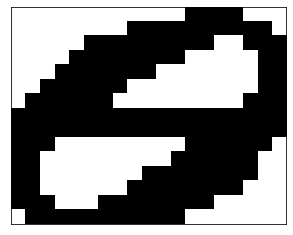

リサイズ後のサイズ (16, 20)


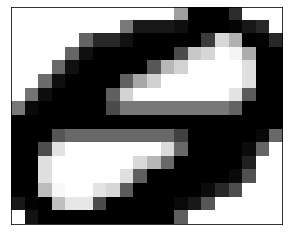

二値化後のサイズ (16, 20)


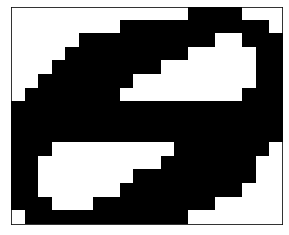

In [955]:
'''二分音符_2'''
#二分音符のシェイプ (15, 19)
#縦/横 0.7894736842105263
#テンプレートの読み込み

template_nibu_2 = cv2.imread("./../template/template_nibu_2.png",0)
print("リサイズ前のサイズ",template_nibu_2.shape)
plt.imshow(template_nibu_2, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_nibu_2 = cv2.resize(template_nibu_2 , (( int(gosen_interval*1.38),int(gosen_interval*1.09))))
print("リサイズ後のサイズ",template_nibu_2.shape)
plt.imshow(template_nibu_2, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値100を超えた画素を255にする。)
ret, template_nibu_2 = cv2.threshold(template_nibu_2, threshold, 255, cv2.THRESH_BINARY)
# template_nibu = Make_Binomial_Image(template_nibu)
print("二値化後のサイズ",template_nibu_2.shape)
plt.imshow(template_nibu_2, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

リサイズ前のサイズ (16, 27)


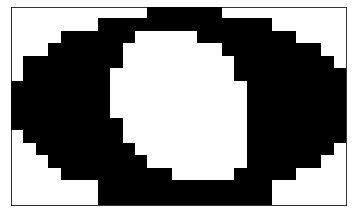

リサイズ後のサイズ (17, 28)


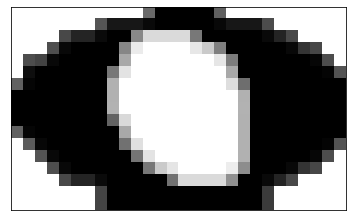

二値化後のサイズ (17, 28)


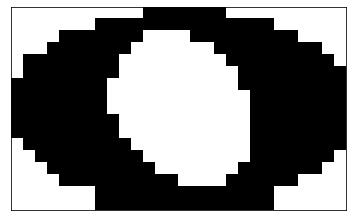

In [956]:
'''全音符'''
#全音符のシェイプ (16, 27)
#縦/横 0.5925925925925926

template_zen = cv2.imread("./../template/template_zen.png",0)
print("リサイズ前のサイズ",template_zen.shape)
plt.imshow(template_zen, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを五線間隔に合わせてリサイズする．
#サイズの比率は手打ち．．
template_zen = cv2.resize(template_zen , (( int(gosen_interval*1.95),int(gosen_interval*1.15))))
print("リサイズ後のサイズ",template_zen.shape)
plt.imshow(template_zen, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

#テンプレートを二値化
# 閾値の設定
threshold = 150
# 二値化(閾値100を超えた画素を255にする。)
# template_zen = Make_Binomial_Image(template_zen)
ret, template_zen = cv2.threshold(template_zen, threshold, 255, cv2.THRESH_BINARY)
print("二値化後のサイズ",template_zen.shape)
plt.imshow(template_zen, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

100%|██████████| 17/17 [00:00<00:00, 12091.43it/s]

nibu_onpu
(16, 20)


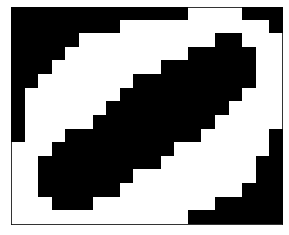

nibu_onpu_2
(16, 20)


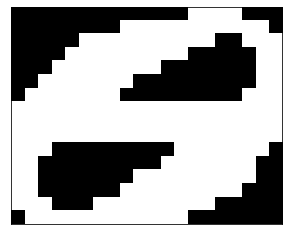

zen_onpu
(17, 28)


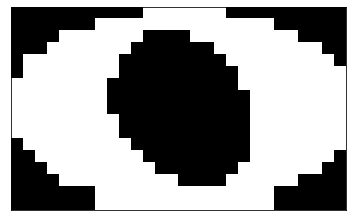

In [957]:
template_whitenote = {'nibu_onpu':template_nibu,'nibu_onpu_2':template_nibu_2, 'zen_onpu':template_zen}
turncolor_template_whitenote = {'nibu_onpu':Monochrome_Inversion(template_nibu)\
                                          ,'nibu_onpu_2':Monochrome_Inversion(template_nibu_2)\
                                            ,'zen_onpu':Monochrome_Inversion(template_zen)}
for k,v in turncolor_template_whitenote.items():
    print(k)
    print(v.shape)
    plt.imshow(v, cmap = "gray")
    plt.xticks([]), plt.yticks([])
    plt.show()

In [958]:
def Detect_Whitenote(turncolor_img_delete,data,turncolor_template,searchline,gosen_interval,line_id):
    """
    ラベリング画像内の白符頭を検出し，座標を保存する．
    
    1.探索線上を舐めて行きながら，ラベリング画像の切り出しとテンプレートを掛け算．
    2.テンプレートの円周と円内に分ける．円周での黒画素の一致率を確かめる．円内での白画素の割合を調べる．
    3.断定された白符頭の座標を保存．
    4.上下左右gosen_interval/2分内にある検出は同一音符とみなし，重複を削除
    
    入力: 五線除去後の反転楽譜，ラベリング画像の情報，反転テンプレート画像，探索線情報，五線間隔，対象の五線id
    出力:　抽出された白符頭の座標
    """
#準備
    r = {}
    search_range_x = {}
    num_pixel = {}
    contours = {}#(y,x)
    insides = {}#(y,x)
    #横の探索範囲を定義(探索線の削減)
    dummy = searchline[line_id]
    searchline_del = dummy[(dummy>=data[1]) & (dummy<=data[1]+data[3])]
    for temp_name,temp in turncolor_template.items():
        #横の探索範囲を定義(黒丸画像の半円分は削る)
        r[temp_name] = [int((temp.shape[0]+1)/2) ,int((temp.shape[1]+1)/2) ]#半径
        search_range_x[temp_name] = [data[0] + r[temp_name][1] -2 ,data[0] +data[2] - r[temp_name][1] + 2]
        #テンプレート画像の黒部分の座標を検出
        #円内部の白部分の座標も検出
        kari_contours = []
        kari_insides = []
        for i in range(temp.shape[0]):
            flag = False
            for j in range(temp.shape[1]):
                if temp[i,j] == 255:
                    kari_contours.append([i,j])
                if j>0 and temp[i,j-1]==255 and temp[i,j]!=255:#白から黒に変わる時
                    flag = True
                elif j>0 and temp[i,j-1]!=255 and temp[i,j]==255:#黒から白に変わる時
                    flag = False
                if flag==True:
                    kari_insides.append([i,j])
        contours[temp_name] = kari_contours
        insides[temp_name] = kari_insides 
                
#メイン処理    
    search_data = []#座標を保存
    score_edge = {}
    score_inside = {}
    for line in searchline_del:
        for temp_name,temp in turncolor_template.items():
            for x in range(search_range_x[temp_name][0],search_range_x[temp_name][1]):
                #
                labeling_img_part  = turncolor_img_delete[line-r[temp_name][0]:line+r[temp_name][0], x - r[temp_name][1] : x + r[temp_name][1]]
                
                #円周の一致率を計算
                score_edge[temp_name] = 0
                for edge in contours[temp_name]:
                    score_edge[temp_name] += labeling_img_part[edge[0],edge[1]]
                score_edge[temp_name] /= len(contours[temp_name])*255
                
                #円内の一致率を計算
                score_inside[temp_name] = 0
                for ins in insides[temp_name]:
                    score_inside[temp_name] += labeling_img_part[ins[0],ins[1]]
                score_inside[temp_name] /= len(insides[temp_name])*255
                score_inside[temp_name] = 1 - score_inside[temp_name]
                
                #円周と円内でともに一致率が0.75を超えたら保存
                if (score_edge[temp_name]>=0.75 and score_inside[temp_name]>=0.75):
                    search_data.append([line, x, line_id])
    #検出できなかった時の例外処理            
    if len(search_data)==0:
        return search_data
    
    ##上下左右に音符があっても五線間隔gosen_interval/2くらいは離れているだろう..
    #上下左右gosen_interval/2分内にある検出は同一音符とみなす．
    #重複を削除
    search_data = np.array(search_data)
    while True:
        count_del = 0
        ##---x方向---##
        search_data = search_data[np.argsort(search_data[:,1],axis=0)]#x座標の昇順に従って並び替え
        i=0
        while not (search_data[-1] == search_data[i]).all(): 
            dif_x = abs(search_data[i+1,1] - search_data[i,1])
            dif_y = abs(search_data[i+1,0] - search_data[i,0])
            if (dif_x <= (gosen_interval-1)/2) and (dif_y<=(gosen_interval-1)/2):
                search_data = np.delete(search_data,obj=i,axis=0)
                i -= 1
            i += 1
        ##---y方向---##
        search_data = search_data[np.argsort(search_data[:,0],axis=0)]#y座標の昇順に従って並び替え
        i=0
        while not ((search_data[-1] == search_data[i]).all() and (i+1==search_data.shape[0])): 
            dif_x = abs(search_data[i+1,1] - search_data[i,1])
            dif_y = abs(search_data[i+1,0] - search_data[i,0])
            if (dif_x <= (gosen_interval-1)/2) and (dif_y<=(gosen_interval-1)/2):
                search_data = np.delete(search_data,obj=i,axis=0)
                i -= 1
            i += 1
        if count_del==0:
            break
    return search_data

In [959]:
#白符頭の検出実行
info_white_note = []
upper_hypara = 4
lower_hypara = 1 
for i in range(len(searchline)):
    print('------------{0}行目-------------'.format(i+1))
    for idx in range(1,data.shape[0]-1):
        #探索線(半球分+する)の範囲内にラベリング画像が収まっていれば探索開始
        if (searchline[i][0] - upper_hypara*int(gosen_interval)<= data[idx,1]) \
            and (searchline[i][-1] +  lower_hypara*int(gosen_interval) >=data[idx,1]+data[idx,3]):
            print(idx,data[idx])
            
            res = Detect_Whitenote(turncolor_img_delete,data[idx],turncolor_template_whitenote,searchline,gosen_interval,i)#探索
            if len(res)!=0:
                for r in res.tolist():
                    info_white_note.append(r)
                print(res)
                labeling_img  = img_delete[data[idx,1]:data[idx,1]+data[idx,3],data[idx,0]:data[idx,0]+data[idx,2]]
                plt.imshow(labeling_img,cmap='gray')
                plt.show()
info_white_note = np.array(info_white_note)

------------1行目-------------
1 [111 144   8  18  58]
2 [121 144   8  18  56]
3 [131 144  13  18  83]
4 [  45  152   37  102 1091]
5 [1475  159   19   59  277]
6 [ 29 172   5  61 304]
7 [434 172   5  61 305]
8 [839 172   5  61 305]
9 [1243  172    6   61  246]
10 [1373  172   69   74 1091]
11 [1643  172    5   61  245]
12 [126 174  18  59 313]
13 [568 174  17  51 319]
14 [ 91 179  12  31 142]
15 [1143  179   66   74 1005]
16 [1270  179   70   67 1008]
17 [200 182  19  57 289]
18 [958 187  67  74 997]
19 [1046  187   68   66  926]
20 [275 189  18  57 252]
21 [778 189  20  39 191]
22 [515 190  16  28 126]
23 [866 194  67  67 916]
24 [346 196  25  57 249]
25 [722 196  38  57 429]
26 [1550  196   25   57  248]
27 [456 201  38  67 392]
28 [632 201  70  67 970]
29 [749 236   6   6  30]
30 [ 55 239  12  15 135]
------------2行目-------------
29 [749 236   6   6  30]
30 [ 55 239  12  15 135]
31 [111 305   8  17  56]
32 [122 305   8  17  54]
33 [131 305  14  18 116]
34 [  45  312   37  102 1071]
3

275 [ 531 1152  104   59 2551]
276 [ 936 1152  104   59 2544]
277 [1120 1152  104   59 2500]
278 [1333 1155   20   38  190]
279 [  55 1204   12   15  136]
------------8行目-------------
279 [  55 1204   12   15  136]
280 [ 713 1257   13   18   98]
281 [ 687 1263    1   11   11]
282 [ 754 1263    1   11   11]
283 [ 113 1270    8   18   58]
284 [ 122 1270   14   18  103]
285 [ 128 1270   45   74  836]
286 [ 180 1276  141   96 3166]
287 [ 461 1276   53   68  831]
288 [  45 1278   37  102 1099]
289 [  91 1281   14   34  228]
290 [ 645 1283  105   76 2442]
291 [ 953 1283   76   82 1624]
292 [1039 1283   76   61 1508]
293 [1126 1284  100   88 2478]
294 [1270 1284  112   75 2620]
295 [1555 1290   58   75  893]
296 [  29 1298    5   61  304]
297 [ 434 1298    5   61  305]
298 [ 839 1298    5   61  305]
299 [1243 1298    6   61  246]
300 [1395 1298   59   67  953]
301 [1475 1298   18   57  413]
302 [1643 1298    5   61  245]
303 [ 760 1305   53   67  856]
304 [ 329 1313   90   59 2316]
305 [ 531 

0


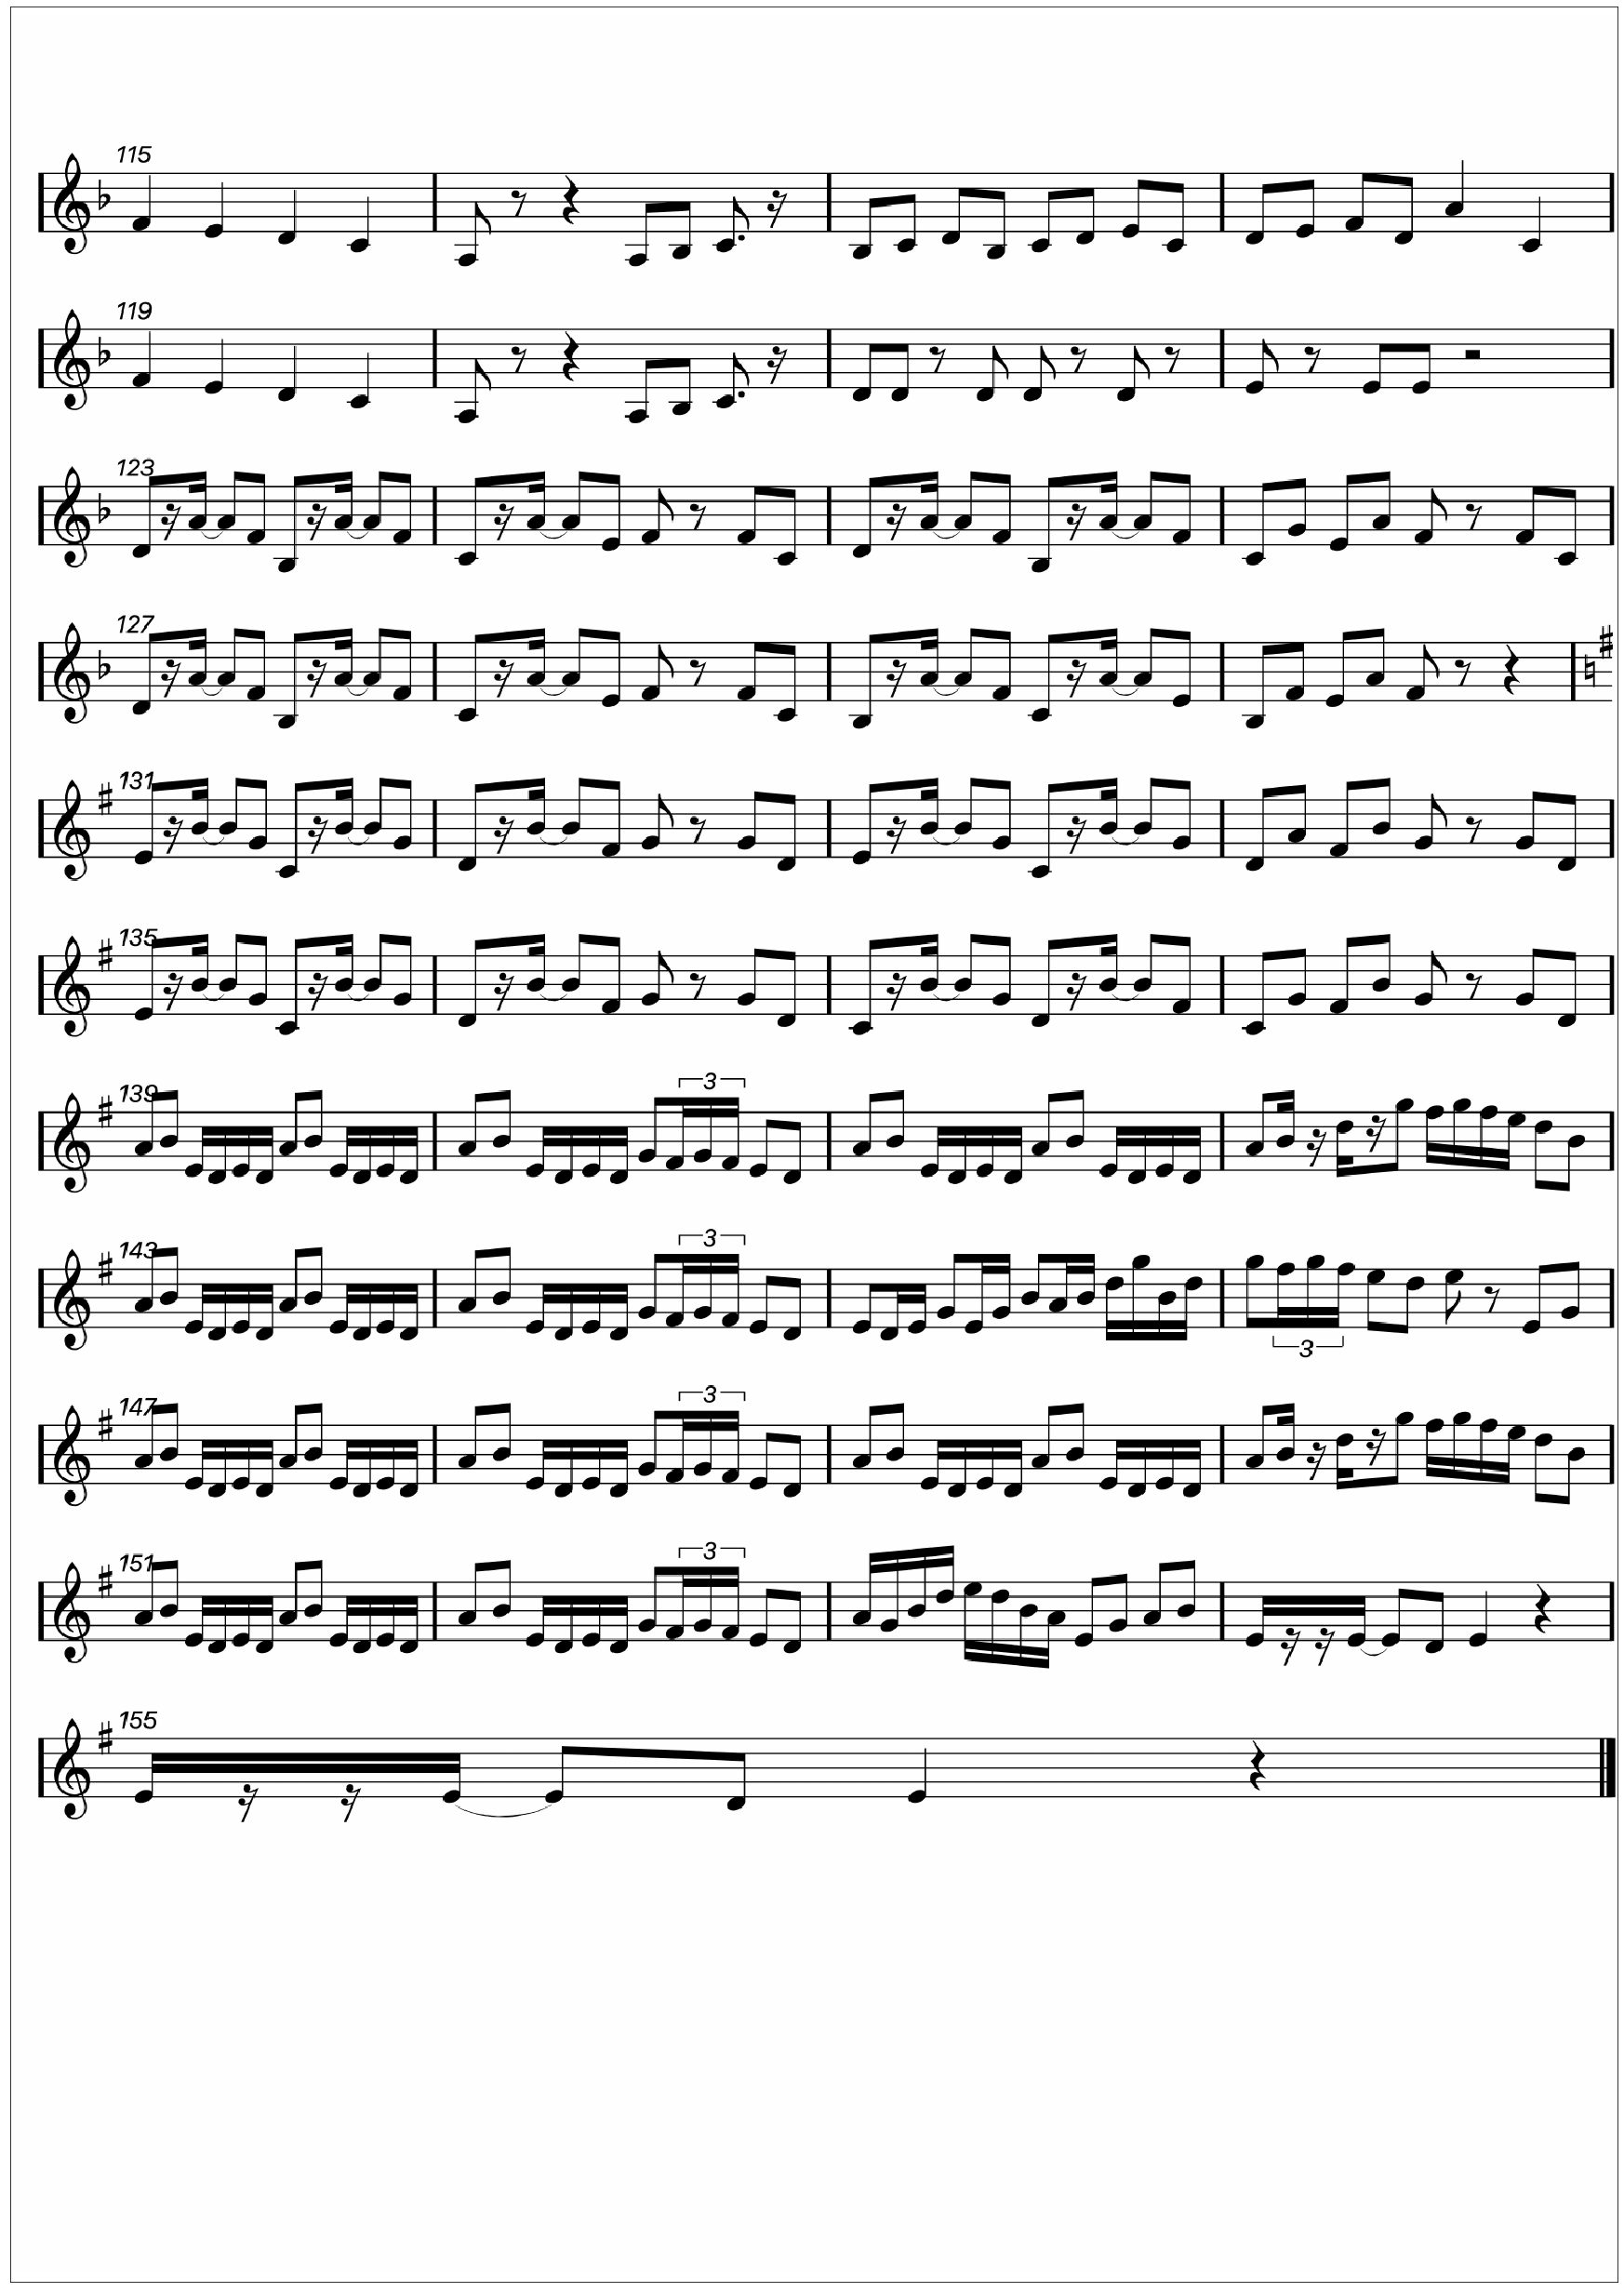

In [960]:
#検出結果の表示
from PIL import Image, ImageDraw
img_draw = Image.fromarray(img_origin) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意
print(len(info_white_note))
# font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
# font_size = 25       # フォントサイズ
# fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義
for idx,a in enumerate(info_white_note):
    draw.rectangle([(a[1]-gosen_interval, a[0]-gosen_interval), (a[1]+gosen_interval, a[0]+gosen_interval)]\
                   , outline='red',  width=2)
#     draw.text((a[1]-gosen_interval/2,  a[0]-gosen_interval/2),'{0}'.format(idx), font=fnt,fill=222)
img_draw.show()
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

**検出した情報を確認**
* 音部記号: [x, y, 幅, 高さ, 記号,五線id]          ※ト音記号:0,ヘ音記号:1　　　※(矩形左上隅の)座標<br>
* 調号記号,臨時記号:<br>
[x, y, 幅, 高さ, 記号,五線id]          ※♮:0, ♯:+1, ♭:-1　　　※(矩形左上隅の)座標<br>
又は<br>
[y,x,記号,五線id] ※中心の座標<br>
* 音符: [y, x, 五線id]                       ※中心の座標

In [961]:
print("------------音部記号--------------")
print(len(info_clef_addid))
print(info_clef_addid)

print("------------調号記号，臨時記号--------------")
print(len(info_key_addid))
print(info_key_addid)
print(len(info_key_addid_center))
print(info_key_addid_center)


print("------------黒符頭--------------")
print(len(info_black_note))
print(info_black_note)

print("------------白符頭--------------")
print(len(info_white_note))
print(info_white_note)

------------音部記号--------------
11
[array([ 45, 152,  37, 102,   0,   0]), array([ 45, 312,  37, 102,   0,   1]), array([ 45, 473,  37, 102,   0,   2]), array([ 45, 634,  37, 102,   0,   3]), array([ 45, 795,  37, 102,   0,   4]), array([ 45, 956,  37, 102,   0,   5]), array([  45, 1117,   37,  102,    0,    6]), array([  45, 1278,   37,  102,    0,    7]), array([  45, 1439,   37,  101,    0,    8]), array([  45, 1599,   37,  102,    0,    9]), array([  45, 1760,   37,  102,    0,   10])]
------------調号記号，臨時記号--------------
15
[array([ 91, 180,   9,  29,  -1,   0]), array([ 91, 341,   9,  29,  -1,   1]), array([ 91, 502,   9,  29,  -1,   2]), array([ 91, 663,   9,  29,  -1,   3]), array([1363, 1166,    9,   29,   -1,    6]), array([1511, 1158,    9,   29,   -1,    6]), array([1363, 1488,    9,   29,   -1,    8]), array([1009, 1667,    9,   29,   -1,    9]), array([ 93, 799,  10,  31,   1,   4]), array([ 93, 960,  10,  31,   1,   5]), array([  93, 1121,   10,   31,    1,    6]), array([

黒符頭と白符頭の情報を統合

In [962]:
if len(info_black_note)!=0 and len(info_white_note)!=0:
    info_note = np.concatenate([info_black_note,info_white_note])
    print('音符の数:',info_note.shape[0])
    print(info_note.shape)
    print(info_note)
elif len(info_black_note)!=0 and len(info_white_note)==0:
    info_note = info_black_note
    print('音符の数:',info_note.shape[0])
    print(info_note.shape)
    print(info_note)
elif len(info_black_note)==0 and len(info_white_note)!=0:
    info_note = info_white_note
    print('音符の数:',info_note.shape[0])
    print(info_note.shape)
    print(info_note)

音符の数: 340
(340, 3)
[[ 209 1485    0]
 [ 224 1383    0]
 [ 238 1434    0]
 ...
 [1840  934   10]
 [1840  139   10]
 [1840  455   10]]


#### 検出した音符情報をもとに小節線の検出結果を修正
検出した音符の位置付近の小節線情報は削除する．(音符の符尾である可能性が高いからである)

In [963]:
for i in range(len(searchline)):
    print('-------------{0}行めの小節線:------------'.format(i+1))
    print(len(info_bar[i]))
    print(info_bar[i])

-------------1行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------2行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------3行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------4行めの小節線:------------
5
[  29  434  839 1244 1604]
-------------5行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------6行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------7行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------8行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------9行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------10行めの小節線:------------
5
[  29  434  839 1244 1644]
-------------11行めの小節線:------------
4
[  29 1634 1641 1647]


In [964]:
def Rivise_bar(info_bar,info_note,searchline,gosen_interval):
    """
    小節線情報の修正．
    検出した音符の位置付近の小節線情報は削除する．
     
    入力：小節線情報，音符情報，探索線
    出力：修正した小節線情報
    """
    info_bar_re =  info_bar
    for gosen_id in range(len(searchline)):
        note_id_group = np.array([note for note in info_note if note[-1]==gosen_id])
#         print(note_id_group)
        print('-------------{0}行目------------'.format(gosen_id+1))
        del_list = []
        for idx,bar in enumerate(info_bar[gosen_id]):
            for note in note_id_group:
                if np.abs(note[1] - bar)<gosen_interval:
                    del_list.append(idx)
        print(info_bar[gosen_id])
        print(del_list)
        info_bar_re[gosen_id] = np.delete(info_bar_re[gosen_id],del_list,axis=0)
        print(len(info_bar_re[gosen_id]),info_bar_re[gosen_id])
            
    return info_bar_re

In [965]:
info_bar_re = Rivise_bar(info_bar,info_note,searchline,gosen_interval)
print(info_bar)

-------------1行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------2行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------3行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------4行目------------
[  29  434  839 1244 1604]
[]
5 [  29  434  839 1244 1604]
-------------5行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------6行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------7行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------8行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------9行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------10行目------------
[  29  434  839 1244 1644]
[]
5 [  29  434  839 1244 1644]
-------------11行目------------
[  29 1634 1641 1647]
[]
4 [  29 1634 1641 1647]
[array([  29,  434,  839, 1244, 1644]), 

## 7.五線譜間隔を利用し，音部記号の情報と各音符の位置情報から音名を対応させる
1. 対応表の定義
2. 音部記号に調号を作用させる
3. ※音部記号が省略されているもの(調号記号の塊として存在)を検出する
4. 作用済みの音部記号の影響を音符に反映させる．
5. (余った)臨時記号を音符に作用させる。<br>

臨時で出てくる音部記号に調号記号が付加されていない場合，それは転調ではなくただ見やすくするためのずらしと見るべき．本当は違うけども......<br>
※調号は形と数が決まっているので，それを利用して臨時記号と区別することができる?

#### 7.1対応表の定義
* 音名インデックスと音名の対応
* 音部記号と音名インデックスの対応
* 探索線と音名インデックスの対応
* Keyの規則(Cメジャーからどれくらい音程が変わるか)
* 音名又は音名インデックスと箏弦の対応<br>
etc...

In [966]:
#音名にインデックスをふる．C1(0)~B8(95)
notename_all = {\
    'C1':0, 'D1b':1, 'D1':2, 'E1b':3, 'E1':4, 'F1':5, 'G1b':6, 'G1':7, 'A1b':8, 'A1':9, 'B1b':10, 'B1':11\
    ,'C2':12, 'D2b':13, 'D2':14, 'E2b':15, 'E2':16, 'F2':17, 'G2b':18, 'G2':19, 'A2b':20, 'A2':21, 'B2b':22, 'B2':23\
    ,'C3':24, 'D3b':25, 'D3':26, 'E3b':27, 'E3':28, 'F3':29, 'G3b':30, 'G3':31, 'A3b':32, 'A3':33, 'B3b':34, 'B3':35 \
    ,'C4':36, 'D4b':37, 'D4':38, 'E4b':39, 'E4':40, 'F4':41, 'G4b':42, 'G4':43, 'A4b':44, 'A4':45, 'B4b':46, 'B4':47 \
    ,'C5':48, 'D5b':49, 'D5':50, 'E5b':51, 'E5':52, 'F5':53, 'G5b':54, 'G5':55, 'A5b':56, 'A5':57, 'B5b':58, 'B5':59 \
    ,'C6':60, 'D6b':61, 'D6':62, 'E6b':63, 'E6':64, 'F6':65, 'G6b':66, 'G6':67, 'A6b':68, 'A6':69, 'B6b':70, 'B6':71 \
    ,'C7':72, 'D7b':73, 'D7':74, 'E7b':75, 'E7':76, 'F7':77, 'G7b':78, 'G7':79, 'A7b':80, 'A7':81, 'B7b':82, 'B7':83 \
    ,'C8':84, 'D8b':85, 'D8':86, 'E8b':87, 'E8':88, 'F8':89, 'G8b':90, 'G8':91, 'A8b':92, 'A8':93, 'B8b':94, 'B8':95}
notename_all_re = {v: k for k, v in notename_all.items()}
print(notename_all)
print(notename_all_re)

{'C1': 0, 'D1b': 1, 'D1': 2, 'E1b': 3, 'E1': 4, 'F1': 5, 'G1b': 6, 'G1': 7, 'A1b': 8, 'A1': 9, 'B1b': 10, 'B1': 11, 'C2': 12, 'D2b': 13, 'D2': 14, 'E2b': 15, 'E2': 16, 'F2': 17, 'G2b': 18, 'G2': 19, 'A2b': 20, 'A2': 21, 'B2b': 22, 'B2': 23, 'C3': 24, 'D3b': 25, 'D3': 26, 'E3b': 27, 'E3': 28, 'F3': 29, 'G3b': 30, 'G3': 31, 'A3b': 32, 'A3': 33, 'B3b': 34, 'B3': 35, 'C4': 36, 'D4b': 37, 'D4': 38, 'E4b': 39, 'E4': 40, 'F4': 41, 'G4b': 42, 'G4': 43, 'A4b': 44, 'A4': 45, 'B4b': 46, 'B4': 47, 'C5': 48, 'D5b': 49, 'D5': 50, 'E5b': 51, 'E5': 52, 'F5': 53, 'G5b': 54, 'G5': 55, 'A5b': 56, 'A5': 57, 'B5b': 58, 'B5': 59, 'C6': 60, 'D6b': 61, 'D6': 62, 'E6b': 63, 'E6': 64, 'F6': 65, 'G6b': 66, 'G6': 67, 'A6b': 68, 'A6': 69, 'B6b': 70, 'B6': 71, 'C7': 72, 'D7b': 73, 'D7': 74, 'E7b': 75, 'E7': 76, 'F7': 77, 'G7b': 78, 'G7': 79, 'A7b': 80, 'A7': 81, 'B7b': 82, 'B7': 83, 'C8': 84, 'D8b': 85, 'D8': 86, 'E8b': 87, 'E8': 88, 'F8': 89, 'G8b': 90, 'G8': 91, 'A8b': 92, 'A8': 93, 'B8b': 94, 'B8': 95}
{0: 'C1',

In [967]:
#音名ごとに音名インデックスをグルーピング
notename = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A','Bb','B']
eachnote = {}
for idx,note in enumerate(notename):
    eachnote[note] = list(range(idx,12*8+idx,12))
eachnote['Bdash'] = [0,11, 23, 35, 47, 59, 71, 83]
eachnote['C#'] = list(range(1,12*8+1,12))
eachnote['D#'] = list(range(3,12*8+3,12))
eachnote['F#'] = list(range(6,12*8+6,12))
eachnote['G#'] = list(range(8,12*8+8,12))
eachnote['A#'] = list(range(10,12*8+10,12))
eachnote['Cdash'] = [12, 24, 36, 48, 60, 72, 84,95]
print(eachnote)

{'C': [0, 12, 24, 36, 48, 60, 72, 84], 'Db': [1, 13, 25, 37, 49, 61, 73, 85], 'D': [2, 14, 26, 38, 50, 62, 74, 86], 'Eb': [3, 15, 27, 39, 51, 63, 75, 87], 'E': [4, 16, 28, 40, 52, 64, 76, 88], 'F': [5, 17, 29, 41, 53, 65, 77, 89], 'Gb': [6, 18, 30, 42, 54, 66, 78, 90], 'G': [7, 19, 31, 43, 55, 67, 79, 91], 'Ab': [8, 20, 32, 44, 56, 68, 80, 92], 'A': [9, 21, 33, 45, 57, 69, 81, 93], 'Bb': [10, 22, 34, 46, 58, 70, 82, 94], 'B': [11, 23, 35, 47, 59, 71, 83, 95], 'Bdash': [0, 11, 23, 35, 47, 59, 71, 83], 'C#': [1, 13, 25, 37, 49, 61, 73, 85], 'D#': [3, 15, 27, 39, 51, 63, 75, 87], 'F#': [6, 18, 30, 42, 54, 66, 78, 90], 'G#': [8, 20, 32, 44, 56, 68, 80, 92], 'A#': [10, 22, 34, 46, 58, 70, 82, 94], 'Cdash': [12, 24, 36, 48, 60, 72, 84, 95]}


In [968]:
#keyのきそく,Cメジャーからどれくらい音程が変わるか
#-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7
#Fb,Cb,Gb,Db,Ab,Eb,Bb, C,F#,C#,G#,D#,A#,E#,B#
print('--------------------Keyの規則--------------------')
key_dic = {\
            -1:[eachnote['B'],eachnote['Bb']]\
           , -2:[eachnote['B']+eachnote['E'],eachnote['Bb']+eachnote['Eb']]\
           , -3:[eachnote['B']+eachnote['E']+eachnote['A'],eachnote['Bb']+eachnote['Eb']+eachnote['Ab']]\
           , -4:[eachnote['B']+eachnote['E']+eachnote['A']+eachnote['G'],\
                 eachnote['Bb']+eachnote['Eb']+eachnote['Ab']+eachnote['Gb']]\
           , -5:[eachnote['B']+eachnote['E']+eachnote['A']+eachnote['G']+eachnote['D'],\
                 eachnote['Bb']+eachnote['Eb']+eachnote['Ab']+eachnote['Gb']+eachnote['Db']]\
           , -6:[eachnote['B']+eachnote['E']+eachnote['A']+eachnote['G']+eachnote['D']+eachnote['C'],\
                 eachnote['Bb']+eachnote['Eb']+eachnote['Ab']+eachnote['Gb']+eachnote['Db']+eachnote['Bdash']]\
           , -7:[eachnote['B']+eachnote['E']+eachnote['A']+eachnote['G']+eachnote['D']+eachnote['C']+eachnote['F'],\
                 eachnote['Bb']+eachnote['Eb']+eachnote['Ab']+eachnote['Gb']+eachnote['Db']+eachnote['Bdash']+eachnote['E']]\
           , 0:0\
           , 1:[eachnote['F'],eachnote['F#']]\
           , 2:[eachnote['F']+eachnote['C'],eachnote['F#']+eachnote['C#']]\
           , 3:[eachnote['F']+eachnote['C']+eachnote['G'],eachnote['F#']+eachnote['C#']+eachnote['G#']]\
           , 4:[eachnote['F']+eachnote['C']+eachnote['G']+eachnote['D'],\
                eachnote['F#']+eachnote['C#']+eachnote['G#']+eachnote['D#']]\
           , 5:[eachnote['F']+eachnote['C']+eachnote['G']+eachnote['D']+eachnote['A'],\
                eachnote['F#']+eachnote['C#']+eachnote['G#']+eachnote['D#']+eachnote['A#']]\
           , 6:[eachnote['F']+eachnote['C']+eachnote['G']+eachnote['D']+eachnote['A']+eachnote['E'],\
                eachnote['F#']+eachnote['C#']+eachnote['G#']+eachnote['D#']+eachnote['A#']+eachnote['F']]\
           , 7:[eachnote['F']+eachnote['C']+eachnote['G']+eachnote['D']+eachnote['A']+eachnote['E']+eachnote['B'],\
                eachnote['F#']+eachnote['C#']+eachnote['G#']+eachnote['D#']+eachnote['A#']+eachnote['F']+eachnote['Cdash']]\
          }
print(key_dic)

--------------------Keyの規則--------------------
{-1: [[11, 23, 35, 47, 59, 71, 83, 95], [10, 22, 34, 46, 58, 70, 82, 94]], -2: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87]], -3: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92]], -4: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93, 7, 19, 31, 43, 55, 67, 79, 91], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92, 6, 18, 30, 42, 54, 66, 78, 90]], -5: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93, 7, 19, 31, 43, 55, 67, 79, 91, 2, 14, 26, 38, 50, 62, 74, 86], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92, 6, 18, 30, 42, 54, 66, 78,

In [969]:
#探索線と同時に探索線に対応する音名インデックスの配列を作る．
r = len(searchline[0])
if r==9:#n=0
    noteindex_toonkingou = np.array([28,29,31,33,35,36,38,40,41])
    noteindex_heonkingou = np.array([31,33,35,36,38,40,41,43,45])
elif r==13:#n=1
    noteindex_toonkingou = np.array([24,26,28,29,31,33,35,36,38,40,41,43,45])
    noteindex_heonkingou = np.array([28,29,31,33,35,36,38,40,41,43,45,47,48])
elif r==17:#n=2
    noteindex_toonkingou = np.array([21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48])
    noteindex_heonkingou = np.array([24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52])
elif r==21:#n=3
    noteindex_toonkingou = np.array([17,19,21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52])
    noteindex_heonkingou = np.array([21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52,53,55])
elif r==25:#n=4
    noteindex_toonkingou = np.array([14,16,17,19,21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52,53,55])
    noteindex_heonkingou = np.array([17,19,21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52,53,55,57,59])
elif r==29:#n=5
    noteindex_toonkingou = np.array([11,12,14,16,17,19,21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52,53,55,57,59])
    noteindex_heonkingou = np.array([14,16,17,19,21,23,24,26,28,29,31,33,35,36,38,40,41,43,45,47,48,50,52,53,55,57,59,60,62])
noteindex = {}
noteindex[0] = noteindex_toonkingou[::-1]
noteindex[1] = noteindex_heonkingou[::-1]
print('1行内の探索線の本数',len(searchline[0]))
print('探索線',searchline)
print('------------------------------------------')
# print(notename)
# print(notename_jp)
print('音名インデックスと音名の対応',notename_all)
print('音部記号と音名インデックスの対応：',noteindex)

1行内の探索線の本数 25
探索線 [array([116, 123, 130, 137, 144, 151, 158, 165, 172, 179, 187, 194, 202,
       209, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287]), array([277, 284, 291, 298, 305, 312, 319, 326, 333, 340, 348, 355, 362,
       369, 377, 384, 392, 399, 406, 413, 420, 427, 434, 441, 448]), array([438, 445, 452, 459, 466, 473, 480, 487, 494, 501, 509, 516, 523,
       530, 538, 545, 553, 560, 567, 574, 581, 588, 595, 602, 609]), array([599, 606, 613, 620, 627, 634, 641, 648, 655, 662, 670, 677, 684,
       691, 699, 706, 714, 721, 728, 735, 742, 749, 756, 763, 770]), array([760, 767, 774, 781, 788, 795, 802, 809, 816, 823, 831, 838, 845,
       852, 860, 867, 875, 882, 889, 896, 903, 910, 917, 924, 931]), array([ 920,  927,  934,  941,  948,  955,  962,  969,  976,  983,  991,
        998, 1006, 1013, 1021, 1028, 1036, 1043, 1050, 1057, 1064, 1071,
       1078, 1085, 1092]), array([1081, 1088, 1095, 1102, 1109, 1116, 1123, 1130, 1137, 1144, 1152,
       1159, 1167, 1174, 1182,

In [970]:
#箏弦と音名の対応表(臨時記号のも対応できる)
t = notename_all.copy()
string_number_table_1 = {'一':t['A2'], '二':t['B2b'], '三':t['C3'], '四':t['D3'], '五':t['E3'], '六':t['F3']\
                         ,'七':t['G3'], '八':t['A3'],'九':t['B3b'],'十':t['C4'] ,'斗':t['D4'], '為':t['E4'], '巾':t['F4']}
# string_number_table_rinji = {'ｦ一':t['A3b'],'ｦ三':t['B3'], 'ｦ四':t['D4b'], 'ｦ五':t['E4b'], 'ｦ七':t['G4b']\
#                              , 'ｦ八':t['A4b'],'ｦ十':t['B3'],'ｦ斗':t['D5b'], 'ｦ為':t['E5b'], 'ｦ巾':t['F5']}
# string_number_table_1.update(string_number_table_rinji)
string_number_table_kari_1 = string_number_table_1.copy()
for k,v in notename_all.items():
    flag = True
    for w in string_number_table_1.values():
        if v==w:
            flag = False
    if flag==True:
        string_number_table_kari_1['del_'+k] = v
string_number_table_1 = string_number_table_kari_1.copy()
print(string_number_table_1)
string_number_table_1_re = {v: k for k, v in string_number_table_1.items()}
print(string_number_table_1_re)

{'一': 21, '二': 22, '三': 24, '四': 26, '五': 28, '六': 29, '七': 31, '八': 33, '九': 34, '十': 36, '斗': 38, '為': 40, '巾': 41, 'del_C1': 0, 'del_D1b': 1, 'del_D1': 2, 'del_E1b': 3, 'del_E1': 4, 'del_F1': 5, 'del_G1b': 6, 'del_G1': 7, 'del_A1b': 8, 'del_A1': 9, 'del_B1b': 10, 'del_B1': 11, 'del_C2': 12, 'del_D2b': 13, 'del_D2': 14, 'del_E2b': 15, 'del_E2': 16, 'del_F2': 17, 'del_G2b': 18, 'del_G2': 19, 'del_A2b': 20, 'del_B2': 23, 'del_D3b': 25, 'del_E3b': 27, 'del_G3b': 30, 'del_A3b': 32, 'del_B3': 35, 'del_D4b': 37, 'del_E4b': 39, 'del_G4b': 42, 'del_G4': 43, 'del_A4b': 44, 'del_A4': 45, 'del_B4b': 46, 'del_B4': 47, 'del_C5': 48, 'del_D5b': 49, 'del_D5': 50, 'del_E5b': 51, 'del_E5': 52, 'del_F5': 53, 'del_G5b': 54, 'del_G5': 55, 'del_A5b': 56, 'del_A5': 57, 'del_B5b': 58, 'del_B5': 59, 'del_C6': 60, 'del_D6b': 61, 'del_D6': 62, 'del_E6b': 63, 'del_E6': 64, 'del_F6': 65, 'del_G6b': 66, 'del_G6': 67, 'del_A6b': 68, 'del_A6': 69, 'del_B6b': 70, 'del_B6': 71, 'del_C7': 72, 'del_D7b': 73, 'del_D7':

#### 7.2 音部記号に調号を作用させる<br>
音部記号: [x, y, 幅, 高さ, 記号, 調号数, 五線id]   に変化<br>
作用させた調号は削除

In [971]:
def Key_Act_On_Clef(info_clef_addid,info_key_addid,flag):
    """
    音部記号に調号を作用させる．
    作用させた調号は削除する．
    ※フラグが立っていれば，臨時音部記号で調号がついていないものは，転調ではなく左端の音部記号と同じ調とする．本来は間違い．．．
    
    入力：音部記号情報，調号記号情報，探索線
    出力：調情報が付加された音部記号情報，削除後の調号情報
    """
    #音部記号の近くにある調合記号数の情報を捉える．
    info_clef_key  = []
    del_list = []
    for i,clef in enumerate(info_clef_addid):
        print(clef)
        clef = np.insert(clef,-1,0)#res[-2]のところにkeyの情報が入るようにする
        for j,key in enumerate(info_key_addid):
            if (clef[-1]==key[-1]) and ((clef[0]+4*clef[2]>=key[0]) and (clef[0]-4*clef[2]<=key[0])):
                clef[-2] += key[-2]
                del_list.append(j)
        info_clef_key.append(clef)
        print(clef)
        print('\n')
        
    #作用させた調号記号は削除
    info_key_addid_re = [key for i,key in enumerate(info_key_addid) if not any([i == j for j in del_list])]
    info_key_addid_center_re = [key for i,key in enumerate(info_key_addid_center) if not any([i == j for j in del_list])]
    
    #フラグが立っていれば，臨時音部記号で調号がついていないものは，転調ではなく左端の音部記号と同じ調とする
    if flag==True:
        result = []
        for gosen_id,gosen in enumerate(searchline):
            clef_key = [clef for i,clef in enumerate(info_clef_key) if clef[-1]==gosen_id]
            if len(clef_key)!=0:
                min_clef = clef_key[0]
                for i,clef in enumerate(clef_key):
                    if min_clef[0]>clef[0]:
                        min_clef = clef
                for i,clef in enumerate(clef_key):
                    if clef[-2]==0:
                        clef[-2] = min_clef[-2]
                    result.append(clef)
        info_clef_key = result
        
    return info_clef_key,info_key_addid_re,info_key_addid_center_re

In [972]:
info_clef_key,info_key_addid_re,info_key_addid_center_re = Key_Act_On_Clef(info_clef_addid,info_key_addid,True)
print('---------調情報が付加された音部記号情報------------------')
print(len(info_clef_key))
print(info_clef_key)
print('----------------削除後の調号情報------------------')
print(len(info_key_addid_re))
print(info_key_addid_re)
print(len(info_key_addid_center_re))
print(info_key_addid_center_re)

[ 45 152  37 102   0   0]
[ 45 152  37 102   0  -1   0]


[ 45 312  37 102   0   1]
[ 45 312  37 102   0  -1   1]


[ 45 473  37 102   0   2]
[ 45 473  37 102   0  -1   2]


[ 45 634  37 102   0   3]
[ 45 634  37 102   0  -1   3]


[ 45 795  37 102   0   4]
[ 45 795  37 102   0   1   4]


[ 45 956  37 102   0   5]
[ 45 956  37 102   0   1   5]


[  45 1117   37  102    0    6]
[  45 1117   37  102    0    1    6]


[  45 1278   37  102    0    7]
[  45 1278   37  102    0    1    7]


[  45 1439   37  101    0    8]
[  45 1439   37  101    0    1    8]


[  45 1599   37  102    0    9]
[  45 1599   37  102    0    1    9]


[  45 1760   37  102    0   10]
[  45 1760   37  102    0    1   10]


---------調情報が付加された音部記号情報------------------
11
[array([ 45, 152,  37, 102,   0,  -1,   0]), array([ 45, 312,  37, 102,   0,  -1,   1]), array([ 45, 473,  37, 102,   0,  -1,   2]), array([ 45, 634,  37, 102,   0,  -1,   3]), array([ 45, 795,  37, 102,   0,   1,   4]), array([ 45, 956,  37, 102,   0

#### 7.3 ※音部記号が省略されているもの(調号記号の塊として存在)を検出する<br>
本来ならちゃんと楽譜書けばこんなものはありえないが，実用上致し方ない．．．<br><br>

検出条件:<br>
同一の臨時記号が2つ以上かたまって存在<br>
かつ，<br>
右近に臨時記号と同音(y座標が同じ)の音符が存在しない<br>
かつ，<br>
左右近に音部記号が存在しない(この条件の逆を満たすものを先に削除したので考えないで良い)<br><br>

以上の条件を満たすものを検出

In [973]:
def Note_StartendIndex_Gosenid(info_note):
    """
    五線idに対応する開始終了のインデックスを求める．
    
    入力：音符情報
    出力：[start,end,音符の数,五線id]
    """
    start = 0
    end = 0
    num_note_id = 0
    gosen_id = 0
    res = []
    for i,note in enumerate(info_note):
        if note[-1]==gosen_id:
            num_note_id += 1
            if i==info_note.shape[0]-1:
                end = i
                res.append([start,end,num_note_id,gosen_id])
                num_note_id = 0
                gosen_id += 1
                start = i         
        else:
            end = i
            res.append([start,end,num_note_id,gosen_id])
            num_note_id = 0
            gosen_id += 1
            start = i
    return res

In [974]:
seindex = Note_StartendIndex_Gosenid(info_note)
print(len(seindex))
print(seindex)

11
[[0, 22, 22, 0], [22, 38, 15, 1], [38, 68, 29, 2], [68, 96, 27, 3], [96, 126, 29, 4], [126, 156, 29, 5], [156, 202, 45, 6], [202, 248, 45, 7], [248, 294, 45, 8], [294, 335, 40, 9], [335, 339, 4, 10]]


In [975]:
print(len(info_clef_key))
print(info_clef_key)

11
[array([ 45, 152,  37, 102,   0,  -1,   0]), array([ 45, 312,  37, 102,   0,  -1,   1]), array([ 45, 473,  37, 102,   0,  -1,   2]), array([ 45, 634,  37, 102,   0,  -1,   3]), array([ 45, 795,  37, 102,   0,   1,   4]), array([ 45, 956,  37, 102,   0,   1,   5]), array([  45, 1117,   37,  102,    0,    1,    6]), array([  45, 1278,   37,  102,    0,    1,    7]), array([  45, 1439,   37,  101,    0,    1,    8]), array([  45, 1599,   37,  102,    0,    1,    9]), array([  45, 1760,   37,  102,    0,    1,   10])]


In [976]:
def Detect_Omit_Clef(info_note,info_clef_key,info_key_addid_re,info_key_addid_center_re,searchline,seindex,gosen_interval):
    """
    音部記号が省略されているもの(調号記号の塊として存在)を検出
    
    入力：
    出力：
    """
    info_clef_key_ = info_clef_key.copy()
    info_no_clef = []
    result_no_clef = []
    for gosen_id,gosen in tqdm(enumerate(searchline)):
        print('------------------{0}行目------------------'.format(gosen_id+1))
        #同じ行の臨時記号だけを抽出する
        key_id_group=[key for i,key in enumerate(info_key_addid_center_re) if key[-1]==gosen_id]
        
        #同じ記号でグルーピングする
        key_sign_group = []#同じ行の同じ臨時記号だけ集めた配列
        start = 0
        t = 0
        key_id_group = np.array(key_id_group)
        for sign in (0,1,-1):
            kari = []
            for j in range(start,key_id_group.shape[0]):
                if key_id_group[j,-2]==sign:
                    kari.append(key_id_group[j])
                    t += 1
            start = t
            key_sign_group.append(np.array(kari))
        
        #右近に対応する音符がない調号を選ぶ．
        #その調号の側にある調号も同じ行，同じ記号の中から検出する．
        key_no_note = []
        for i,key in enumerate(key_id_group):
            print(key)
            flag = True
            for note_idx in range(seindex[gosen_id][0],seindex[gosen_id][1]):
                dif = info_note[note_idx,1] - key[1]
                ##右近に音符あるか,右近の音符と調号が同じ高さか
                if dif>0 and dif<= 5*gosen_interval and (int(info_note[note_idx,0])==int(key[0])):
                    flag = False
                    break
            if flag==True:
                key_no_note.append(key)
        print('右近に対応する音符がない調号：',key_no_note)
        
        
        #同じ行，同じ記号の中で，検出した調号の付近にあるものをまとめる
        #それらまとめたものの最左近の音部記号の情報を利用する．
        res = []
        for i,no_note in enumerate(key_no_note):
            sign = no_note[-2]
            for j, key in enumerate(key_sign_group[sign]):
                dif = np.abs(no_note[1] - key[1])
                ##左右付近にあるか,音高が異なるか
                if (dif <= 4*gosen_interval) and (no_note[0] != key[0]):
                    res.append(no_note)
                    res.append(key)
                    
        #重複を削除
        result = []
        if len(res)!=0:
            res_ = np.array(res)
            res_uni = np.unique(res_,axis=0)
#             print(res)
#             print(res_uni)
            res_uni = res_uni[np.argsort(res_uni[:,1],axis=0)]
#             print(res_uni)
            idx = 0
            kari=[]
            while not (np.all(res_uni[-1]==res_uni[idx])==True):
                if idx==0:
                    kari.append(res_uni[idx])
                dif = np.abs(res_uni[idx+1,1] - res_uni[idx,1])
                
                if (dif<=4*gosen_interval) and (res_uni[idx+1,-2]==res_uni[idx,-2]):
                    kari.append(res_uni[idx+1])
                    idx += 1 
                else:
                    for i in range(idx):
                        res_uni = np.delete(res_uni, 0, axis=0)
                    idx=0
                    result.append(kari)
                    kari = []
                if res_uni.shape[0]==idx+1:
                    result.append(kari)
                    kari = []
        print(result)
        print('\n')
        if len(result)!=0:
            result_no_clef.append(result)
            
        #音部記号が省略されているものを音部記号として保存
        #音部記号のデータ保持の仕方は [x, y, 幅, 高さ, 記号, 調号数, 五線id] ※幅と高さは関係ないのでnanにする
        #同じ行の音部記号を抽出する
        clef_id_group=[v for i,v in enumerate(info_clef_key) if v[-1]==gosen_id]
        print(clef_id_group)
        for no_clef in result: 
            min_difx = 10000000
            for clef in clef_id_group:
                difx = no_clef[0][1] - clef[0]
                if difx>0 and min_difx>= difx:
                    clef_ = clef
            print(clef_)
            sign = no_clef[0][-2]
            num_sign = len(no_clef)
            add_clef = np.array([no_clef[0][1],no_clef[0][0],np.nan,np.nan,clef_[-3],num_sign*sign,gosen_id])
            info_clef_key_.append(add_clef)
            
    #作用させた調号は削除
    del_key_list = []
    for i,del_key_set_set in enumerate(result_no_clef):
        for j,del_key_set in enumerate(del_key_set_set):
#             print(del_key_set)
            for k, del_key in enumerate(del_key_set):
#                 print(del_key)
                for l,key in enumerate(info_key_addid_center_re):
#                     print(key)
                    if np.all(del_key==key):
                        del_key_list.append(l)
    print(del_key_list)
    info_key_addid_re2 = [key for i,key in enumerate(info_key_addid_re) if not any([i == j for j in del_key_list])]
    info_key_addid_center_re2 = [key for i,key in enumerate(info_key_addid_center_re) if not any([i == j for j in del_key_list])]
    return info_clef_key_,info_key_addid_re2,info_key_addid_center_re2

In [977]:
info_clef_key_,info_key_addid_re2,info_key_addid_center_re2 \
= Detect_Omit_Clef(info_note,info_clef_key,info_key_addid_re,info_key_addid_center_re,searchline,seindex,gosen_interval)
print('---------音部記号情報------------------')
print(info_clef_key_)
print('----------------削除後の調号情報------------------')
print(len(info_key_addid_re2))
print(info_key_addid_re2)
print(len(info_key_addid_center_re2))
print(info_key_addid_center_re2)

11it [00:00, 2773.68it/s]

------------------1行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 152,  37, 102,   0,  -1,   0])]
------------------2行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 312,  37, 102,   0,  -1,   1])]
------------------3行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 473,  37, 102,   0,  -1,   2])]
------------------4行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 634,  37, 102,   0,  -1,   3])]
------------------5行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 795,  37, 102,   0,   1,   4])]
------------------6行目------------------
右近に対応する音符がない調号： []
[]


[array([ 45, 956,  37, 102,   0,   1,   5])]
------------------7行目------------------
[1189 1367   -1    6]
[1182 1515   -1    6]
右近に対応する音符がない調号： [array([1189, 1367,   -1,    6]), array([1182, 1515,   -1,    6])]
[]


[array([  45, 1117,   37,  102,    0,    1,    6])]
------------------8行目------------------
右近に対応する音符がない調号： []
[]


[array([  45, 1278,   37,  102,    0,    1,    7])]
------

#### 7.4 調号作用済みの音部記号の影響を音符に反映させる
音部と調号の情報：info_onbu_key_<br>
音程線(探索線)の情報：searchline<br>
音程と音程線を結び付ける情報:noteindex

上記三つが揃ったので音符の音程を一意に決めることができる．
五線のid，座標，音符の音程をセットで最終的に保持

In [978]:
# #7.3を飛ばした場合
# info_key_addid_re2 = info_key_addid_re
# info_key_addid_center_re2  = info_key_addid_center_re

In [979]:
print(info_clef_key_)

[array([ 45, 152,  37, 102,   0,  -1,   0]), array([ 45, 312,  37, 102,   0,  -1,   1]), array([ 45, 473,  37, 102,   0,  -1,   2]), array([ 45, 634,  37, 102,   0,  -1,   3]), array([ 45, 795,  37, 102,   0,   1,   4]), array([ 45, 956,  37, 102,   0,   1,   5]), array([  45, 1117,   37,  102,    0,    1,    6]), array([  45, 1278,   37,  102,    0,    1,    7]), array([  45, 1439,   37,  101,    0,    1,    8]), array([  45, 1599,   37,  102,    0,    1,    9]), array([  45, 1760,   37,  102,    0,    1,   10])]


In [980]:
print(noteindex)

{0: array([55, 53, 52, 50, 48, 47, 45, 43, 41, 40, 38, 36, 35, 33, 31, 29, 28,
       26, 24, 23, 21, 19, 17, 16, 14]), 1: array([59, 57, 55, 53, 52, 50, 48, 47, 45, 43, 41, 40, 38, 36, 35, 33, 31,
       29, 28, 26, 24, 23, 21, 19, 17])}


In [981]:
print(key_dic)

{-1: [[11, 23, 35, 47, 59, 71, 83, 95], [10, 22, 34, 46, 58, 70, 82, 94]], -2: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87]], -3: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92]], -4: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93, 7, 19, 31, 43, 55, 67, 79, 91], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92, 6, 18, 30, 42, 54, 66, 78, 90]], -5: [[11, 23, 35, 47, 59, 71, 83, 95, 4, 16, 28, 40, 52, 64, 76, 88, 9, 21, 33, 45, 57, 69, 81, 93, 7, 19, 31, 43, 55, 67, 79, 91, 2, 14, 26, 38, 50, 62, 74, 86], [10, 22, 34, 46, 58, 70, 82, 94, 3, 15, 27, 39, 51, 63, 75, 87, 8, 20, 32, 44, 56, 68, 80, 92, 6, 18, 30, 42, 54, 66, 78, 90, 1, 13, 25, 37, 49, 61, 73, 85]], -6: [[11,

In [982]:
def Clef_Act_On_Note(info_note,searchline,info_clef_key_,noteindex,key_dic):
    """
    調号作用済みの音部記号を音符に反映させて音符が示す音程を決定する．
    
    入力：音符情報，探索線，調号作用済みの音部記号情報，音部記号と音名インデックスの対応，
    出力：調号作用済みの音部記号を反映させた音符情報
    """
    result = []
    for i,note in enumerate(info_note):
        #同じ五線idで最左近の音部記号を検出
        gosen_id = int(note[-1])#五線のid
        #画像内での音符の座標と音程線の番号indexを対応
        idx_onteisen = [i for i,line in enumerate(searchline[gosen_id]) if line==note[0]][0]
        #五線のidからその行の音部＋keyを全て提示
        clef_key_table = [clef for i,clef in enumerate(info_clef_key_) if clef[-1]==gosen_id]
        #最左近の音部記号を検出
        if len(clef_key_table)==1:
            clef_key = clef_key_table[0]
        else:
            min_dif = 10000000000
            for i,ok in enumerate(clef_key_table):
                if ok[0] < note[1]:
                    dif = note[1] - ok[0]
                    if dif<=min_dif:
                        min_dif = dif
                        clef_key = ok#onpuに対応する音部+調号がonbu_key
        print(note,clef_key)
        
        #最左近の音部記号を音符に作用させる
        #音部とkey情報を抽出
        clef = clef_key[-3]
        key = clef_key[-2]
        #音程線の番号indexをCメジャーの音程に対応
        note_at_cmajor = noteindex[clef][idx_onteisen]
        print(clef,idx_onteisen)
        print(note_at_cmajor)
    
        #トランスポーズさせる
        transpose = np.array(key_dic[key])#keyから音程変更を対応
        num_trans = int(np.abs(key))#調号記号の個数
#         print(len(transpose[0]))
        if num_trans!=0: 
            for i in range(len(transpose[0])):
                t = transpose[:,i]
                if t[0]==note_at_cmajor:
                    note_ = t[1]
                    break
                else: 
                    note_ = note_at_cmajor
        else:
            note_ = note_at_cmajor
        print(note_)
        result.append([note[0],note[1],note_at_cmajor,note_,gosen_id])
    return np.array(result)

In [983]:
result_clefkey_acton_note = Clef_Act_On_Note(info_note,searchline,info_clef_key_,noteindex,key_dic)
print(result_clefkey_acton_note)

[ 209 1485    0] [ 45 152  37 102   0  -1   0]
0 13
33
33
[ 224 1383    0] [ 45 152  37 102   0  -1   0]
0 15
29
29
[ 238 1434    0] [ 45 152  37 102   0  -1   0]
0 17
26
26
[224 136   0] [ 45 152  37 102   0  -1   0]
0 15
29
29
[ 231 1154    0] [ 45 152  37 102   0  -1   0]
0 16
28
28
[ 245 1200    0] [ 45 152  37 102   0  -1   0]
0 18
24
24
[ 231 1332    0] [ 45 152  37 102   0  -1   0]
0 16
28
28
[ 238 1282    0] [ 45 152  37 102   0  -1   0]
0 17
26
26
[231 211   0] [ 45 152  37 102   0  -1   0]
0 16
28
28
[238 969   0] [ 45 152  37 102   0  -1   0]
0 17
26
26
[ 252 1016    0] [ 45 152  37 102   0  -1   0]
0 19
23
22
[ 238 1106    0] [ 45 152  37 102   0  -1   0]
0 17
26
26
[ 245 1061    0] [ 45 152  37 102   0  -1   0]
0 18
24
24
[238 285   0] [ 45 152  37 102   0  -1   0]
0 17
26
26
[245 923   0] [ 45 152  37 102   0  -1   0]
0 18
24
24
[252 877   0] [ 45 152  37 102   0  -1   0]
0 19
23
22
[245 361   0] [ 45 152  37 102   0  -1   0]
0 18
24
24
[245 738   0] [ 45 152  37 102   0 

31
[1043 1601    5] [ 45 956  37 102   0   1   5]
0 17
26
26
[1021  659    5] [ 45 956  37 102   0   1   5]
0 14
31
31
[1021 1454    5] [ 45 956  37 102   0   1   5]
0 14
31
31
[1167  164    6] [  45 1117   37  102    0    1    6]
0 12
35
35
[1174  139    6] [  45 1117   37  102    0    1    6]
0 13
33
33
[1167  312    6] [  45 1117   37  102    0    1    6]
0 12
35
35
[1174  287    6] [  45 1117   37  102    0    1    6]
0 13
33
33
[1196  191    6] [  45 1117   37  102    0    1    6]
0 16
28
28
[1196  239    6] [  45 1117   37  102    0    1    6]
0 16
28
28
[1203  215    6] [  45 1117   37  102    0    1    6]
0 17
26
26
[1203  264    6] [  45 1117   37  102    0    1    6]
0 17
26
26
[1167  506    6] [  45 1117   37  102    0    1    6]
0 12
35
35
[1174  472    6] [  45 1117   37  102    0    1    6]
0 13
33
33
[1167  911    6] [  45 1117   37  102    0    1    6]
0 12
35
35
[1174  877    6] [  45 1117   37  102    0    1    6]
0 13
33
33
[1167 1095    6] [  45 1117   37  102    0 

[1656  877    9] [  45 1599   37  102    0    1    9]
0 13
33
33
[1664  905    9] [  45 1599   37  102    0    1    9]
0 14
31
31
[1649  164    9] [  45 1599   37  102    0    1    9]
0 12
35
35
[1656  139    9] [  45 1599   37  102    0    1    9]
0 13
33
33
[1649  313    9] [  45 1599   37  102    0    1    9]
0 12
35
35
[1656  287    9] [  45 1599   37  102    0    1    9]
0 13
33
33
[1649  506    9] [  45 1599   37  102    0    1    9]
0 12
35
35
[1656  472    9] [  45 1599   37  102    0    1    9]
0 13
33
33
[1649 1210    9] [  45 1599   37  102    0    1    9]
0 12
35
35
[1656 1176    9] [  45 1599   37  102    0    1    9]
0 13
33
33
[1664  656    9] [  45 1599   37  102    0    1    9]
0 14
31
31
[1664  713    9] [  45 1599   37  102    0    1    9]
0 14
31
31
[1671  685    9] [  45 1599   37  102    0    1    9]
0 15
29
30
[1671  742    9] [  45 1599   37  102    0    1    9]
0 15
29
30
[1664 1140    9] [  45 1599   37  102    0    1    9]
0 14
31
31
[1679 1105    9] [  45 15

In [984]:
print(noteindex)

{0: array([55, 53, 52, 50, 48, 47, 45, 43, 41, 40, 38, 36, 35, 33, 31, 29, 28,
       26, 24, 23, 21, 19, 17, 16, 14]), 1: array([59, 57, 55, 53, 52, 50, 48, 47, 45, 43, 41, 40, 38, 36, 35, 33, 31,
       29, 28, 26, 24, 23, 21, 19, 17])}


#### 7.5 臨時記号を音符に作用させる。

In [985]:
#余った臨時記号
print(len(info_key_addid_re2))
print(info_key_addid_re2)
print(len(info_key_addid_center_re2))
print(info_key_addid_center_re2)

4
[array([1363, 1166,    9,   29,   -1,    6]), array([1511, 1158,    9,   29,   -1,    6]), array([1363, 1488,    9,   29,   -1,    8]), array([1009, 1667,    9,   29,   -1,    9])]
4
[array([1189, 1367,   -1,    6]), array([1182, 1515,   -1,    6]), array([1511, 1367,   -1,    8]), array([1686, 1013,   -1,    9])]


In [986]:
def InfoKey_xSort_Per_Gosen(info_key_addid_center_re2,searchline):
    """
    余った調号情報を五線ごとにx座標の値でソート
    入力：
    出力：
    """
    #五線ごとにx座標でソート
    c = []
    for gosen_id,gosen in enumerate(searchline): 
        a = np.array([rinji for i,rinji in enumerate(info_key_addid_center_re2) if rinji[-1]==gosen_id])
        if len(a)!=0:
            b = a[np.argsort(a[:,1],axis=0)]
            for i,rinji in enumerate(b):
                c.append(rinji)
    return np.array(c)

In [987]:
info_key_addid_center_re2_sort = InfoKey_xSort_Per_Gosen(info_key_addid_center_re2,searchline)
print(info_key_addid_center_re2_sort)

[[1189 1367   -1    6]
 [1182 1515   -1    6]
 [1511 1367   -1    8]
 [1686 1013   -1    9]]


In [988]:
print(len(info_bar))
print(info_bar)

11
[array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1604]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29,  434,  839, 1244, 1644]), array([  29, 1634, 1641, 1647])]


In [989]:
print(notename_all)

{'C1': 0, 'D1b': 1, 'D1': 2, 'E1b': 3, 'E1': 4, 'F1': 5, 'G1b': 6, 'G1': 7, 'A1b': 8, 'A1': 9, 'B1b': 10, 'B1': 11, 'C2': 12, 'D2b': 13, 'D2': 14, 'E2b': 15, 'E2': 16, 'F2': 17, 'G2b': 18, 'G2': 19, 'A2b': 20, 'A2': 21, 'B2b': 22, 'B2': 23, 'C3': 24, 'D3b': 25, 'D3': 26, 'E3b': 27, 'E3': 28, 'F3': 29, 'G3b': 30, 'G3': 31, 'A3b': 32, 'A3': 33, 'B3b': 34, 'B3': 35, 'C4': 36, 'D4b': 37, 'D4': 38, 'E4b': 39, 'E4': 40, 'F4': 41, 'G4b': 42, 'G4': 43, 'A4b': 44, 'A4': 45, 'B4b': 46, 'B4': 47, 'C5': 48, 'D5b': 49, 'D5': 50, 'E5b': 51, 'E5': 52, 'F5': 53, 'G5b': 54, 'G5': 55, 'A5b': 56, 'A5': 57, 'B5b': 58, 'B5': 59, 'C6': 60, 'D6b': 61, 'D6': 62, 'E6b': 63, 'E6': 64, 'F6': 65, 'G6b': 66, 'G6': 67, 'A6b': 68, 'A6': 69, 'B6b': 70, 'B6': 71, 'C7': 72, 'D7b': 73, 'D7': 74, 'E7b': 75, 'E7': 76, 'F7': 77, 'G7b': 78, 'G7': 79, 'A7b': 80, 'A7': 81, 'B7b': 82, 'B7': 83, 'C8': 84, 'D8b': 85, 'D8': 86, 'E8b': 87, 'E8': 88, 'F8': 89, 'G8b': 90, 'G8': 91, 'A8b': 92, 'A8': 93, 'B8b': 94, 'B8': 95}


In [990]:
def Rinji_Act_On_Note(result_clefkey_acton_note,info_key_addid_center_re2_sort,info_bar):
    """
     #余った臨時記号は，最右近の音符に作用させる．小節内で同音が出てきた場合にはその音符にも作用させる．
    #臨時記号は♯，♭，♮の順番で対応させていく．先のそーとで解決．
    #♮の場合は完全リセットでcメジャーに戻す．
    """
    res = result_clefkey_acton_note.copy()
    for i,rinji in enumerate(info_key_addid_center_re2_sort):
        #同じ五線idで最右近の音符を検出
        gosen_id = int(rinji[-1])#五線のid
        note_table = [note for i,note in enumerate(result_clefkey_acton_note) if note[-1]==gosen_id]#同じ五線idの音符集合
        note_table_idx = [i for i,note in enumerate(result_clefkey_acton_note) if note[-1]==gosen_id]#同じ五線idの音符のインデックス
        note_table_ = note_table.copy()
        min_dif = 10000000000
        note_ = []
        note_idx = 0
        for j,note in enumerate(note_table):
            if (rinji[1]<note[1]) and (rinji[0]==note[0]):#音符の左に臨時記号かつy座標は一緒
                dif = note[1] - rinji[1]
                if dif<=min_dif:
                    min_dif = dif
                    note_ = note
                    note_idx = note_table_idx[j]  
        
        
        sign = rinji[-2]
        print(sign)
        print(res[note_idx])
        if len(note_)!=0:
            #最右近の小節線を求める
            min_dif = 10000000000
            min_bar = 0
            for bar_x in info_bar[gosen_id]:
                if note_[1] < bar_x:
                    dif = bar_x - note_[1]
                    if dif <= min_dif:
                        min_dif = dif
                        min_bar = bar_x
            #シャープを作用          
            if sign==1:
                if res[note_idx,-2]==95:
                    res[note_idx,-2] = 95
                else:
                    res[note_idx,-2] += 1
                for j,note in enumerate(note_table):
                    if (note_[1] < note[1]) and (note[1]<min_bar) and (note_[0]==note[0]):
                        idx = note_table_idx[j]
                        if res[idx,-2]==95:
                            res[idx,-2] = 95
                        else:
                            res[idx,-2] += 1
            #フラットを作用 
            elif sign==-1:
                if res[note_idx,-2]==0:
                    res[note_idx,-2] = 0
                else:
                    res[note_idx,-2] -= 1
                for j,note in enumerate(note_table):
                    if (note_[1] < note[1]) and (note[1]<min_bar) and (note_[0]==note[0]):
                        idx = note_table_idx[j]
                        if res[idx,-2]==0:
                            res[idx,-2] = 0
                        else:
                            res[idx,-2] -= 1
            #ナチュラルを作用 
            elif sign==0:
                res[note_idx,-2] =  res[note_idx,-3].copy()#Cmajorに戻す
                for j,note in enumerate(note_table):
                    if (note_[1] < note[1]) and (note[1]<min_bar) and (note_[0]==note[0]):
                        idx = note_table_idx[j]
                        res[idx,-2] =  res[idx,-3].copy()
            print(res[note_idx])
    return res

In [991]:
result_clefkeyrinji_acton_note = Rinji_Act_On_Note(result_clefkey_acton_note,info_key_addid_center_re2_sort,info_bar)
print(result_clefkeyrinji_acton_note)

-1
[ 209 1485   33   33    0]
-1
[ 209 1485   33   33    0]
-1
[ 209 1485   33   33    0]
-1
[1686 1465   26   26    9]
[1686 1465   26   25    9]
[[ 209 1485   33   33    0]
 [ 224 1383   29   29    0]
 [ 238 1434   26   26    0]
 ...
 [1840  934   28   28   10]
 [1840  139   28   28   10]
 [1840  455   28   28   10]]


In [992]:
final_result = result_clefkeyrinji_acton_note
print(final_result)

[[ 209 1485   33   33    0]
 [ 224 1383   29   29    0]
 [ 238 1434   26   26    0]
 ...
 [1840  934   28   28   10]
 [1840  139   28   28   10]
 [1840  455   28   28   10]]


## 8.対応させた音名を適切な余白に刻字

In [993]:
from PIL import Image, ImageFont, ImageDraw

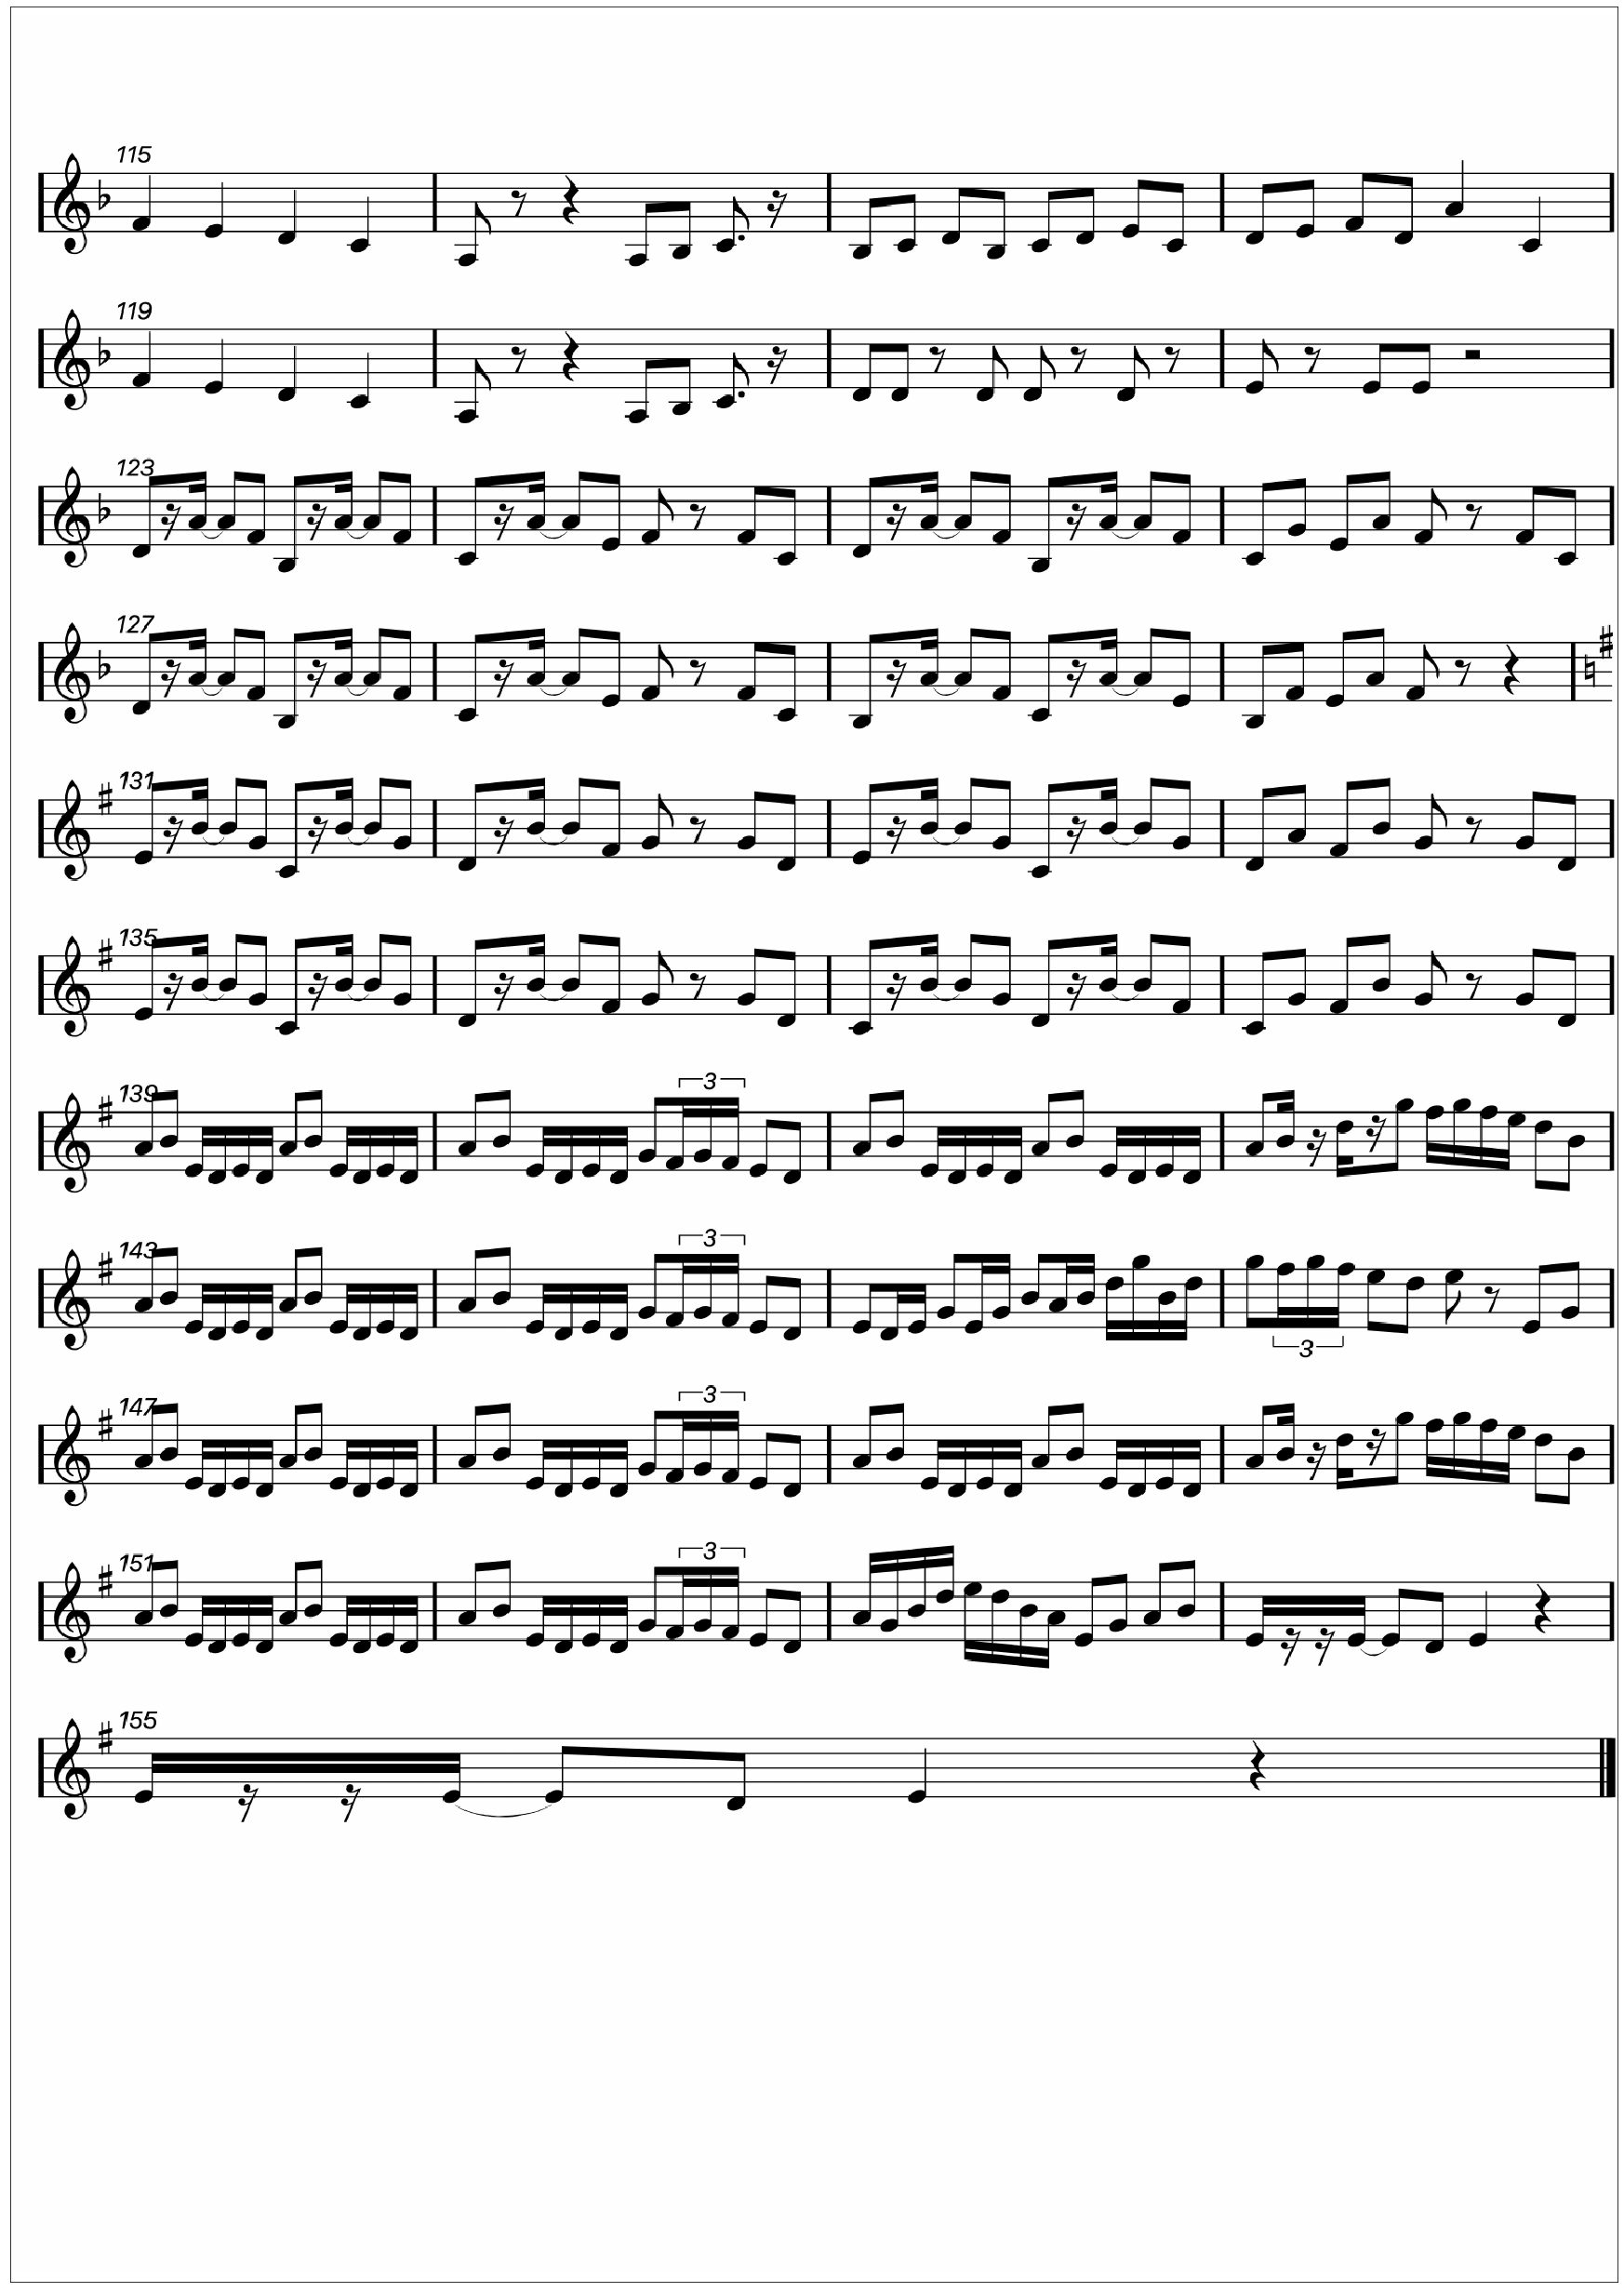

In [994]:
#元画像
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_origin, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

In [995]:
# print(img_delete.shape)
# y = 1800
# x=  1050
# dx = 600
# dy = 600
# plt.imshow(img_delete[y:y+dy,x:x+dx], cmap = "gray")
# plt.xticks([])
# plt.yticks([])
# plt.show()

弦番号を印字

In [996]:
img_draw = Image.fromarray(img_origin_gray) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意

In [997]:
# テキストを描画（位置、文章、フォント、文字色（BGR+α）を指定）
font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
font_size = 18        # フォントサイズ
fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義

font_size = 30        # フォントサイズ
fnt2 = ImageFont.truetype(font_path, font_size) # PILでフォントを定義

In [998]:
for i,note in enumerate(final_result):
#     if note[0]>1800 and note[1]>1050:
#         notename =  string_number_table_2_re[note[-2]]
#     else:
#         notename =  string_number_table_1_re[note[-2]]
    notename =  string_number_table_1_re[note[-2]]
#     notename =  string_number_table_2_re[note[-2]]
    
    if len(notename)>1 and notename[0:3]=='del':
        notename = '×'
#     print(notename)
    x = note[1] - 12#x座標取得 - 微調整
    gosen_id = note[-1]
    y = note[0] + gosen_interval*3.5
#     if searchline[gosen_id][-1] + gosen_interval/2<y :
#         y = searchline[gosen_id][-1] + 2*gosen_interval
    draw.text((x, y),notename, font=fnt,fill=20)

# draw.text((1050,1800),'ここから調弦変更\n=>', font=fnt2,fill=0)

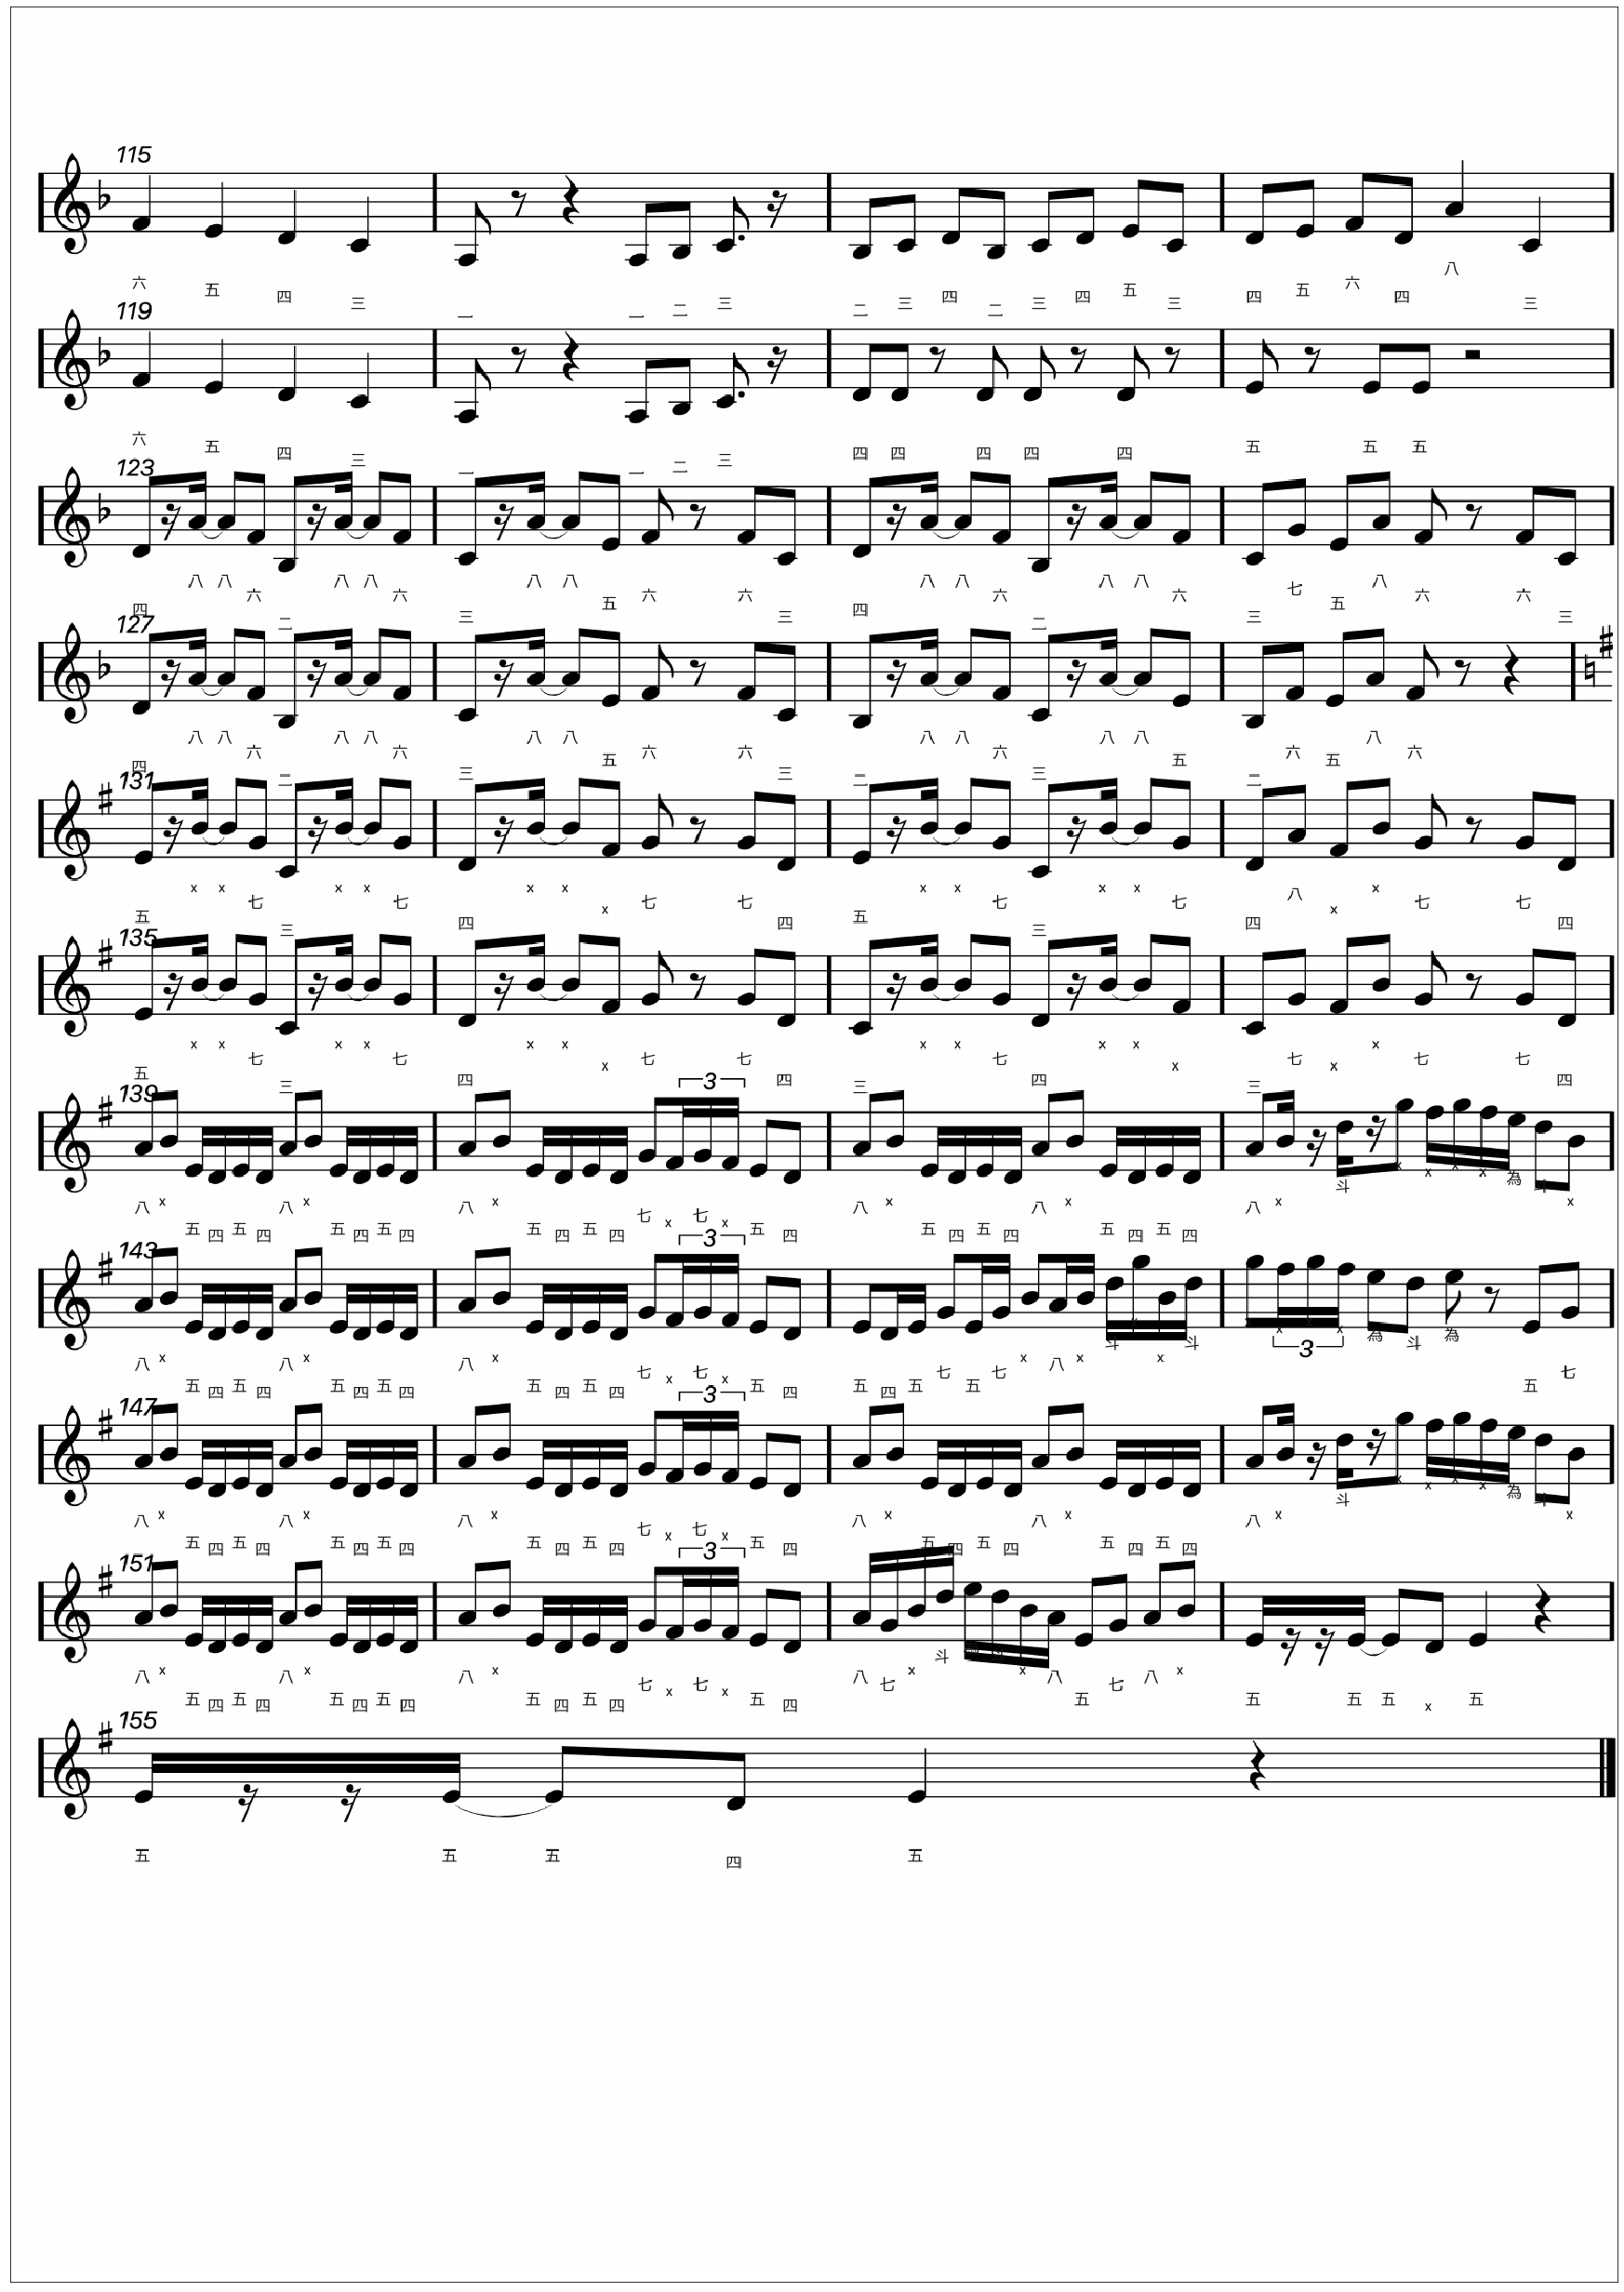

True

In [999]:
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

savepath = './../result/' + os.path.basename(musicsheet_path[:-4]) + '_string'+'.png'
cv2.imwrite(savepath,img_draw)

音名を印字

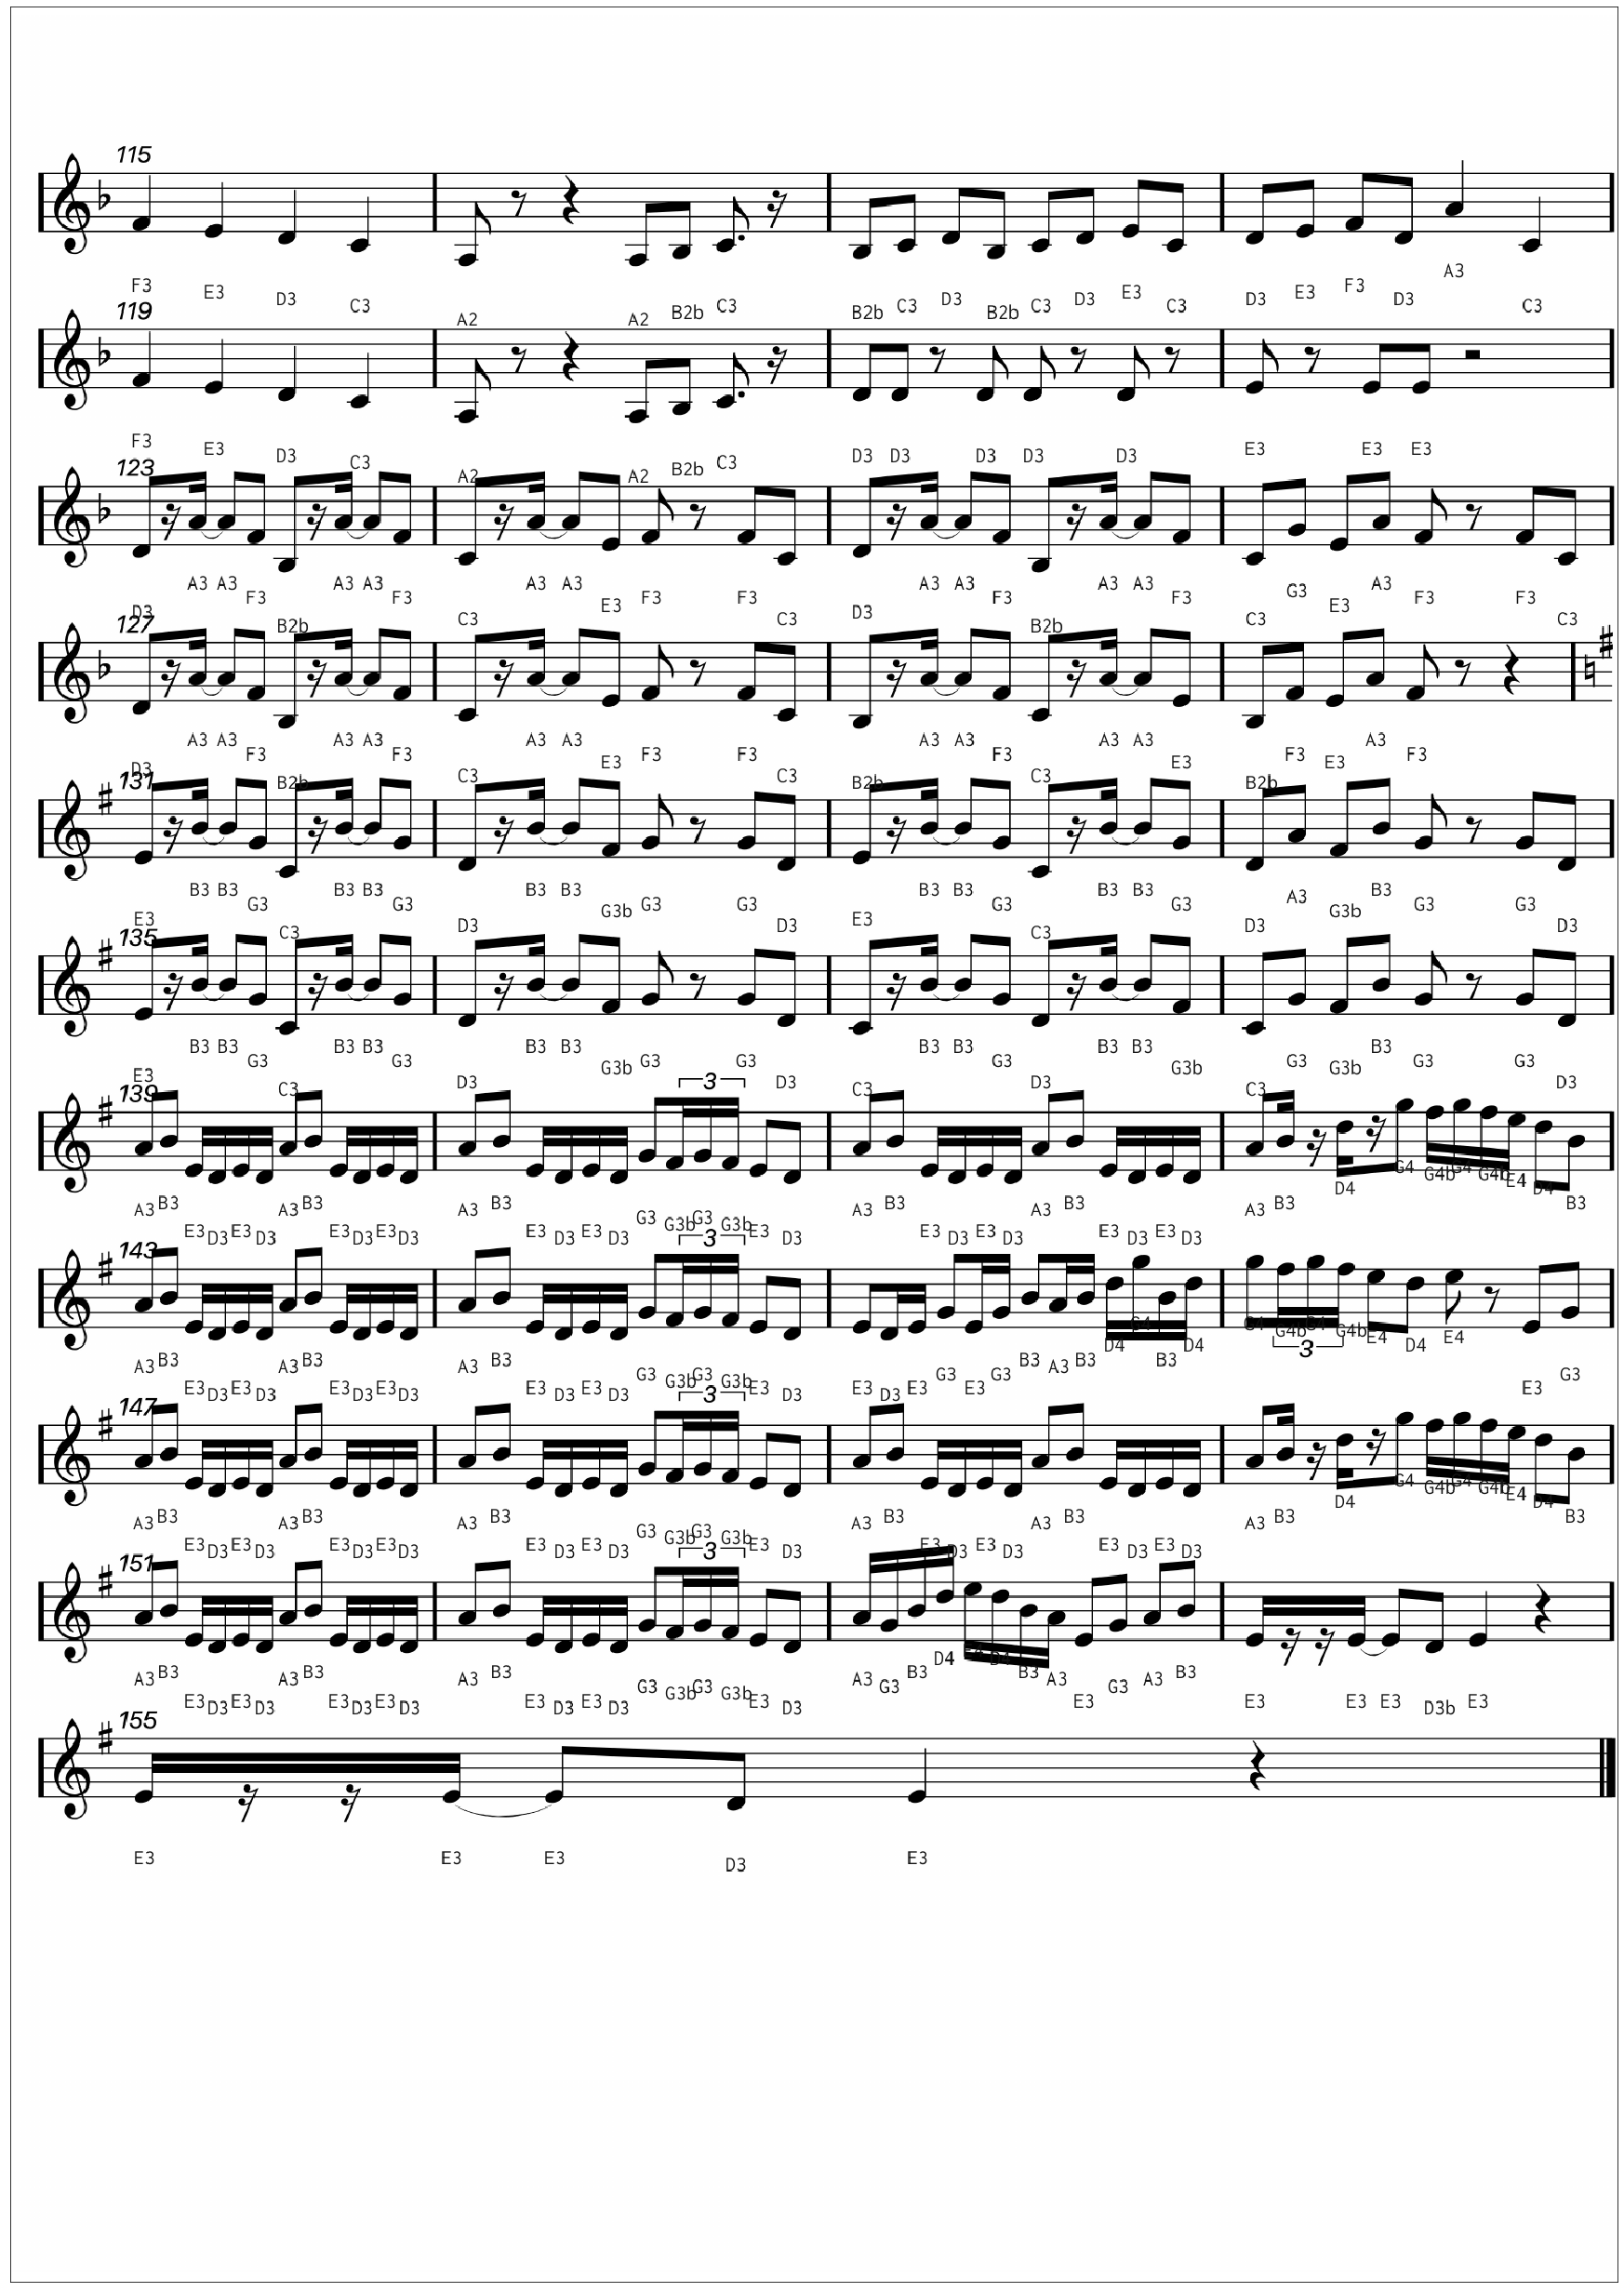

True

In [1000]:
img_draw = Image.fromarray(img_origin_gray) # cv2(NumPy)型の画像をPIL型に変換
draw = ImageDraw.Draw(img_draw)# 描画用のDraw関数を用意

# テキストを描画（位置、文章、フォント、文字色（BGR+α）を指定）
font_path = "/Users/matsudaira/Library/Fonts/RictyDiminished-Regular.ttf" #フォントパス
font_size = 22        # フォントサイズ
fnt = ImageFont.truetype(font_path, font_size) # PILでフォントを定義

for i,note in enumerate(final_result):
#     notename =  notename_jp_re[note[-2]]#音名取得
    notename =  notename_all_re[note[-2]]
#     if len(notename)>1 and notename[0:3]=='del':
#         notename = '×'
#     print(notename)
    x = note[1] - 12#x座標取得 - 微調整
    gosen_id = note[-1]
    y = note[0] + gosen_interval*3.5
#     if searchline[gosen_id][-1] + gosen_interval/2<y :
#         y = searchline[gosen_id][-1] + 2*gosen_interval
    draw.text((x, y),notename, font=fnt,fill=20)
    
img_draw = np.array(img_draw)# PIL型の画像をcv2(NumPy)型に変換
fig, ax = plt.subplots(figsize=(45,45))
plt.imshow(img_draw, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

savepath = './../result/' + os.path.basename(musicsheet_path[:-4]) + '_onmei'+'.png'
cv2.imwrite(savepath,img_draw)